In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
patrickgaspar_fossil_free_funds_path = kagglehub.dataset_download('patrickgaspar/fossil-free-funds')

print('Data source import complete.')


Data source import complete.


# Project proposal

In the financial fund industry, does green investment generate better performance ?   

## 1) The problem
* The idea of this project came from the raising interest in ESG funds to provide more sustainable investment vehicles to financial investors.
* The aim of this project is to analyze if funds selecting underlying environmental friendly assets can generate better financial performance.
* Finding available market data about ESG was a difficult task, as this kind of data is most of the time issued by market/index providers (MSCI, FTSE) and not freely available to the public. Hopefully, the platform https://fossilfreefunds.org/ offers more than 3,000 US stock funds ratings about environmental metrics with more than 10 months history.    

## 2) The data

### (a) Clear overview of your data
#### 2.a.1 Data origin and gathering
* The raw data can be acquired through download of Excel files directly from the webpage https://fossilfreefunds.org/how-it-works
* We can find 2 Excels files published each month. We only use the Fossil Free Funds (FFF) dataset where detailed information is contained
* The code below allows the download and import of these Excel files into a single csv file. I will be using mainly the "Shareclasses" sheet as it contains all the metrics for our analysis.

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import time
import csv
import os
import pickle
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import graphviz
from sklearn.neighbors import KNeighborsRegressor

# !pip install keras==2.12.0
# !pip uninstall tensorflow
# !pip install tensorflow==2.12.0

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor # There is also a KerasClassifier class
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

!pip install openpyxl
import openpyxl
print("Library versions: pandas", pd.__version__," numpy", np.__version__," seaborn", sns.__version__)

Library versions: pandas 2.2.2  numpy 1.23.5  seaborn 0.13.2


In [5]:
def download_data():
    URL = 'https://fossilfreefunds.org/how-it-works'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')

    urls = []
    names = []
    for i, link in enumerate(soup.findAll('a')):
        FULLURL = link.get('href')
        if bool(re.search('.*results.*.xlsx', FULLURL)):
            urls.append(FULLURL)
            names.append(os.path.basename(soup.select('a')[i].attrs['href']))

    names_urls = zip(names, urls)
    for name, url in names_urls:
        print("Download file: "+name)
        r = requests.get(url, verify=False,stream=True)
        r.raw.decode_content = True
        with open("/kaggle/working/" + name, 'wb') as out:
                shutil.copyfileobj(r.raw, out)

def merge_excel():
    df = pd.DataFrame()
    files=os.listdir('data')
    files_xls = [f for f in files if f[-4:]=='xlsx']

    for f in files_xls:
        if not re.match(r".*20210[5-9]+.*", f):
            print('Merging file: '+f)
            data = pd.read_excel('data/'+f, 'Shareclasses',engine='openpyxl')
            df = df.append(data)
    df.to_csv('/kaggle/working/fossilfund_dataset.csv', index=False)
    print('Export to data/fossilfund_dataset.csv is finished')

#No download ncessary for this notebook, use of Kaggle dataset directly
# if not os.path.exists('data'):
#    os.makedirs('data')
#    download_data()
#    merge_excel()

TypeError: expected string or bytes-like object

#### 2.a.2 Feature overview
* We can assess with the code below that we have a large number of columns (121) and rows (101407). The number of rows being significantly higher than the number of columns, that should help us avoid having too much bias in our model
* 41 columns have null values so we will have to find a way to handle that
* We have 101 numerical values

In [8]:
df = pd.read_csv('/content/fossilfund_dataset.csv')

<ipython-input-8-81e87c00be95>:1: DtypeWarning: Columns (94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/fossilfund_dataset.csv')


In [9]:
print("Total no. of columns in the dataframe", len(df.columns))
print("No. of columns containing null values", len(df.columns[df.isna().any()]))

print("No. of columns not containing null values", len(df.columns[df.notna().all()]))
print("No. of numerical columns ", len(df.select_dtypes(np.number).columns))

print("Total no. of rows in the dataframe", len(df))

Total no. of columns in the dataframe 121
No. of columns containing null values 42
No. of columns not containing null values 79
No. of numerical columns  101
Total no. of rows in the dataframe 110510


In [10]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110510 entries, 0 to 110509
Data columns (total 121 columns):
 #    Column                                                                                                          Non-Null Count   Dtype  
---   ------                                                                                                          --------------   -----  
 0    Fund profile: Shareclass name                                                                                   110510 non-null  object 
 1    Fund profile: Ticker                                                                                            108086 non-null  object 
 2    Fund profile: Fund name                                                                                         110510 non-null  object 
 3    Fund profile: Asset manager                                                                                     110510 non-null  object 
 4    Fund profile: Shareclass

* We can already convert date columns as date type instead of generic object

In [11]:
date_cols=df.filter(regex=" date.*",axis=1).columns
df[date_cols]=df[date_cols].apply(pd.to_datetime, errors='coerce')
df[date_cols]

Fund profile: Shareclass inception date  \
0                                   2014-11-12   
1                                   2014-11-12   
2                                   2014-11-12   
3                                   2014-11-12   
4                                   2011-12-28   
...                                        ...   
110505                              2018-12-04   
110506                              2018-09-05   
110507                              2018-12-04   
110508                              2019-03-06   
110509                              2019-06-25   

       Fund profile: Oldest shareclass inception date  \
0                                          2014-11-12   
1                                          2014-11-12   
2                                          2014-11-12   
3                                          2014-11-12   
4                                          2011-12-28   
...                                               ...   
110505                                     2018-12-04   
110506                                     2018-09-05   
110507                                     2018-12-04   
110508                                     2019-03-06   
110509                                     2019-06-25   

       Fund profile: Portfolio holdings as-of date  \
0                                       2020-01-31   
1                                       2020-01-31   
2                                       2020-01-31   
3                                       2020-01-31   
4                                       2019-12-31   
...                                            ...   
110505                                  2021-02-28   
110506                                  2021-02-28   
110507                                  2021-02-28   
110508                                  2021-02-28   
110509                                  2021-02-28   

       Financial performance: Financial performance as-of date  
0                                              2020-03-31       
1                                              2020-03-31       
2                                              2020-03-31       
3                                              2020-03-31       
4                                              2020-03-31       
...                                                   ...       
110505                                         2021-02-28       
110506                                         2021-02-28       
110507                                         2021-02-28       
110508                                         2021-02-28       
110509                                         2021-02-28       

[110510 rows x 4 columns]

* Sample dataset (first 10 rows)

In [12]:
display(HTML(df[0:10].to_html()))

* With the sample dataset above, we can observe the following group of features identified by the column names:
* *Fund information*: general information about the fund
    * Fund profile: Shareclass name
    * Fund profile: Ticker
    * Fund profile: Fund name
    * Fund profile: Asset manager
    * Fund profile: Shareclass type
    * Fund profile: Shareclass inception date
    * Fund profile: Category group
    * Fund profile: Sustainability mandate
    * Fund profile: US-SIF member
    * Fund profile: Oldest shareclass inception date
    * Fund profile: Shareclass tickers
    * Fund profile: Portfolio holdings as-of date
    * Fund profile: Fund net assets
    * Fund profile: Percent rated
* *Financial results*: our target variable is contained in that group
    * Financial performance: Financial performance as-of date
        * *Important date, keeps track of the date where performance of the fund is calculated*
    * Financial performance: Month end trailing returns, year 1
    * Financial performance: Month end trailing returns, year 3
    * Financial performance: Month end trailing returns, year 5
    * Financial performance: Month end trailing returns, year 10
* *Grading metrics*: overall grading by the FFF organization
    * Fossil Free Funds: Fossil fuel grade
    * Deforestation Free Funds: Deforestation grade
    * Gender Equality Funds: Gender equality grade
    * Gun Free Funds: Civilian firearm grade
    * Weapon Free Funds: Military weapon grade
    * Tobacco Free Funds: Tobacco grade
    * Prison Free Funds: Prison industrial complex grade
* *Detailed breakdown by categories*:
    * Fossil energy:
        * Fossil Free Funds: Fossil fuel holdings, count
        * Fossil Free Funds: Fossil fuel holdings, weight
        * Fossil Free Funds: Fossil fuel holdings, asset
        * Fossil Free Funds: Carbon Underground 200, count
        * Fossil Free Funds: Carbon Underground 200, weight
        * Fossil Free Funds: Carbon Underground 200, asset
        * Fossil Free Funds: Coal industry, count
        * Fossil Free Funds: Coal industry, weight
        * Fossil Free Funds: Coal industry, asset
        * Fossil Free Funds: Oil / gas industry, count
        * Fossil Free Funds: Oil / gas industry, weight
        * Fossil Free Funds: Oil / gas industry, asset
        * Fossil Free Funds: Macroclimate 30 coal-fired utilities, count
        * Fossil Free Funds: Macroclimate 30 coal-fired utilities, weight
        * Fossil Free Funds: Macroclimate 30 coal-fired utilities, asset
        * Fossil Free Funds: Fossil-fired utilities, count
        * Fossil Free Funds: Fossil-fired utilities, weight
        * Fossil Free Funds: Fossil-fired utilities, asset
        * Fossil Free Funds: Relative carbon footprint (tonnes CO2 / $1M USD invested)
        * Fossil Free Funds: Relative carbon intensity (tonnes CO2 / $1M USD revenue)
        * Fossil Free Funds: Total financed emissions scope 1 + 2 (tCO2e)
        * Fossil Free Funds: Total financed emissions scope 1 + 2 + 3 (tCO2e)
        * Fossil Free Funds: Carbon footprint portfolio coverage by market value weight
        * Fossil Free Funds: Carbon footprint portfolio coverage by number of disclosing titles
        * Fossil Free Funds: Clean200, count
        * Fossil Free Funds: Clean200, weight
        * Fossil Free Funds: Clean200, asset
    * Deforestation:
        * Deforestation Free Funds: Deforestation-risk producer, count
        * Deforestation Free Funds: Deforestation-risk producer, weight
        * Deforestation Free Funds: Deforestation-risk producer, asset
        * Deforestation Free Funds: Deforestation-risk financier, count
        * Deforestation Free Funds: Deforestation-risk financier, weight
        * Deforestation Free Funds: Deforestation-risk financier, asset
        * Deforestation Free Funds: Deforestation-risk consumer brand, count
        * Deforestation Free Funds: Deforestation-risk consumer brand, weight
        * Deforestation Free Funds: Deforestation-risk consumer brand, asset    
     * Gender Equality:
        * Gender Equality Funds: Gender equality group ranking
        * Gender Equality Funds: Gender equality score (out of 100 points)
        * Gender Equality Funds: Gender equality score, gender balance (out of 100 points)
        * Gender Equality Funds: Gender equality score, gender policies (out of 100 points)
        * Gender Equality Funds: Count of holdings with Equileap gender equality scores
        * Gender Equality Funds: Weight of holdings with Equileap gender equality scores
        * Gender Equality Funds: Gender equality score - Overall score (out of 100 points)
        * Gender Equality Funds: Gender equality score - Gender balance in leadership and workforce (out of 40 points)
        * Gender Equality Funds: Gender equality score - Equal compensation and work life balance (out of 30 points)
        * Gender Equality Funds: Gender equality score - Policies promoting gender equality (out of 20 points)
        * Gender Equality Funds: Gender equality score - Commitment, transparency, and accountability (out of 10 points)            
    * Gun:
        * Gun Free Funds: Civilian firearm, count
        * Gun Free Funds: Civilian firearm, weight
        * Gun Free Funds: Civilian firearm, asset
        * Gun Free Funds: Gun manufacturer, count
        * Gun Free Funds: Gun manufacturer, weight
        * Gun Free Funds: Gun manufacturer, asset
        * Gun Free Funds: Gun retailer, count
        * Gun Free Funds: Gun retailer, weight
        * Gun Free Funds: Gun retailer, asset
    * Weapon:            
        * Weapon Free Funds: Military weapon, count
        * Weapon Free Funds: Military weapon, weight
        * Weapon Free Funds: Military weapon, asset
        * Weapon Free Funds: Major military contractors, count
        * Weapon Free Funds: Major military contractors, weight
        * Weapon Free Funds: Major military contractors, asset
        * Weapon Free Funds: Nuclear weapons, count
        * Weapon Free Funds: Nuclear weapons, weight
        * Weapon Free Funds: Nuclear weapons, asset
        * Weapon Free Funds: Cluster munitions / landmines, count
        * Weapon Free Funds: Cluster munitions / landmines, weight
        * Weapon Free Funds: Cluster munitions / landmines, asset
    * Tobacco:            
        * Tobacco Free Funds: Tobacco producer, count
        * Tobacco Free Funds: Tobacco producer, weight
        * Tobacco Free Funds: Tobacco producer, asset
        * Tobacco Free Funds: Tobacco-promoting entertainment company, count
        * Tobacco Free Funds: Tobacco-promoting entertainment company, weight
        * Tobacco Free Funds: Tobacco-promoting entertainment company, asset
    * Prison:            
        * Prison Free Funds: All flagged, count
        * Prison Free Funds: All flagged, weight
        * Prison Free Funds: All flagged, asset
        * Prison Free Funds: Prison industry, count
        * Prison Free Funds: Prison industry, weight
        * Prison Free Funds: Prison industry, asset
        * Prison Free Funds: Border industry, count
        * Prison Free Funds: Border industry, weight
        * Prison Free Funds: Border industry, asset
        * Prison Free Funds: All flagged, higher risk, count
        * Prison Free Funds: All flagged, higher risk, weight
        * Prison Free Funds: All flagged, higher risk, asset
        * Prison Free Funds: Prison industry, higher risk, count
        * Prison Free Funds: Prison industry, higher risk, weight
        * Prison Free Funds: Prison industry, higher risk, asset
        * Prison Free Funds: Border industry, higher risk, count
        * Prison Free Funds: Border industry, higher risk, weight
        * Prison Free Funds: Border industry, higher risk, asset
        * Prison Free Funds: Private prison operators, count
        * Prison Free Funds: Private prison operators, weight
        * Prison Free Funds: Private prison operators, asset

* So we have a wide range of data information for each fund classification category: from overall category grades to the detailed breakdown of each category
* This classification is being kept under an Excel spreadsheet (replace.xlsx)
* The information contained in this spreadsheet will also be used later on for column renaming and feature aggregation (continuous, discrete, nominal, ordinal variables)

We can have more information provided by FFF about each feature description in the "Key" Excel sheet provided by FFF:

#### 2.a.3 Feature distribution
* The numerical features distribution per category is shown below
* We have features with empty data, notably on categories *Gender Equality Funds* and *Prison Free Funds*
* Several times, we see a global feature (e.g. *Fossil fuel holdings*) being decomposed on 3 sub-features: count, weight, asset
    * These 3 sub-features should normally be related to each other (high correlation)

In [13]:
#create variables for each group and display information separately
#Our target value has to be 1-y as it is the most complete => need to show fill factor
#display(HTML(    .to_html()))
origin_categories=["Fund profile","Fossil Free Funds", "Deforestation Free Funds", "Gender Equality Funds", "Gun Free Funds", "Prison Free Funds", "Weapon Free Funds", "Tobacco Free Funds", "Financial performance"]
for category in origin_categories:
    print("Distribution of numerical features for category: "+category)
    display(HTML(df.filter(regex=category+".*",axis=1).describe().to_html()))
    print("\n\n")

Distribution of numerical features for category: Fund profile





Distribution of numerical features for category: Fossil Free Funds





Distribution of numerical features for category: Deforestation Free Funds





Distribution of numerical features for category: Gender Equality Funds





Distribution of numerical features for category: Gun Free Funds





Distribution of numerical features for category: Prison Free Funds





Distribution of numerical features for category: Weapon Free Funds





Distribution of numerical features for category: Tobacco Free Funds





Distribution of numerical features for category: Financial performance


#### 2.a.4 Data completness
* It is important to check the data completness fill-factor
* We see that *Prison free* related category lacks information as well as some *Gender equality* indicators

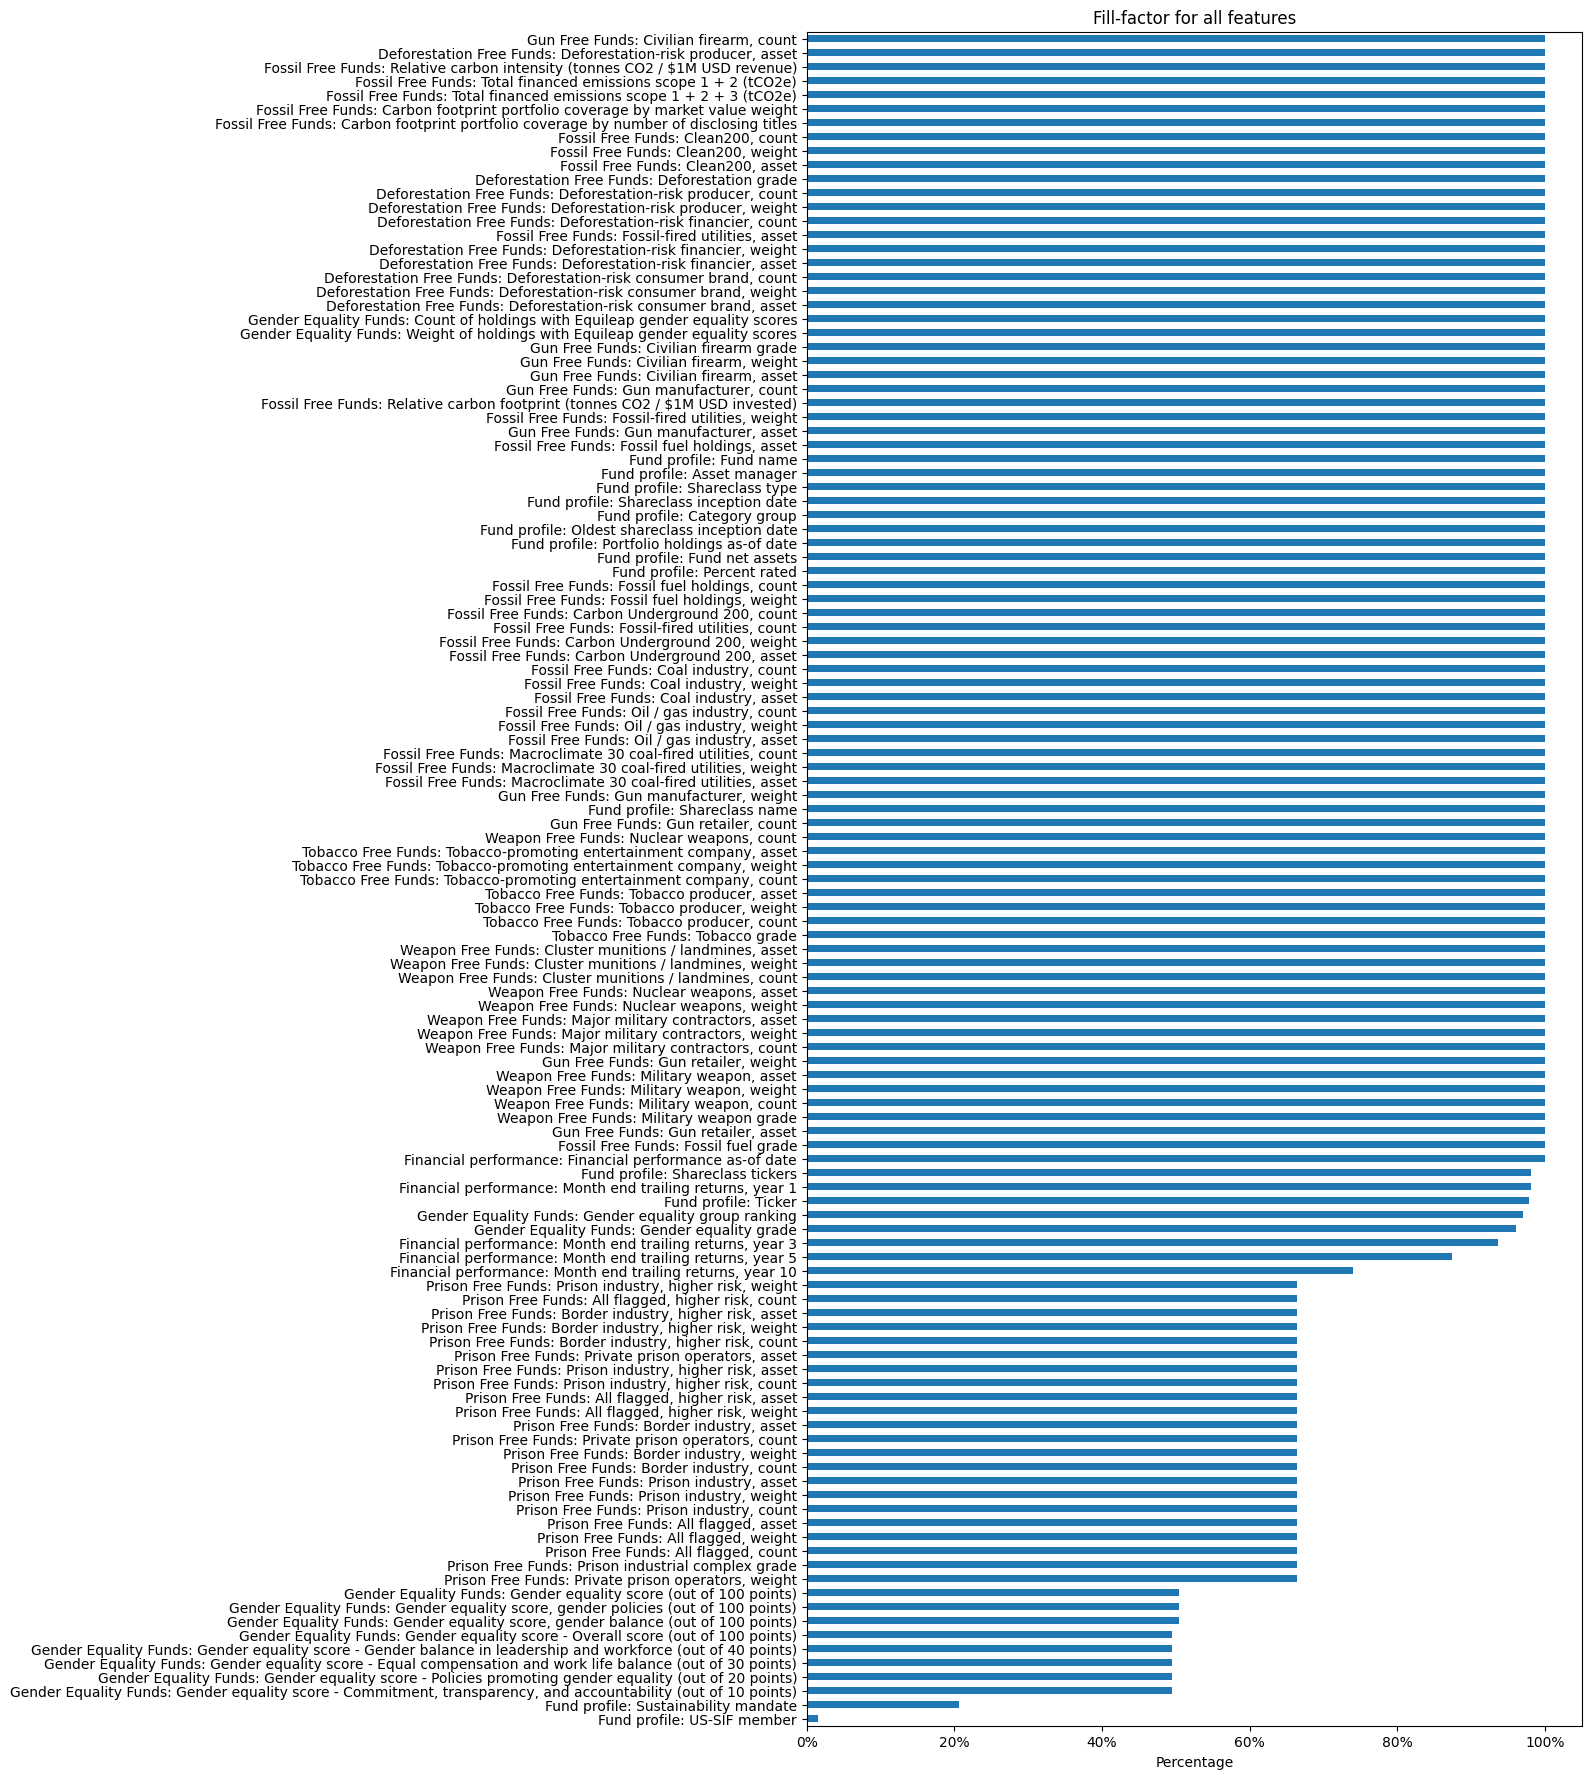

In [14]:
columns_stats=pd.DataFrame()
columns_stats['fill_percent']=df.notnull().sum(axis=0)/len(df)*100
fig = plt.figure(figsize=(10, 22))
columns_stats['fill_percent'].sort_values().plot.barh()
plt.title("Fill-factor for all features")
plt.xlabel("Percentage")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

#### 2.a.4.1 Remove non relevant columns
* We drop the columns with less than 60% of data completness, mostly related to Gender equality category

In [15]:
columns_stats[columns_stats['fill_percent']<60]

fill_percent
Fund profile: Sustainability mandate                   20.634332
Fund profile: US-SIF member                             1.544657
Gender Equality Funds: Gender equality score (o...     50.355624
Gender Equality Funds: Gender equality score, g...     50.355624
Gender Equality Funds: Gender equality score, g...     50.355624
Gender Equality Funds: Gender equality score - ...     49.409103
Gender Equality Funds: Gender equality score - ...     49.409103
Gender Equality Funds: Gender equality score - ...     49.409103
Gender Equality Funds: Gender equality score - ...     49.409103
Gender Equality Funds: Gender equality score - ...     49.409103

In [16]:
df.drop(columns=columns_stats[columns_stats['fill_percent']<60].index.values.tolist(), axis=1, inplace=True)

#### 2.a.5 Target selection
* Our target column will be part of the group "Financial performance".
    * By the table below, we select the target (among year 1,3,5,10) with the top fill-factor, that is "year 1".

In [17]:
columns_stats['fill_percent'].filter(regex="Financial performance.*")

Financial performance: Financial performance as-of date       99.994571
Financial performance: Month end trailing returns, year 1     98.060809
Financial performance: Month end trailing returns, year 3     93.609628
Financial performance: Month end trailing returns, year 5     87.360420
Financial performance: Month end trailing returns, year 10    73.973396
Name: fill_percent, dtype: float64

The "Financial performance: Month end trailing returns, year 1" is the most complete variable as a high percentage of funds have an inception date greater than 2 years (so performance for "year 1" is available) but less than 10 years (so no performance data available for "year 10")

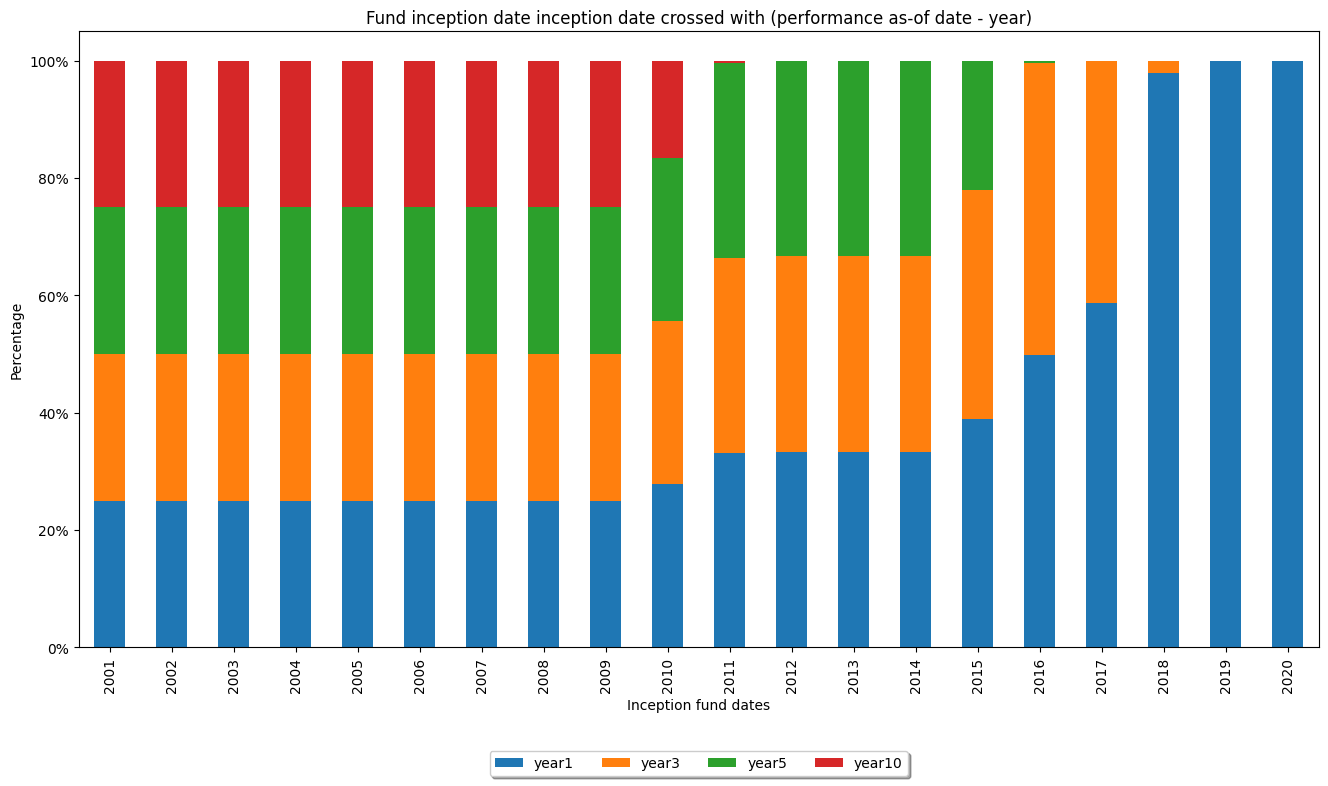

In [18]:
perf_date=pd.DataFrame()
for year in [1,3,5,10]:
    filter_df=df['Fund profile: Shareclass inception date'][( (df['Financial performance: Financial performance as-of date'] - pd.DateOffset(years=year)) > df['Fund profile: Shareclass inception date']  )]
    perf_date["year"+str(year)] =filter_df.groupby(filter_df.dt.year).count()

#Normalize row perf_data by year
perf_date_norm=perf_date.div(perf_date.sum(axis=1), axis=0)*100
perf_date_norm.loc['2000-1-1 00:00:00':'2022-1-1 00:00:00'].plot.bar(figsize=(16, 8), stacked=True)

#Plot properties
plt.xlabel("Inception fund dates")
plt.ylabel("Percentage")
plt.title("Fund inception date inception date crossed with (performance as-of date - year)")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.22),
          ncol=4, fancybox=True, shadow=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
#plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

#### 2.a.6 Data uniqueness
* Performance data is the only type of information showing strong uniqueness

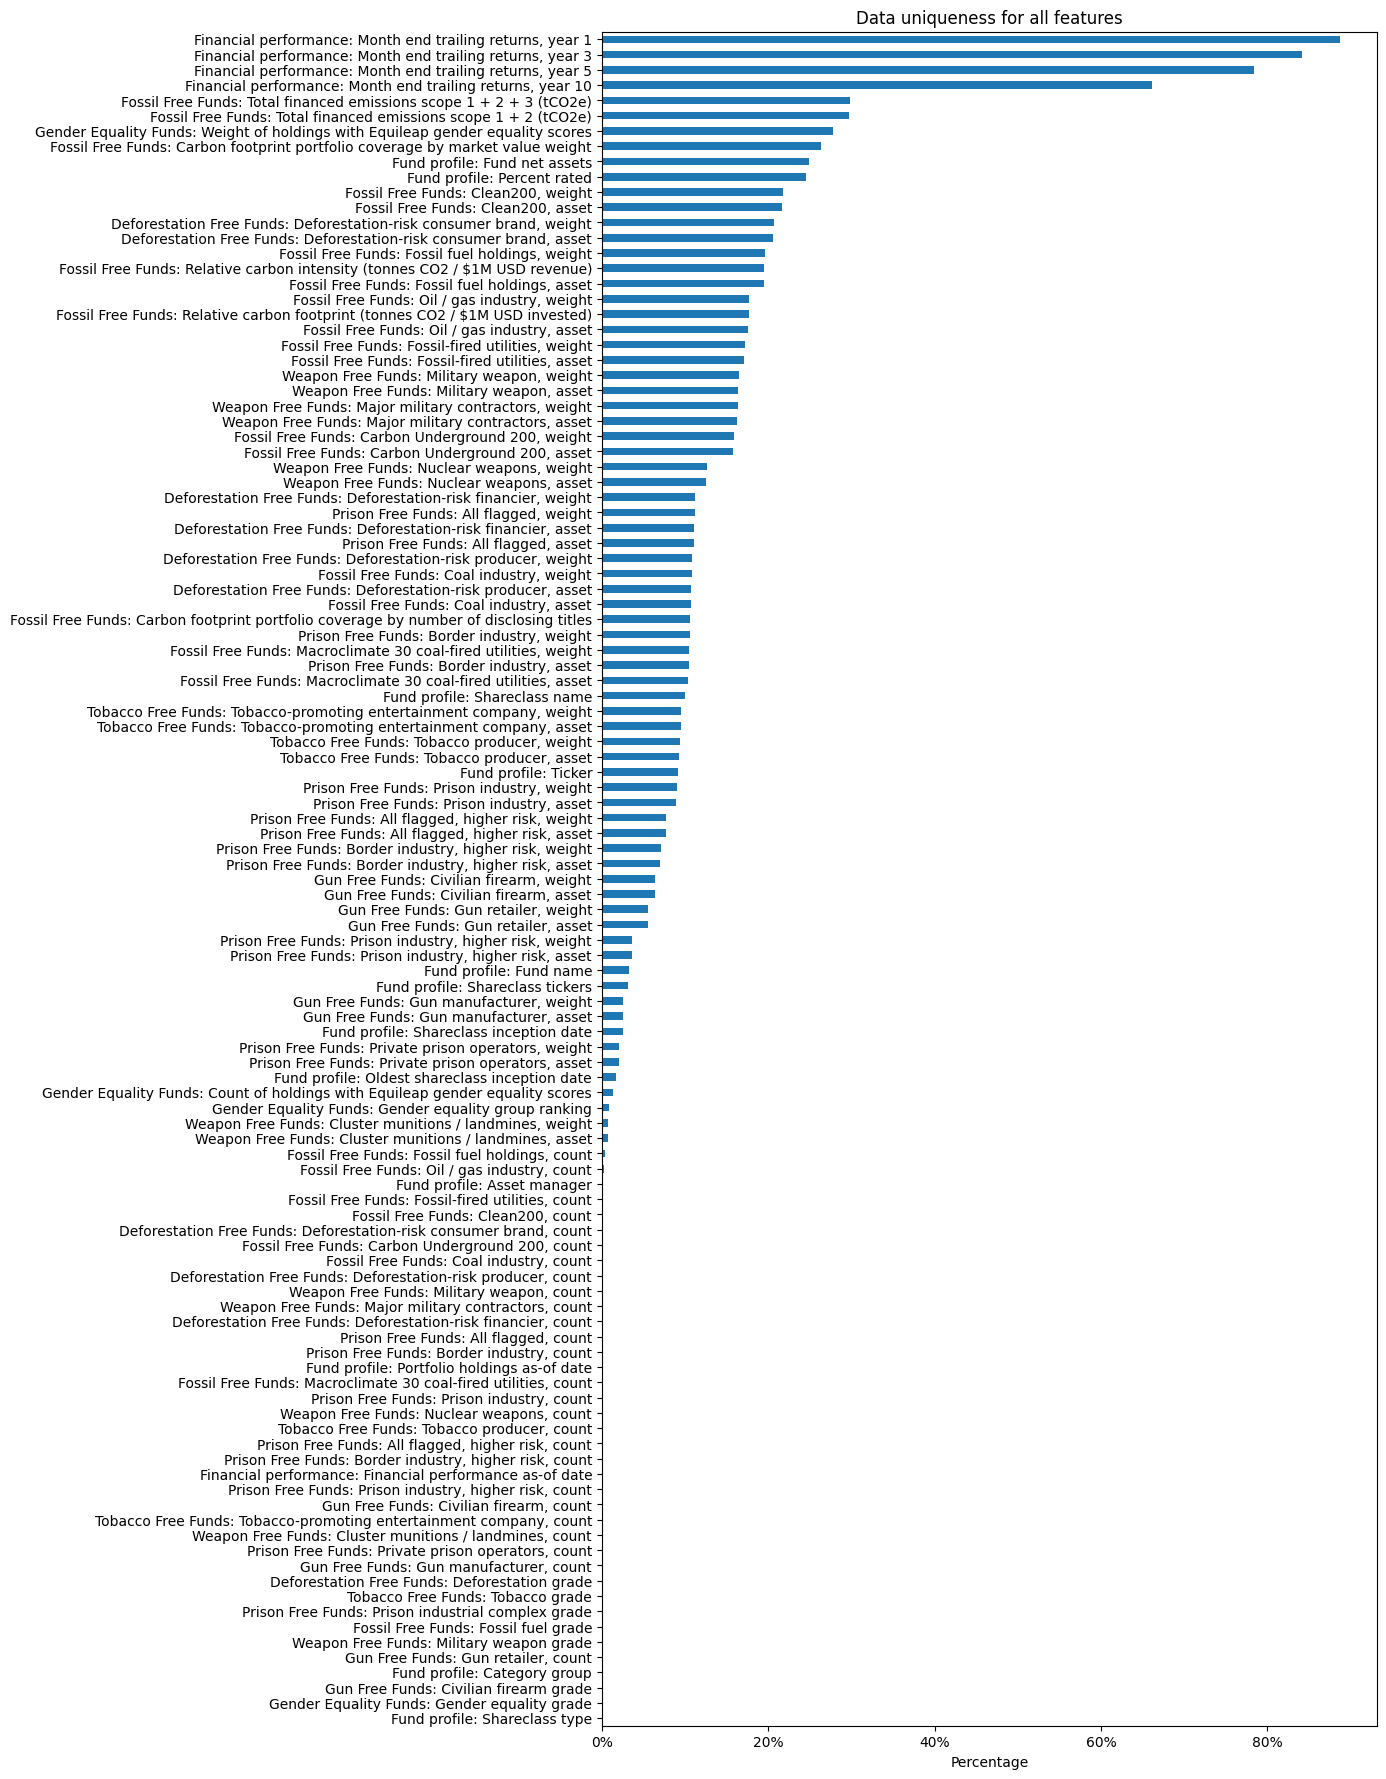

In [19]:
columns_stats=pd.DataFrame()
columns_stats['unique_values']=df.nunique()/len(df)*100
fig = plt.figure(figsize=(10, 22))
columns_stats['unique_values'].sort_values().plot.barh()
plt.title("Data uniqueness for all features")
plt.xlabel("Percentage")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

#### 2.a.7 Columns renaming
* Column names are renamed to make plots more readable by using the Excel spreadsheet previously defined

In [20]:
cols_df=pd.read_excel('/content/replace.xlsx', 'Cols',  engine='openpyxl')
df.rename(columns=dict(zip(cols_df["Column original"],cols_df["Short column name"])), inplace=True)

In [21]:
def getColCategory(category):
    return list(set(cols_df[cols_df['Category']==category]['Short column name']) & set(df.columns))

def getColType(type_col):
    return list(set(cols_df[cols_df['Type']==type_col]['Short column name']) & set(df.columns))

def getEncoding(shortName):
    return cols_df[cols_df['Short column name']==shortName]['encoding'].values[0]

In [22]:
continuous= getColType('Continuous')
discrete= getColType('Discrete')
ordinal= getColType('Ordinal')
nominal= getColType('Nominal')

date_cols=df.filter(regex=".*Date.*",axis=1).columns

#### 2.a.8 0-Values  
* It is important to keep track of feature with a high percentage of low values so we can add this information later in our analyis
* We observe that the features displaying a higher number of 0-values than our threshold are part of the sub-features (count, weight, asset)

In [23]:
threshold_0_level=10

def zeros_columns(df, col_category):
    zeros_percentage=(df[col_category]==0).sum()*100/len(df[col_category])
    zeros=zeros_percentage[(zeros_percentage>threshold_0_level)].index.values.tolist()
    print("Columns with 0-values > "+str(threshold_0_level)+"% : "+str(len(zeros))+"/"+str(len(col_category)))
    print(zeros_percentage[(zeros_percentage>threshold_0_level)].sort_values(ascending=False))
    return zeros
continuous_zeros = zeros_columns(df, continuous)
discrete_zeros = zeros_columns(df, discrete)

Columns with 0-values > 10% : 52/65
W_ClusterMunitions_a          98.328658
W_ClusterMunitions_w          98.328658
G_GunManufacturer_a           93.501041
G_GunManufacturer_w           93.501041
G_GunRetailer_w               80.152022
G_GunRetailer_a               80.152022
G_CivilianFirearm_w           77.507013
G_CivilianFirearm_a           77.507013
T_TobaccoProducer_a           64.841191
T_TobaccoProducer_w           64.841191
D_RiskProducer_a              62.764456
D_RiskProducer_w              62.764456
F_CoalIndustry_a              62.061352
F_CoalIndustry_w              62.061352
T_Tobacco-Promoting_w         61.771785
T_Tobacco-Promoting_a         61.771785
F_30Coal-FiredUtilities_w     61.066872
F_30Coal-FiredUtilities_a     61.066872
P_PrivatePrisonOperators_a    60.136639
P_PrivatePrisonOperators_w    60.136639
P_PrisonIndustryHR_w          53.933581
P_PrisonIndustryHR_a          53.933581
D_RiskFinancier_a             53.377975
D_RiskFinancier_w             53.377975
W_Nu

#### 2.a.9 Null values
* Lot of null values for nominal and ordinal data
* We will replace n/a with median values for numerical data in the feature encoding section  
* For categorical data, n/a values will be replaced with NoMapping value

In [24]:
threshold_null_level=2

def null_columns(df, col_category):
    null_percentage=(df[col_category].isnull()).sum()*100/len(df[col_category])
    nulls=null_percentage[(null_percentage>threshold_null_level)].index.values.tolist()
    print("Columns with null-values > "+str(threshold_null_level)+"% : "+str(len(nulls))+"/"+str(len(col_category)))
    print(null_percentage[(null_percentage>threshold_null_level)].sort_values(ascending=False))
    return nulls

discrete_null = null_columns(df, discrete)
continuous_null = null_columns(df, continuous)
nominal_null = null_columns(df, nominal)
ordinal_null = null_columns(df, ordinal)

Columns with null-values > 2% : 8/32
P_PrisonIndustry_c            33.646729
P_AllFlagged_c                33.646729
P_BorderIndustry_c            33.646729
P_PrivatePrisonOperators_c    33.646729
P_AllFlaggedHR_c              33.646729
P_BorderIndustryHR_c          33.646729
P_PrisonIndustryHR_c          33.646729
GE_GenderEqualityRanking       2.951769
dtype: float64
Columns with null-values > 2% : 17/65
P_PrisonIndustry_a            33.646729
P_BorderIndustry_w            33.646729
P_PrisonIndustryHR_a          33.646729
P_PrivatePrisonOperators_w    33.646729
P_PrisonIndustryHR_w          33.646729
P_AllFlaggedHR_a              33.646729
P_AllFlagged_w                33.646729
P_PrisonIndustry_w            33.646729
P_PrivatePrisonOperators_a    33.646729
P_AllFlagged_a                33.646729
P_AllFlaggedHR_w              33.646729
P_BorderIndustryHR_a          33.646729
P_BorderIndustryHR_w          33.646729
P_BorderIndustry_a            33.646729
FP_ReturnsY10                 

#### 2.a.10 Duplicate values check
* We first try to see if there is some duplicate row => the result is none

In [25]:
df.duplicated().sum()

0

* To catch duplicate values, as there is no unique id available per row, we will have to use a multiindex with the following combination
'FI_ShareclassName', 'FP_PerformanceAs-OfDate'
* We take FI_ShareclassName for this selection as it containes the most unique dataset

In [26]:
df[nominal].nunique()/len(df)*100

FI_ShareclassName       9.996380
FI_CategoryGroup        0.004524
FI_ShareclassType       0.001810
FI_AssetManager         0.191838
FI_ShareclassTickers    3.147226
FI_Ticker               9.096009
FI_FundName             3.275722
dtype: float64

* We first check how many duplicate entries with these 2 features combination: #9254 rows duplicate

In [28]:
index_col=['FI_ShareclassName', 'FP_PerformanceAs-OfDate']
duplicate_rows=df[df.duplicated(subset=index_col, keep=False)]
duplicate_rows.to_csv('/content/temp.csv', sep=';')
duplicate_rows

FI_ShareclassName FI_Ticker  \
4774   Invesco Oppenheimer Sml Cap Val R5     OVSAX   
11464             Delaware Global Value A     DABAX   
11465             Delaware Global Value C     DABAX   
11466          Delaware Global Value Inst     DABAX   
13992  Invesco Oppenheimer Sml Cap Val R5     IOSDX   
...                                   ...       ...   
64868           Xtrackers S&P 500 ESG ETF      SNPE   
64869     Zevenbergen Genea Institutional     ZVGIX   
64870          Zevenbergen Genea Investor     ZVGNX   
64871    Zevenbergen Growth Institutional     ZVNIX   
64872         Zevenbergen Growth Investor     ZVNBX   

                                    FI_FundName  \
4774   Invesco Oppenheimer Small Cap Value Fund   
11464                Delaware Global Value Fund   
11465                Delaware Global Value Fund   
11466                Delaware Global Value Fund   
13992  Invesco Oppenheimer Small Cap Value Fund   
...                                         ...   
64868                 Xtrackers S&P 500 ESG ETF   
64869                    Zevenbergen Genea Fund   
64870                    Zevenbergen Genea Fund   
64871                   Zevenbergen Growth Fund   
64872                   Zevenbergen Growth Fund   

                       FI_AssetManager     FI_ShareclassType  \
4774                           Invesco  Open-end mutual fund   
11464      Delaware Funds by Macquarie  Open-end mutual fund   
11465      Delaware Funds by Macquarie  Open-end mutual fund   
11466      Delaware Funds by Macquarie  Open-end mutual fund   
13992                          Invesco  Open-end mutual fund   
...                                ...                   ...   
64868                        Xtrackers                   ETF   
64869  Zevenbergen Capital Investments  Open-end mutual fund   
64870  Zevenbergen Capital Investments  Open-end mutual fund   
64871  Zevenbergen Capital Investments  Open-end mutual fund   
64872  Zevenbergen Capital Investments  Open-end mutual fund   

      FI_ShareclassInceptionDate            FI_CategoryGroup  \
4774                  2019-05-24            U.S. Equity Fund   
11464                 1997-12-19  International Equity Funds   
11465                 2001-09-28  International Equity Funds   
11466                 1997-12-19  International Equity Funds   
13992                 2019-05-24            U.S. Equity Fund   
...                          ...                         ...   
64868                 2019-06-25            U.S. Equity Fund   
64869                 2015-08-31            U.S. Equity Fund   
64870                 2015-08-31            U.S. Equity Fund   
64871                 2015-08-31            U.S. Equity Fund   
64872                 2015-08-31            U.S. Equity Fund   

      FI_OldestShareInceptionDate                      FI_ShareclassTickers  \
4774                   2015-12-07  IOSDX, OVSAX, OVSCX, OVSIX, OVSRX, OVSYX   
11464                  1997-12-19                       DABAX, DABCX, DABIX   
11465                  1997-12-19                       DABAX, DABCX, DABIX   
11466                  1997-12-19                       DABAX, DABCX, DABIX   
13992                  2019-05-24                                     IOSDX   
...                           ...                                       ...   
64868                  2019-06-25                                      SNPE   
64869                  2015-08-31                              ZVGIX, ZVGNX   
64870                  2015-08-31                              ZVGIX, ZVGNX   
64871                  2015-08-31                              ZVNBX, ZVNIX   
64872                  2015-08-31                              ZVNBX, ZVNIX   

      FI_PortfolioHoldingsAs-OfDate  ...  P_AllFlaggedHR_a  \
4774                     2019-12-31  ...               NaN   
11464                    2020-03-31  ...               NaN   
11465                    2020-03-31  ...               NaN   
11466          

After looking at the raw data, it appears data has been published twice in 2 datasets:
* Invest+Your+Values+shareclass+results+20200913.xlsx
* Invest+Your+Values+shareclass+results+20200928.xlsx

* We decide to keep only the first occurence of duplicated rows together based on 'FI_ShareclassName', 'FP_PerformanceAs-OfDate'

In [29]:
origin_len=len(df)
duplicate_len=len(df[df.duplicated(subset=index_col, keep='last')])
df=df[~df.duplicated(subset=index_col, keep='last')]

* We can verify that we have no more null values and only 9254 have been removed

In [30]:
print("Remaining rows:",len(df),"(",origin_len,"-",duplicate_len,")")
df[df.duplicated(subset=index_col, keep=False)]

Remaining rows: 101260 ( 110510 - 9250 )


Empty DataFrame
Columns: [FI_ShareclassName, FI_Ticker, FI_FundName, FI_AssetManager, FI_ShareclassType, FI_ShareclassInceptionDate, FI_CategoryGroup, FI_OldestShareInceptionDate, FI_ShareclassTickers, FI_PortfolioHoldingsAs-OfDate, FI_FundNetAssets, FI_PercentRated, F_FossilFuelGrade, F_FossilFuelHoldings_c, F_FossilFuelHoldings_w, F_FossilFuelHoldings_a, F_CarbonUnderground_c, F_CarbonUnderground_w, F_CarbonUnderground_a, F_CoalIndustry_c, F_CoalIndustry_w, F_CoalIndustry_a, F_Oil/GasIndustry_c, F_Oil/GasIndustry_w, F_Oil/GasIndustry_a, F_30Coal-FiredUtilities_c, F_30Coal-FiredUtilities_w, F_30Coal-FiredUtilities_a, F_Fossil-FiredUtilities_c, F_Fossil-FiredUtilities_w, F_Fossil-FiredUtilities_a, F_RelativeCarbonFootprint, F_RelativeCarbonIntensity, F_TotalEmissions1+2, F_TotalEmissions1+2+3, F_CarbonMarketValueWeight, F_CarbonPortfolioCoverage, F_Clean200_c, F_Clean200_w, F_Clean200_a, D_DeforestationGrade, D_RiskProducer_c, D_RiskProducer_w, D_RiskProducer_a, D_RiskFinancier_c, D_RiskFinancier_w, D_RiskFinancier_a, D_RiskConsumerBrand_c, D_RiskConsumerBrand_w, D_RiskConsumerBrand_a, GE_GenderEqualityGrade, GE_GenderEqualityRanking, GE_CountOfHoldings, GE_WeightOfHoldings, G_CivilianFirearmGrade, G_CivilianFirearm_c, G_CivilianFirearm_w, G_CivilianFirearm_a, G_GunManufacturer_c, G_GunManufacturer_w, G_GunManufacturer_a, G_GunRetailer_c, G_GunRetailer_w, G_GunRetailer_a, W_MilitaryWeaponGrade, W_MilitaryWeapon_c, W_MilitaryWeapon_w, W_MilitaryWeapon_a, W_MilitaryContractors_c, W_MilitaryContractors_w, W_MilitaryContractors_a, W_NuclearWeapons_c, W_NuclearWeapons_w, W_NuclearWeapons_a, W_ClusterMunitions_c, W_ClusterMunitions_w, W_ClusterMunitions_a, T_TobaccoGrade, T_TobaccoProducer_c, T_TobaccoProducer_w, T_TobaccoProducer_a, T_Tobacco-Promoting_c, T_Tobacco-Promoting_w, T_Tobacco-Promoting_a, FP_PerformanceAs-OfDate, FP_ReturnsY1, FP_ReturnsY3, FP_ReturnsY5, FP_ReturnsY10, P_PrisonIndustrialComplexGrade, P_AllFlagged_c, P_AllFlagged_w, P_AllFlagged_a, P_PrisonIndustry_c, P_PrisonIndustry_w, P_PrisonIndustry_a, P_BorderIndustry_c, P_BorderIndustry_w, P_BorderIndustry_a, P_AllFlaggedHR_c, ...]
Index: []

[0 rows x 111 columns]

#### 2.a.11 Missing data
With the plot below, we want to verify if there is a data gap:
 * We can identify a data gap for November 2020
 * The number and allocation of asset managers per date is quite constant

In [31]:
df_tmp=df.copy()
df_tmp['FI_AssetManagerFirstLetter']=df_tmp['FI_AssetManager'].str[0]
grouped_df=df_tmp.groupby(df_tmp['FP_PerformanceAs-OfDate'])
grouped_df['FI_AssetManagerFirstLetter'].value_counts()

FP_PerformanceAs-OfDate  FI_AssetManagerFirstLetter
2020-03-31               F                             1130
                         J                              951
                         A                              914
                         I                              782
                         B                              697
                                                       ... 
2021-02-28               L                               13
                         U                                7
                         K                                6
                         X                                5
                         1                                3
Name: count, Length: 280, dtype: int64

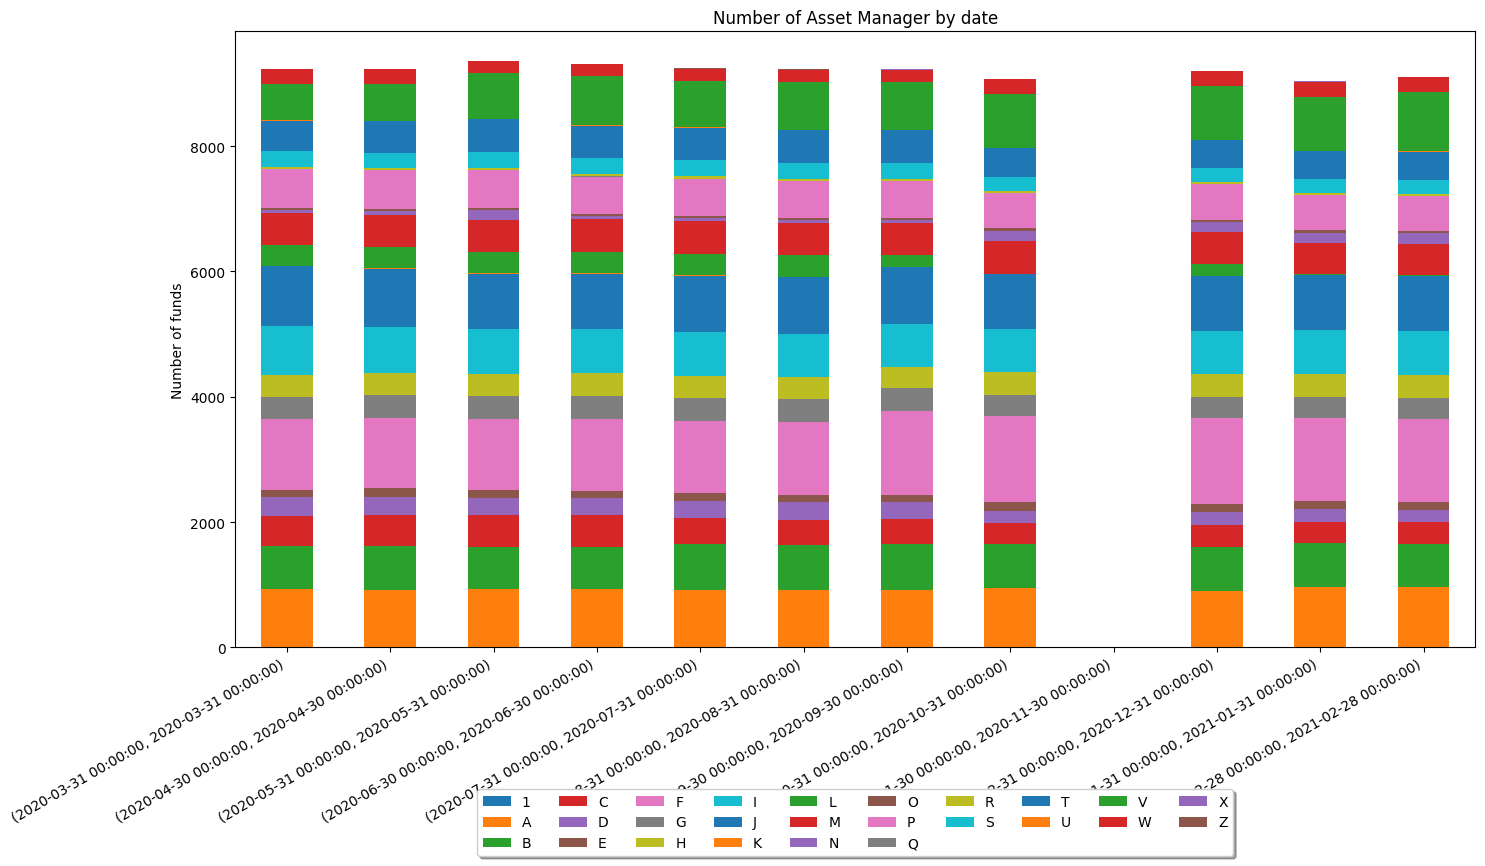

In [32]:
grouped_df['FI_AssetManagerFirstLetter'].value_counts().groupby(level=0).apply(
    lambda x: x
).unstack().plot.bar(figsize=(16, 8), stacked=True)

#Plot properties
plt.ylabel("Number of funds")
plt.xlabel("FI_AssetManagerFirstLetter")
plt.title("Number of Asset Manager by date")
plt.get_cmap('gist_rainbow')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35),
          ncol=10, fancybox=True, shadow=True)
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

#### We observe which funds (shareclassname) have partial information
* We decide to remove funds with less than 60% complete of information

In [33]:
per_share_max_count = df.groupby(['FI_ShareclassName'])['FI_ShareclassName'].value_counts().max()
threshold_max_count=0.6

partial_share_missing=df.copy()
partial_share_missing=partial_share_missing.groupby(['FI_ShareclassName']).filter(lambda x: len(x) <= threshold_max_count * per_share_max_count)
partial_share_missing.groupby(['FI_ShareclassName'])['FI_ShareclassName'].value_counts().sort_values(ascending=False)

FI_ShareclassName
Morgan Stanley EmMkts Breakout Ntns C       6
Invesco Oppenheimer Main Street R5          6
Invesco Oppenheimer Main Street Y           6
Invesco Oppenheimer Main Strt All Cap R5    6
Invesco Oppenheimer Main Strt All Cap R6    6
                                           ..
Virtus AllianzGI Emerging Markets Opps P    1
Virtus AllianzGI Emerging Markets Opps C    1
Virtus AllianzGI Emerging Markets Opps A    1
Virtus AllianzGI EM Opps R6                 1
Catholic Investor Global Real Estt I        1
Name: count, Length: 2161, dtype: int64

In [34]:
origin_len=len(df)
df.drop(partial_share_missing.index, inplace=True)
print("Remaining rows:",len(df),"(",origin_len,"-",len(partial_share_missing),")")

Remaining rows: 93718 ( 101260 - 7542 )


#### 2.a.11.1 Missing date
* Replace missing performance date with the performance date of the previous row

In [35]:
for date_col in df.filter(regex="Date.*",axis=1).columns:
    print('Number of empty dates for columns',date_col,":",len(df[df[date_col].isnull()]))
df[df['FP_PerformanceAs-OfDate'].isnull()]

Number of empty dates for columns FI_ShareclassInceptionDate : 0
Number of empty dates for columns FI_OldestShareInceptionDate : 0
Number of empty dates for columns FI_PortfolioHoldingsAs-OfDate : 0
Number of empty dates for columns FP_PerformanceAs-OfDate : 4


FI_ShareclassName FI_Ticker  \
26019              Putnam Global Health Care R6     PCHSX   
27722   Wells Fargo Fundamental Small Cap Gr R6     EGRYX   
27754  Wells Fargo Intrinsic Small Cap Value R6     WFSMX   
27791                Wells Fargo Opportunity R6     WOFRX   

                                         FI_FundName    FI_AssetManager  \
26019                 Putnam Global Health Care Fund             Putnam   
27722  Wells Fargo Fundamental Small Cap Growth Fund  Wells Fargo Funds   
27754     Wells Fargo Intrinsic Small Cap Value Fund  Wells Fargo Funds   
27791                   Wells Fargo Opportunity Fund  Wells Fargo Funds   

          FI_ShareclassType FI_ShareclassInceptionDate     FI_CategoryGroup  \
26019  Open-end mutual fund                 2020-06-01  Sector Equity Funds   
27722  Open-end mutual fund                 2020-06-01     U.S. Equity Fund   
27754  Open-end mutual fund                 2020-06-01     U.S. Equity Fund   
27791  Open-end mutual fund                 2020-06-01     U.S. Equity Fund   

      FI_OldestShareInceptionDate                      FI_ShareclassTickers  \
26019                  1982-05-28  PCHSX, PGHAX, PHSBX, PHSRX, PHSTX, PHSYX   
27722                  1995-06-05         EGRYX, EGWAX, EGWCX, EGWDX, EGWRX   
27754                  2005-04-08         WFSDX, WFSJX, WFSMX, WFSSX, WSCDX   
27791                  2000-02-24         SOPVX, WFOPX, WOFDX, WOFNX, WOFRX   

      FI_PortfolioHoldingsAs-OfDate  ...  P_AllFlaggedHR_a  \
26019                    2020-03-31  ...               NaN   
27722                    2020-04-30  ...               NaN   
27754                    2020-04-30  ...               NaN   
27791                    2020-04-30  ...               NaN   

       P_PrisonIndustryHR_c P_PrisonIndustryHR_w  P_PrisonIndustryHR_a  \
26019                   NaN                  NaN                   NaN   
27722                   NaN                  NaN                   NaN   
27754                   NaN                  NaN                   NaN   
27791                   NaN                  NaN                   NaN   

       P_BorderIndustryHR_c  P_BorderIndustryHR_w  P_BorderIndustryHR_a  \
26019                   NaN                   NaN                   NaN   
27722                   NaN                   NaN                   NaN   
27754                   NaN                   NaN                   NaN   
27791                   NaN                   NaN                   NaN   

       P_PrivatePrisonOperators_c  P_PrivatePrisonOperators_w  \
26019                         NaN                         NaN   
27722                         NaN                         NaN   
27754                         NaN                         NaN   
27791                         NaN                         NaN   

       P_PrivatePrisonOperators_a  
26019                         NaN  
27722                         NaN  
27754                         NaN  
27791                         NaN  

[4 rows x 111 columns]

In [36]:
filter=df[df['FP_PerformanceAs-OfDate'].isnull()]
df.loc[filter.index-1,['FP_PerformanceAs-OfDate','FI_PortfolioHoldingsAs-OfDate']]

FP_PerformanceAs-OfDate FI_PortfolioHoldingsAs-OfDate
26018              2020-05-31                    2020-03-31
27721              2020-05-31                    2020-04-30
27753              2020-05-31                    2020-04-30
27790              2020-05-31                    2020-04-30

In [37]:
df.loc[filter.index,'FP_PerformanceAs-OfDate']=df.loc[filter.index-1,'FP_PerformanceAs-OfDate']
df[df['FP_PerformanceAs-OfDate'].isnull()]

FI_ShareclassName FI_Ticker  \
26019              Putnam Global Health Care R6     PCHSX   
27722   Wells Fargo Fundamental Small Cap Gr R6     EGRYX   
27754  Wells Fargo Intrinsic Small Cap Value R6     WFSMX   
27791                Wells Fargo Opportunity R6     WOFRX   

                                         FI_FundName    FI_AssetManager  \
26019                 Putnam Global Health Care Fund             Putnam   
27722  Wells Fargo Fundamental Small Cap Growth Fund  Wells Fargo Funds   
27754     Wells Fargo Intrinsic Small Cap Value Fund  Wells Fargo Funds   
27791                   Wells Fargo Opportunity Fund  Wells Fargo Funds   

          FI_ShareclassType FI_ShareclassInceptionDate     FI_CategoryGroup  \
26019  Open-end mutual fund                 2020-06-01  Sector Equity Funds   
27722  Open-end mutual fund                 2020-06-01     U.S. Equity Fund   
27754  Open-end mutual fund                 2020-06-01     U.S. Equity Fund   
27791  Open-end mutual fund                 2020-06-01     U.S. Equity Fund   

      FI_OldestShareInceptionDate                      FI_ShareclassTickers  \
26019                  1982-05-28  PCHSX, PGHAX, PHSBX, PHSRX, PHSTX, PHSYX   
27722                  1995-06-05         EGRYX, EGWAX, EGWCX, EGWDX, EGWRX   
27754                  2005-04-08         WFSDX, WFSJX, WFSMX, WFSSX, WSCDX   
27791                  2000-02-24         SOPVX, WFOPX, WOFDX, WOFNX, WOFRX   

      FI_PortfolioHoldingsAs-OfDate  ...  P_AllFlaggedHR_a  \
26019                    2020-03-31  ...               NaN   
27722                    2020-04-30  ...               NaN   
27754                    2020-04-30  ...               NaN   
27791                    2020-04-30  ...               NaN   

       P_PrisonIndustryHR_c P_PrisonIndustryHR_w  P_PrisonIndustryHR_a  \
26019                   NaN                  NaN                   NaN   
27722                   NaN                  NaN                   NaN   
27754                   NaN                  NaN                   NaN   
27791                   NaN                  NaN                   NaN   

       P_BorderIndustryHR_c  P_BorderIndustryHR_w  P_BorderIndustryHR_a  \
26019                   NaN                   NaN                   NaN   
27722                   NaN                   NaN                   NaN   
27754                   NaN                   NaN                   NaN   
27791                   NaN                   NaN                   NaN   

       P_PrivatePrisonOperators_c  P_PrivatePrisonOperators_w  \
26019                         NaN                         NaN   
27722                         NaN                         NaN   
27754                         NaN                         NaN   
27791                         NaN                         NaN   

       P_PrivatePrisonOperators_a  
26019                         NaN  
27722                         NaN  
27754                         NaN  
27791                         NaN  

[4 rows x 111 columns]

#### 2.a.12 Categorical analysis
* We show below the unique values for all the categorical columns

In [38]:
def checkuniquevalues(df, cols):
    #Check unique values
    for col in cols:
        print(col,": Total unique:",len(df[col].sort_values().unique())," - Values:",df[col].sort_values().unique())
checkuniquevalues(df, ordinal+nominal)
    #for col in cols:
    #    values=""
    #    for elem in df[col].sort_values().unique():
    #        values=values+"'"+str(elem)+"':'"+str(elem)+"', "

D_DeforestationGrade : Total unique: 6  - Values: ['A' 'B' 'C' 'D' 'E' 'F']
GE_GenderEqualityGrade : Total unique: 6  - Values: ['A' 'B' 'C' 'D' 'F' nan]
G_CivilianFirearmGrade : Total unique: 5  - Values: ['A' 'B' 'C' 'D' 'F']
F_FossilFuelGrade : Total unique: 6  - Values: ['A' 'B' 'C' 'D' 'F' nan]
T_TobaccoGrade : Total unique: 6  - Values: ['A' 'B' 'C' 'D' 'E' 'F']
P_PrisonIndustrialComplexGrade : Total unique: 6  - Values: ['A' 'B' 'C' 'D' 'F' nan]
W_MilitaryWeaponGrade : Total unique: 5  - Values: ['A' 'B' 'C' 'D' 'F']
FI_ShareclassName : Total unique: 8886  - Values: ['1290 SmartBeta Equity A' '1290 SmartBeta Equity I'
 '1290 SmartBeta Equity R' ... 'iShares US Utilities ETF'
 'iShares® ESG Advanced MSCI USA ETF' 'iShares® ESG MSCI EM Leaders ETF']
FI_CategoryGroup : Total unique: 4  - Values: ['Allocation Funds' 'International Equity Funds' 'Sector Equity Funds'
 'U.S. Equity Fund']
FI_ShareclassType : Total unique: 2  - Values: ['ETF' 'Open-end mutual fund']
FI_AssetManager : T

* We decide to drop some columns as they do not have relevant information
 * FI_FundName and FI_ShareclassName are not highly correlated to our target
 * \*FI_Ticker and FI_ShareclassTickers features are identical to FI_FundName and FI_ShareclassName  
 * FI_AssetManager : that might have been interesting to show if some an asset management company would be more linked to performance but an EDA with one-hot encoding of this feature did not show strong correlation results relative to our target.

In [39]:
df.drop(columns=['FI_Ticker','FI_ShareclassTickers','FI_ShareclassName', 'FI_FundName', 'FI_AssetManager'], axis=1, inplace=True)
nominal.remove('FI_Ticker')
nominal.remove('FI_ShareclassTickers')
nominal.remove('FI_ShareclassName')
nominal.remove('FI_FundName')
nominal.remove('FI_AssetManager')

In [40]:
df.to_csv('/content/fossilfund_dataset_clean.csv', index=False)

### 2.b Process the data
#### 2.b.1 Histogram for numeric data
* There is a mix of continuous, discrete values  
* Lots of 0-values are present that we need to address
* We observe different type of skewness


Histogram for Fund information features


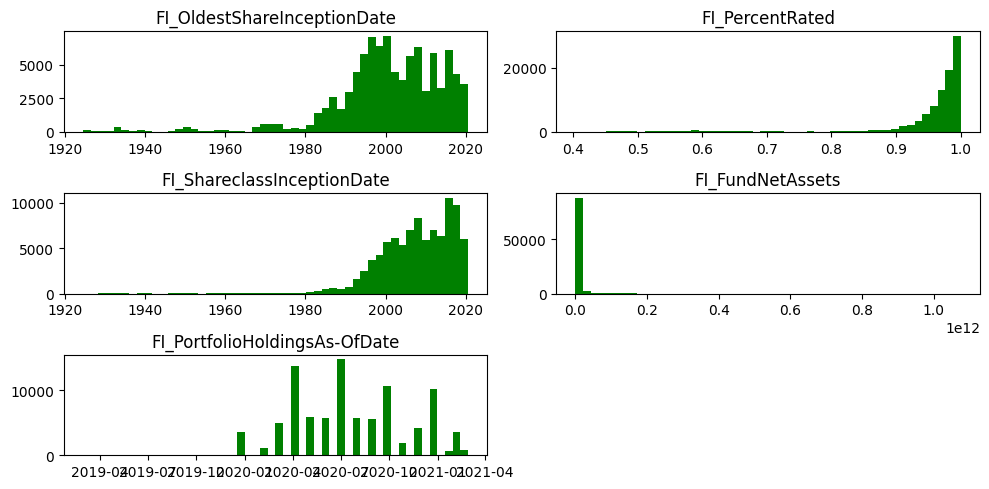

Histogram for Financial performance features


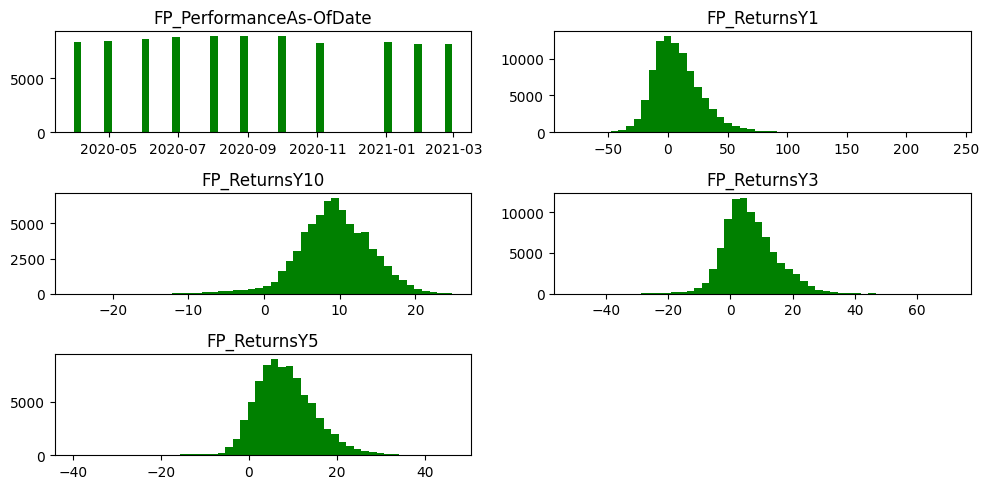

Histogram for Fossil energy features


KeyboardInterrupt: 

In [41]:
categories=cols_df['Category'].unique()

for category in categories:
    #index_cols=list(set(cols_df[cols_df['Category']==category]['Short column name']) & set(df.columns))
    index_cols=getColCategory(category)
    length=len(df[index_cols].select_dtypes(exclude=object).columns)
    print("Histogram for "+category+" features")
    df[index_cols].hist(color='g', bins=50, grid=False, figsize=(length*2,length))
    plt.tight_layout()
    plt.show()

#### 2.b.2 Continuous features encoding exploration
* We try different types of features encoding here
* Based on our observations, we see that
    * *weight* sub-features require $\exp^{1/2}$ transformation
    * *asset* sub-features require $\log(x+1)$ transformation
    * *Financial performance* features do not require transformation as they natively display a bell curve shape

In [42]:
# (C) Preprocessing function
def df_wo_zeros_null(df):
    df = df.copy()

    # Continuous
    # Add additional column for holding 0 values
    # Filter-out zero values
    for c in list(continuous_zeros)+list(discrete_zeros):
        name = c + "_isempty"
        idx= df[c]==0
        df[name] = idx
        #Convert bool col as int
        df[name] = df[name].astype(int)
        df[c] = df[~idx][c]

    # Fill missing values
    for c in list(set(continuous + discrete) & set(df.select_dtypes(np.number).columns)):
        df[c].dropna(inplace=True)

    return df

<ipython-input-42-08b95c6bc885>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = idx
<ipython-input-42-08b95c6bc885>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = idx
<ipython-input-42-08b95c6bc885>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = idx
<ipython-i

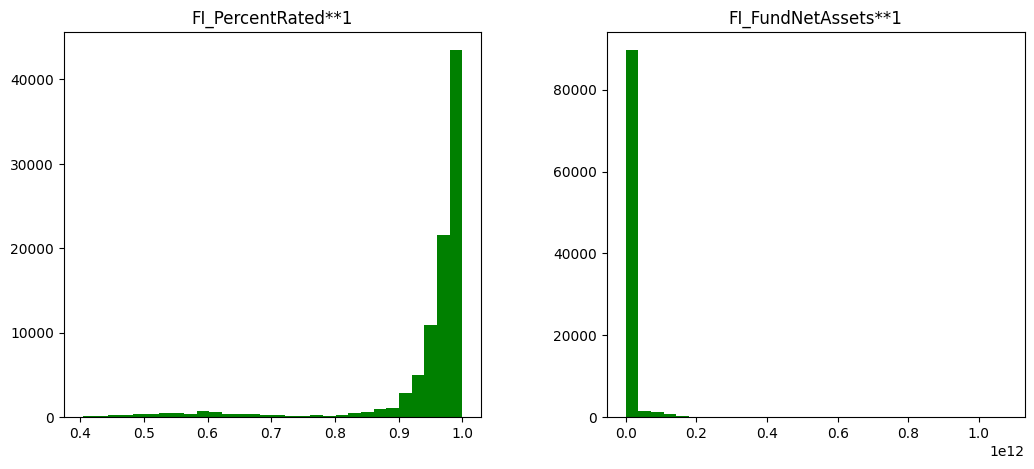

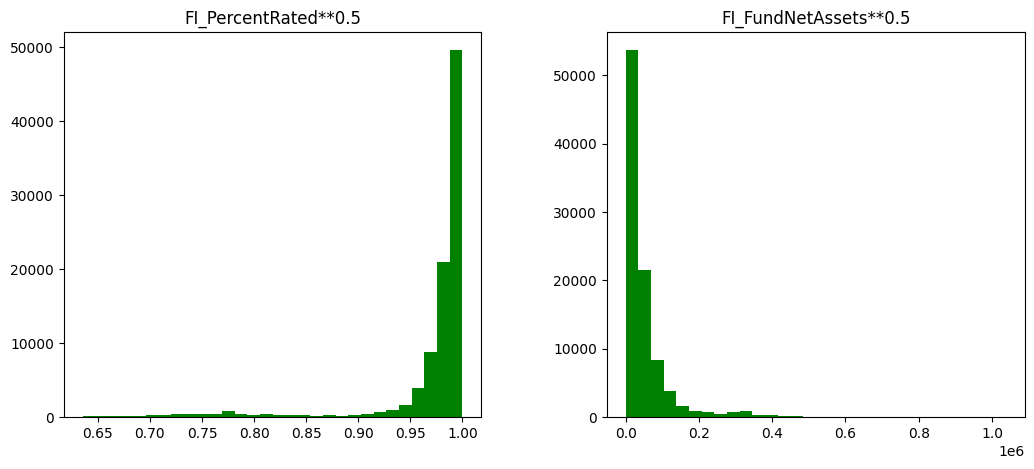

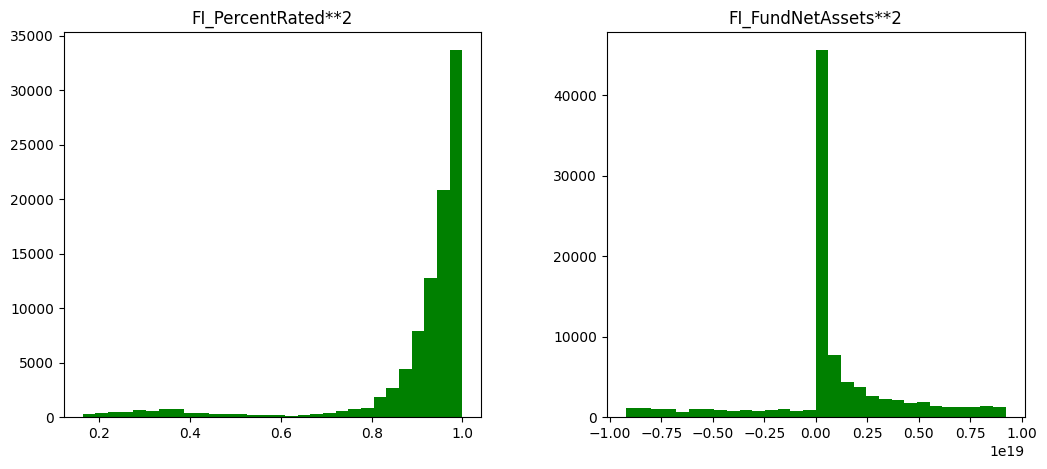

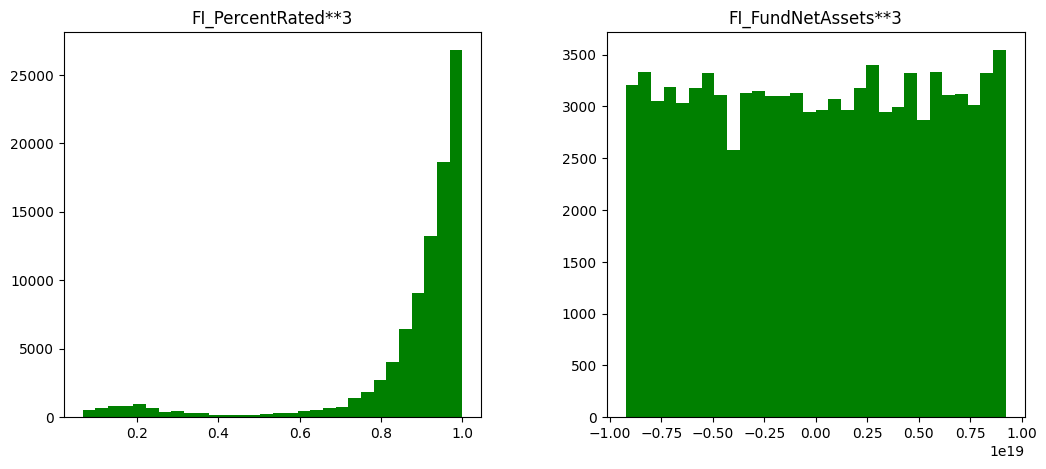

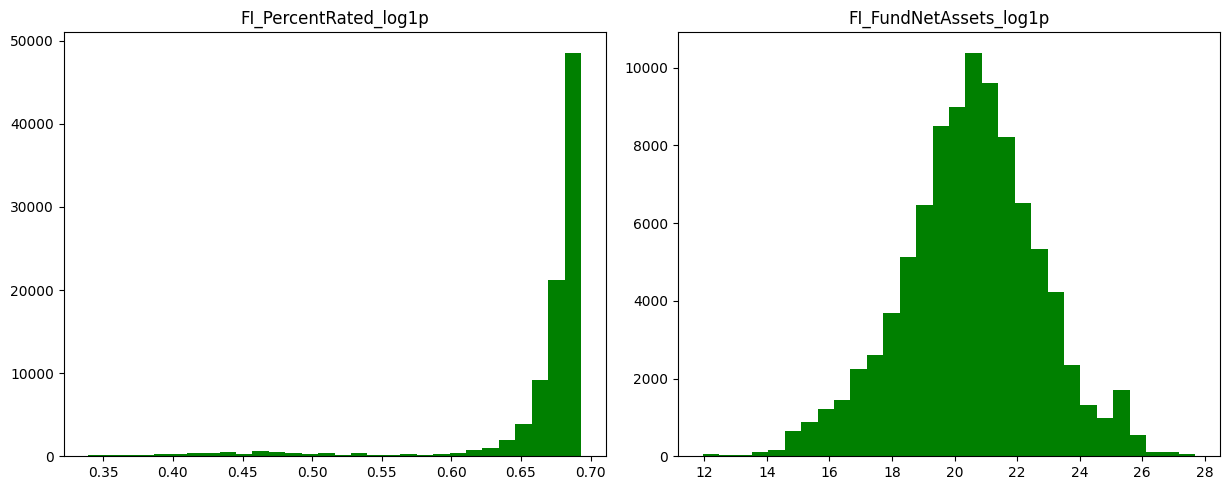

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


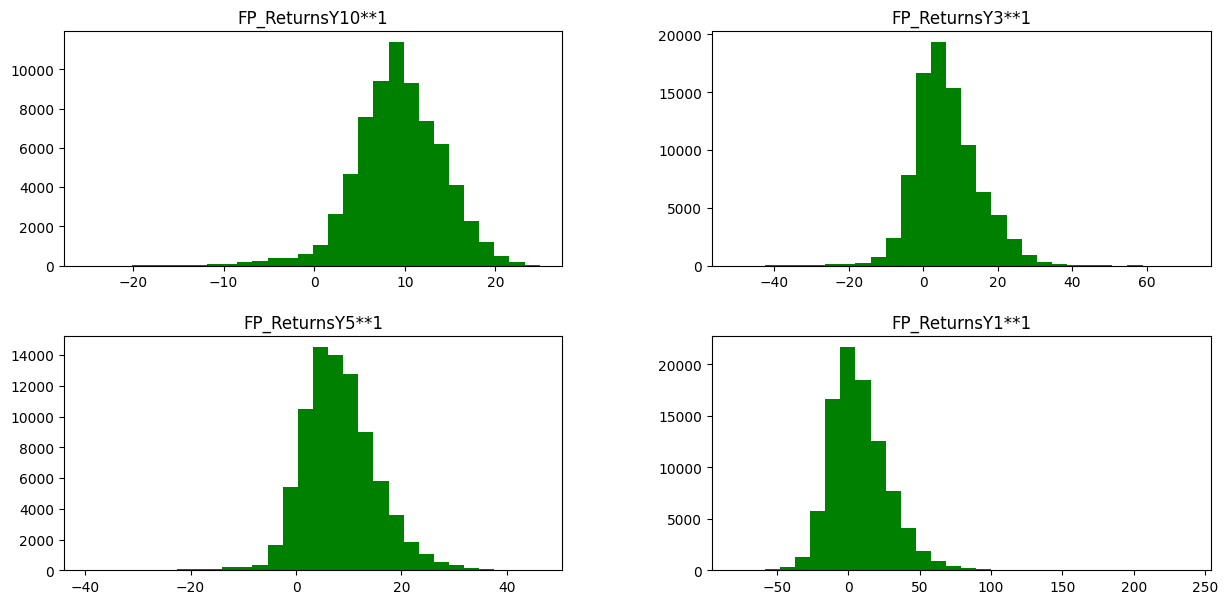

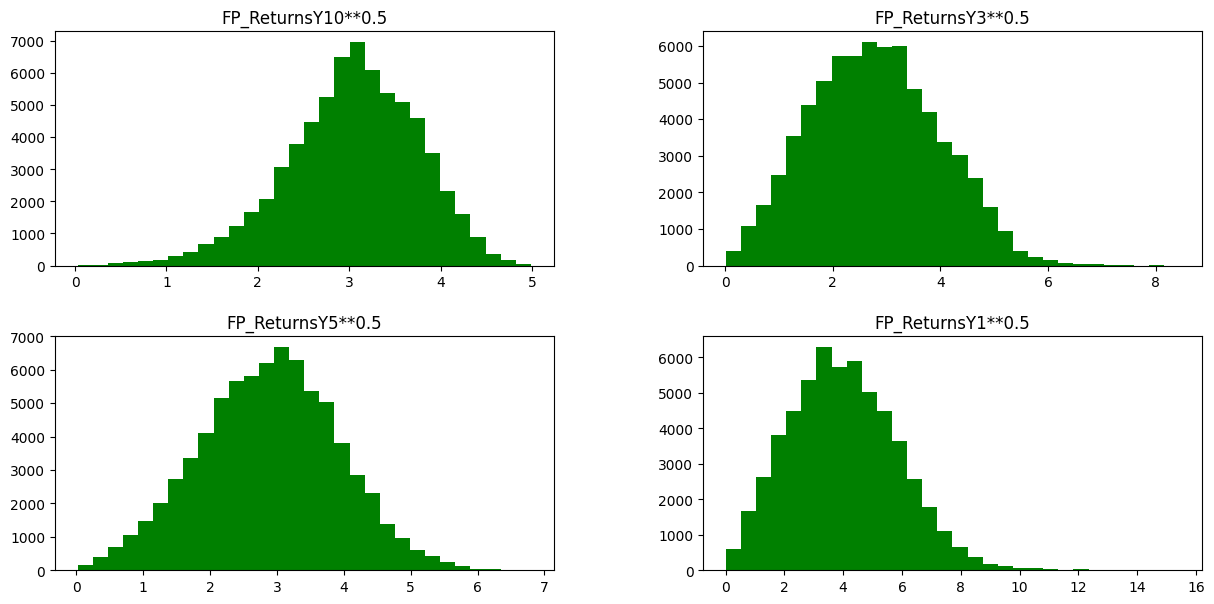

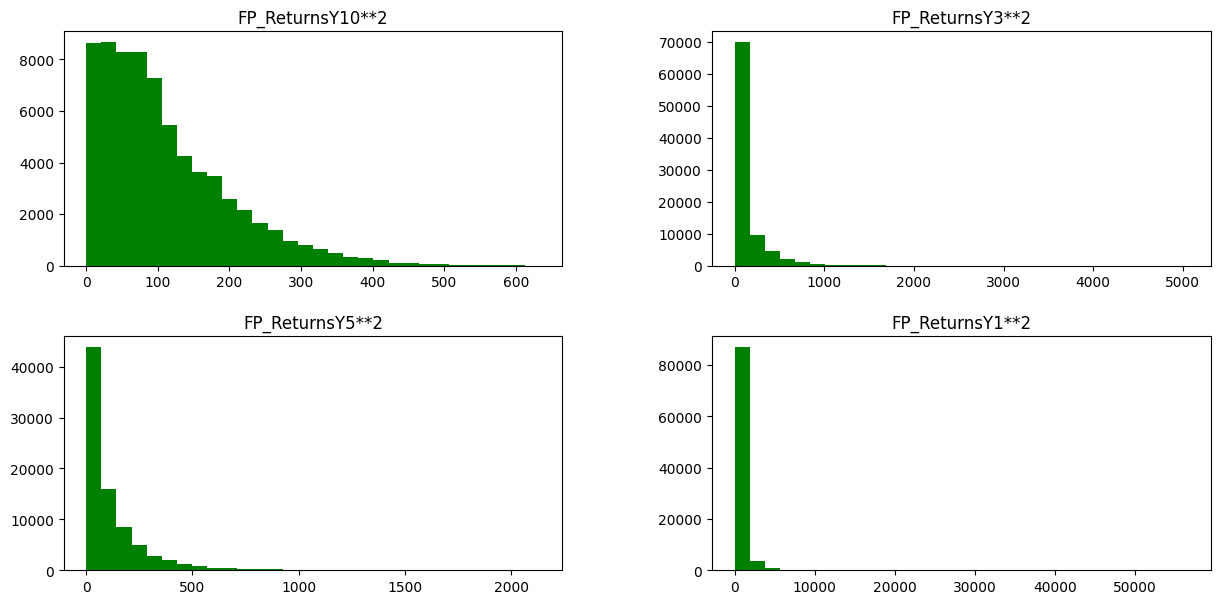

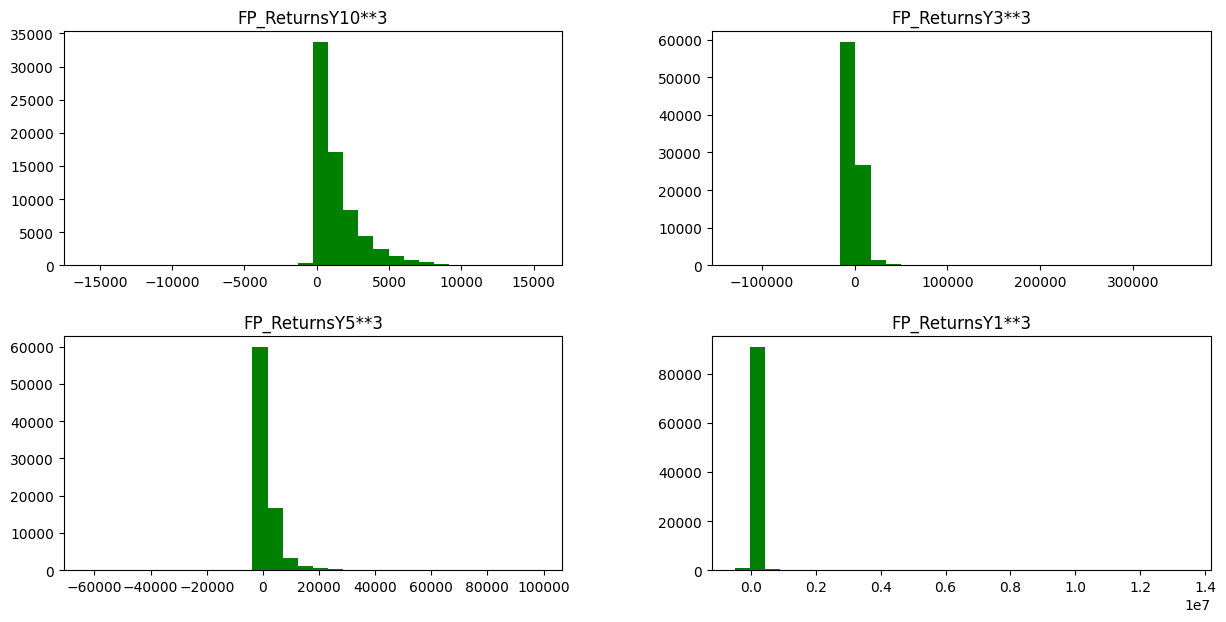

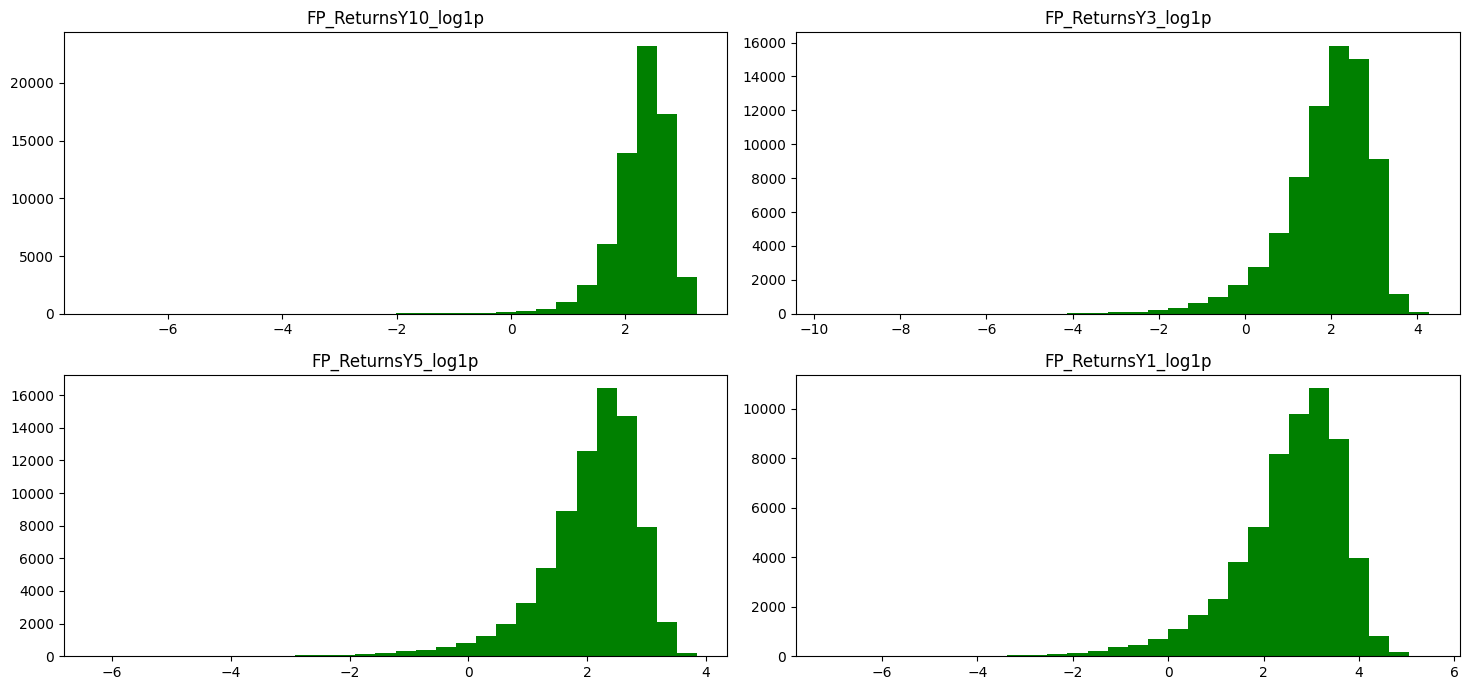

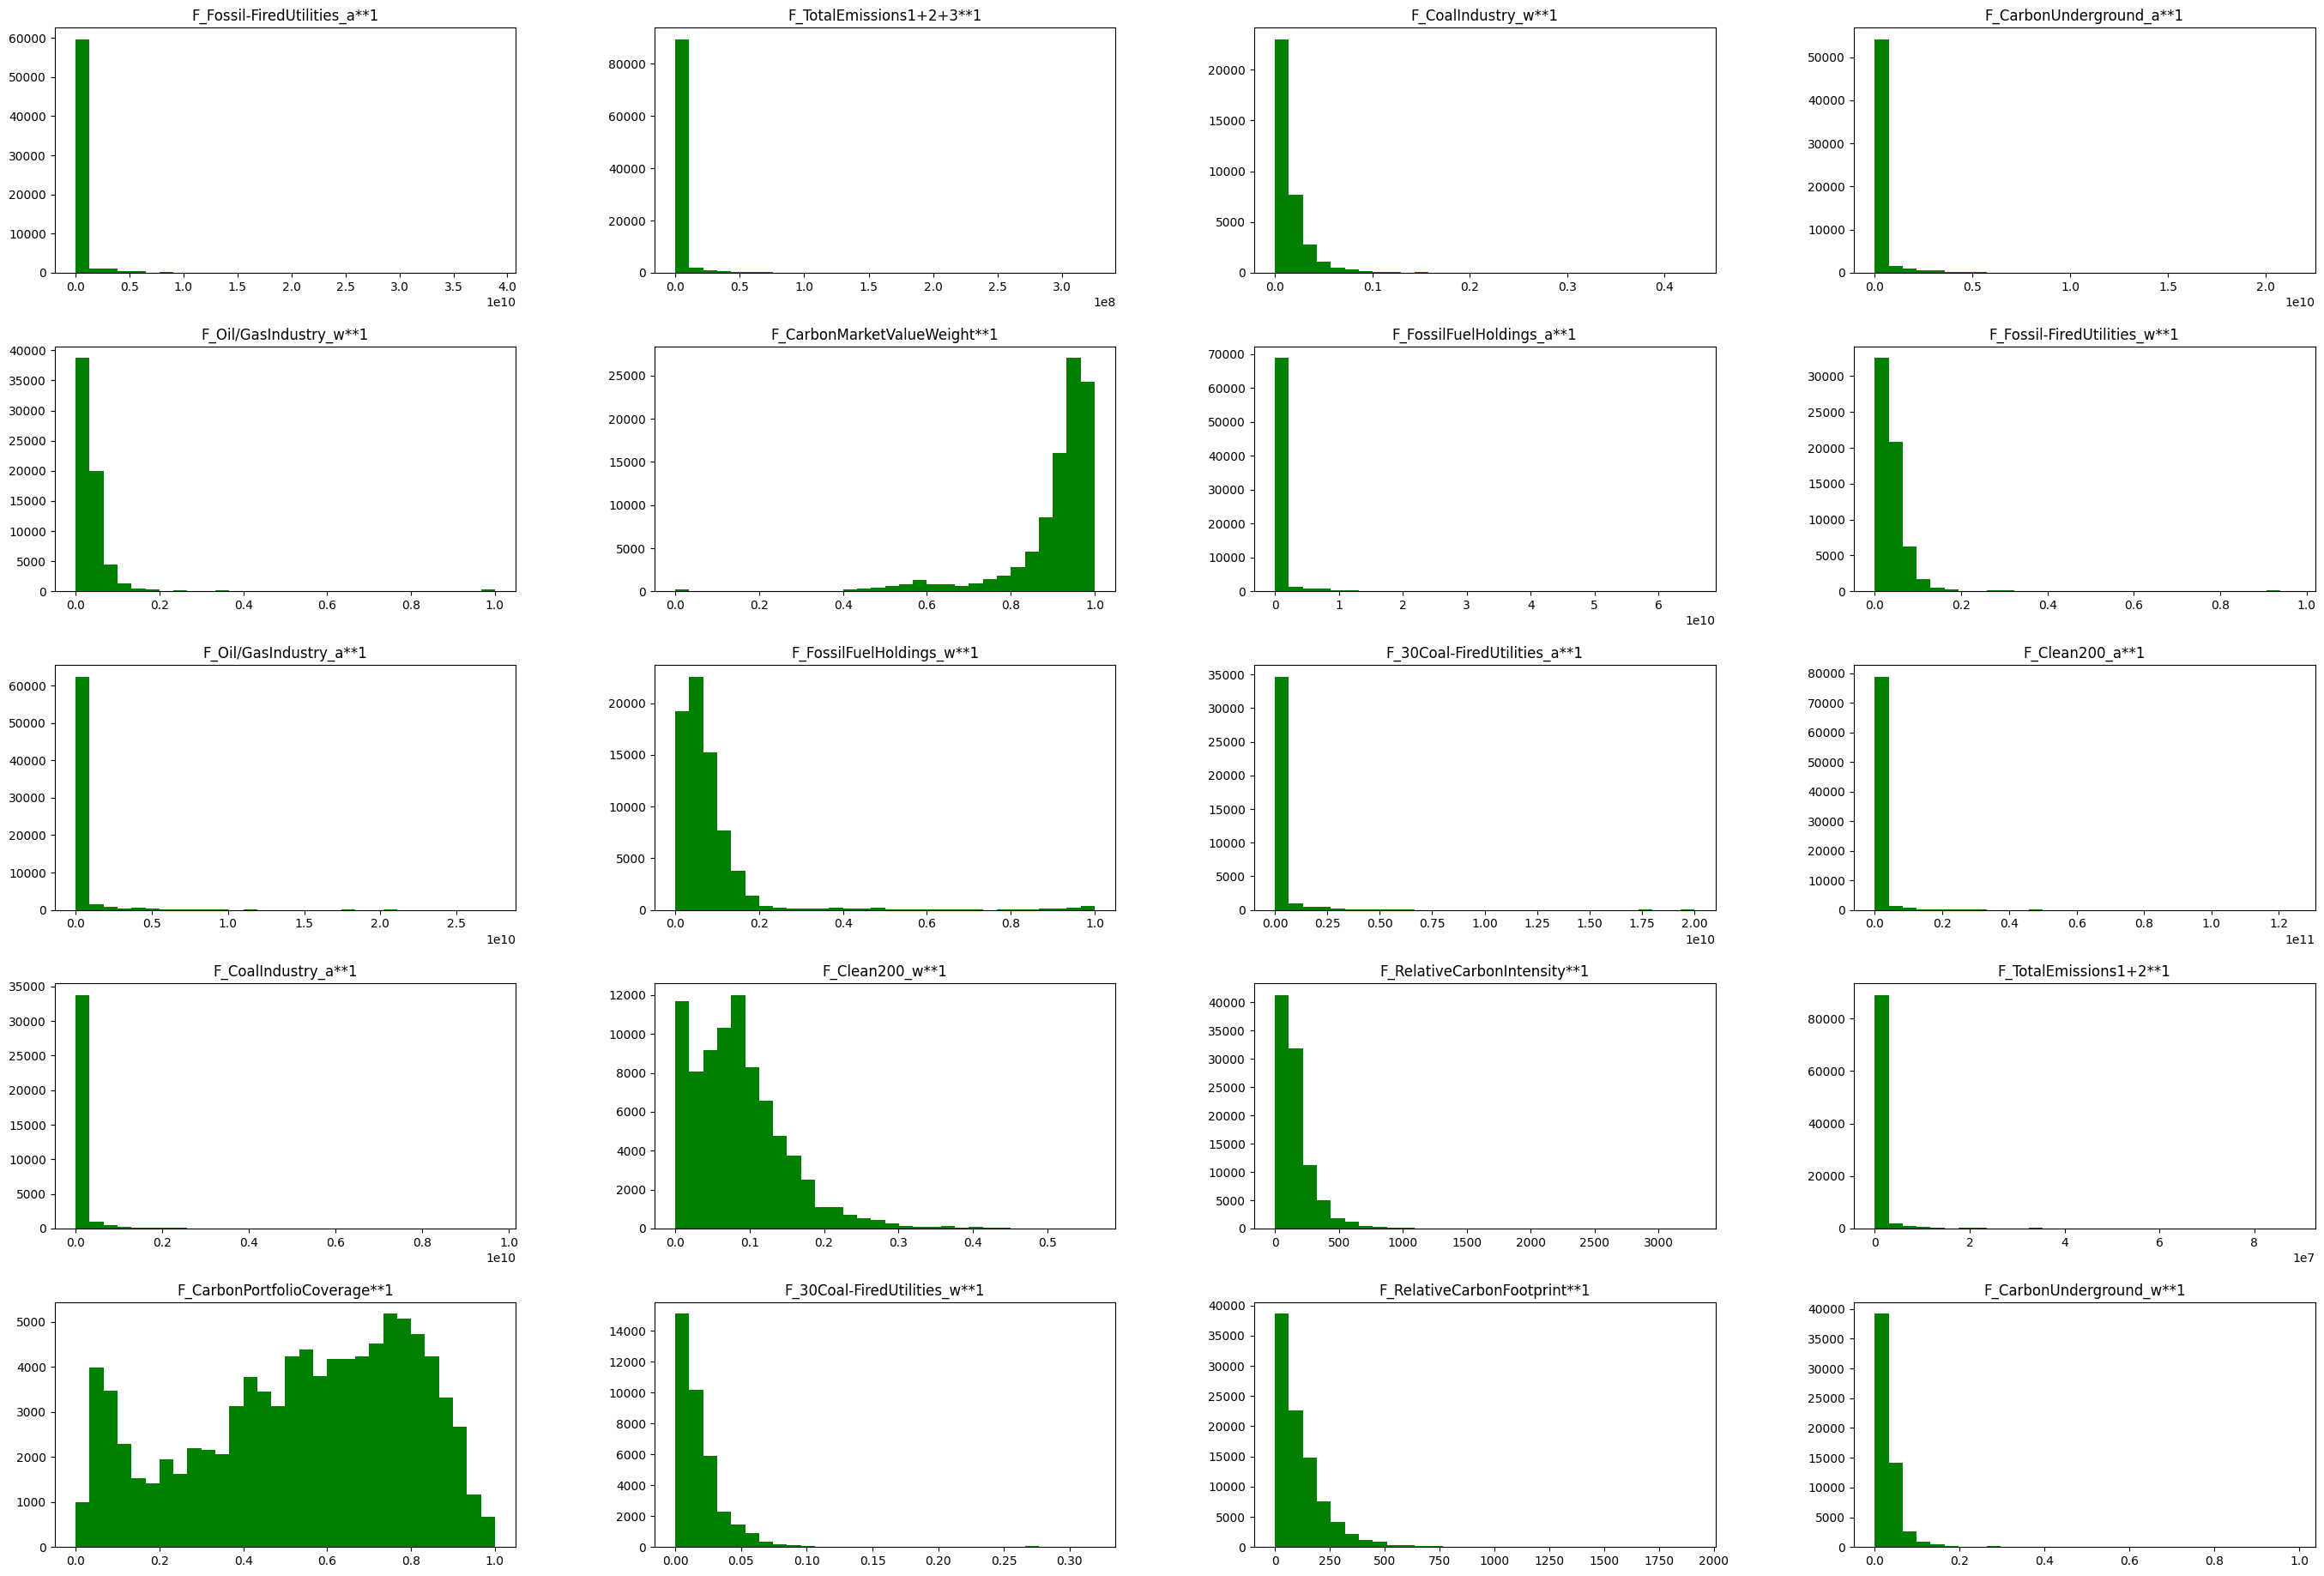

KeyboardInterrupt: 

In [43]:
from sklearn.preprocessing import QuantileTransformer

#continuous+discrete
cols= list(set(continuous) & set(df.select_dtypes(np.number).columns))
temp_df=df_wo_zeros_null(df)
for category in categories:
    #index_cols=list(set(cols_df[cols_df['Category']==category]['Short column name']) & set(df.columns))
    index_cols=list( set(getColCategory(category)) & set(cols))
    length=len(index_cols)
    for d in [1, 0.5, 2, 3]:
        test_df=temp_df[index_cols].copy()
        for c in test_df.columns:
            name = '{}**{}'.format(c, d)
            test_df[name]=test_df[c]**d
            test_df.drop(c, axis=1, inplace=True)
        test_df.hist(color='g', bins=30, grid=False, figsize=((length*1.2)+10,length+3))
        #test_df[test_df>0].hist(color='g', bins=30, grid=False, figsize=(length*2,length))

    #quantile = QuantileTransformer(output_distribution='normal')
    #test_df=df[index_cols]
    #test_df[index_cols]=quantile.fit_transform(test_df[index_cols])
    #test_df.hist(color='g', bins=30, grid=False, figsize=((length*1.2)+10,length+3))

    #log1p
    if(category != 'Gender Equality'):
        test_df=np.log1p(df[index_cols].copy())
        test_df.columns = [str(col) + '_log1p' for col in test_df.columns]
        test_df.hist(color='g', bins=30, grid=False, figsize=((length*1.2)+10,length+3))
    plt.tight_layout()
    plt.show()

* Special feature distribution handling

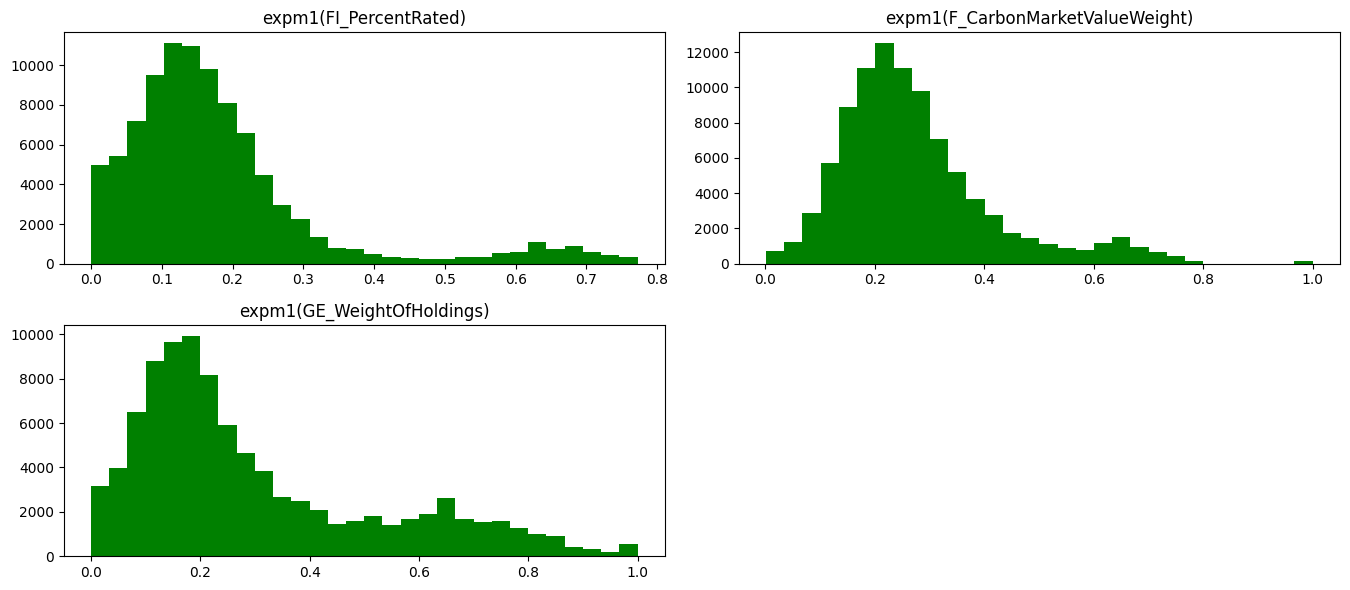

In [44]:
from scipy.stats import boxcox
special_distrib=['FI_PercentRated','F_CarbonMarketValueWeight','GE_WeightOfHoldings']
length=len(special_distrib)
test_df=df[special_distrib].copy()
for feature in special_distrib:
    name = 'expm1({})'.format(feature)
    test_df[name]=(1-test_df[feature])**0.5

    #test_df[name]=boxcox(test_df[feature], 0.3)
    test_df.drop(feature, axis=1, inplace=True)
test_df.hist(color='g', bins=30, grid=False, figsize=((length*1.2)+10,length+3))
plt.tight_layout()
plt.show()

#### 2.b.2 Best encoding assessment
* We pre-process slightly the features here (remove 0-values and replace null values by the median) and encode the features according to our findings
* We can verify gaussian distribution across all our numerical features

<ipython-input-42-08b95c6bc885>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = idx
<ipython-input-42-08b95c6bc885>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = idx
<ipython-input-42-08b95c6bc885>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = idx
<ipython-i

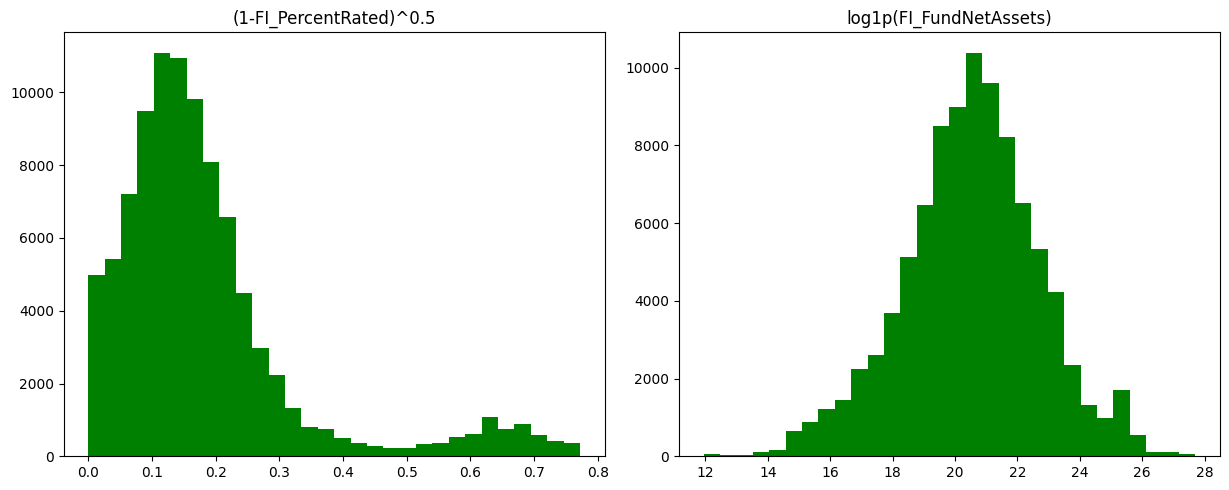

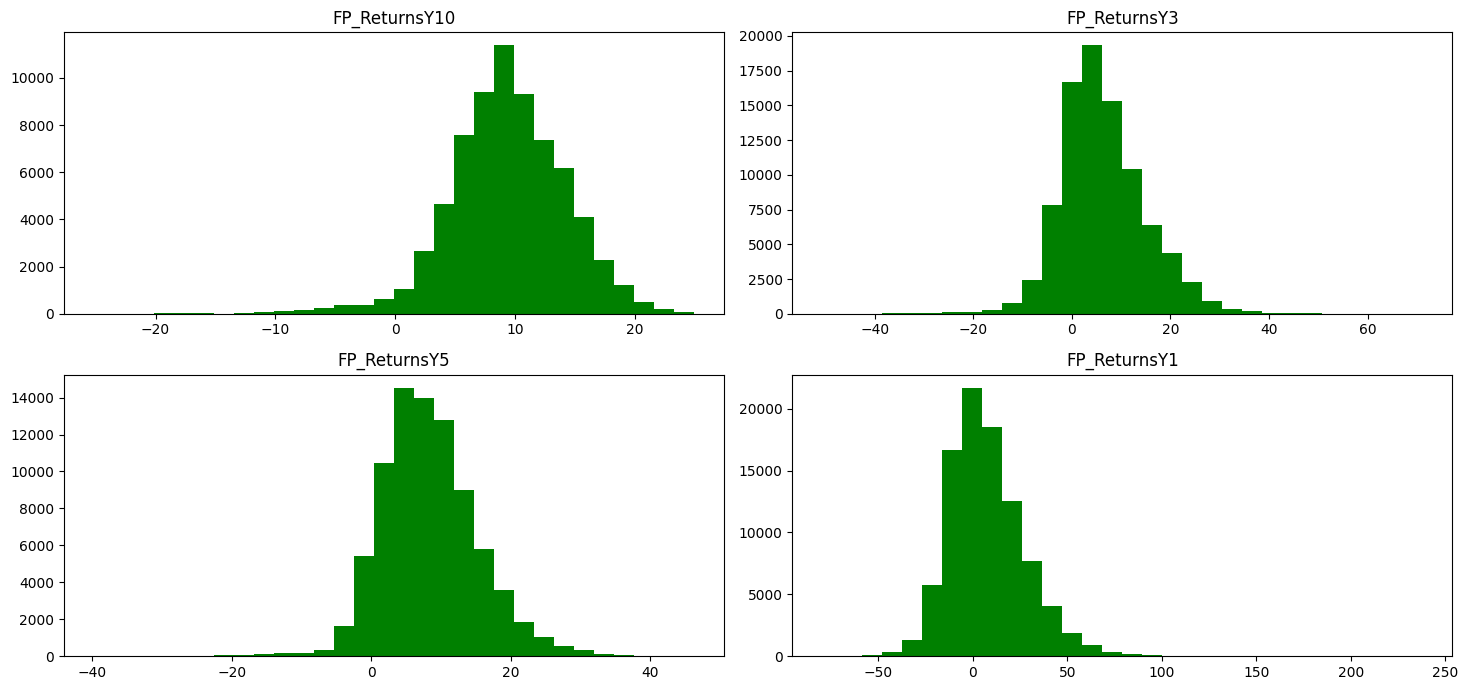

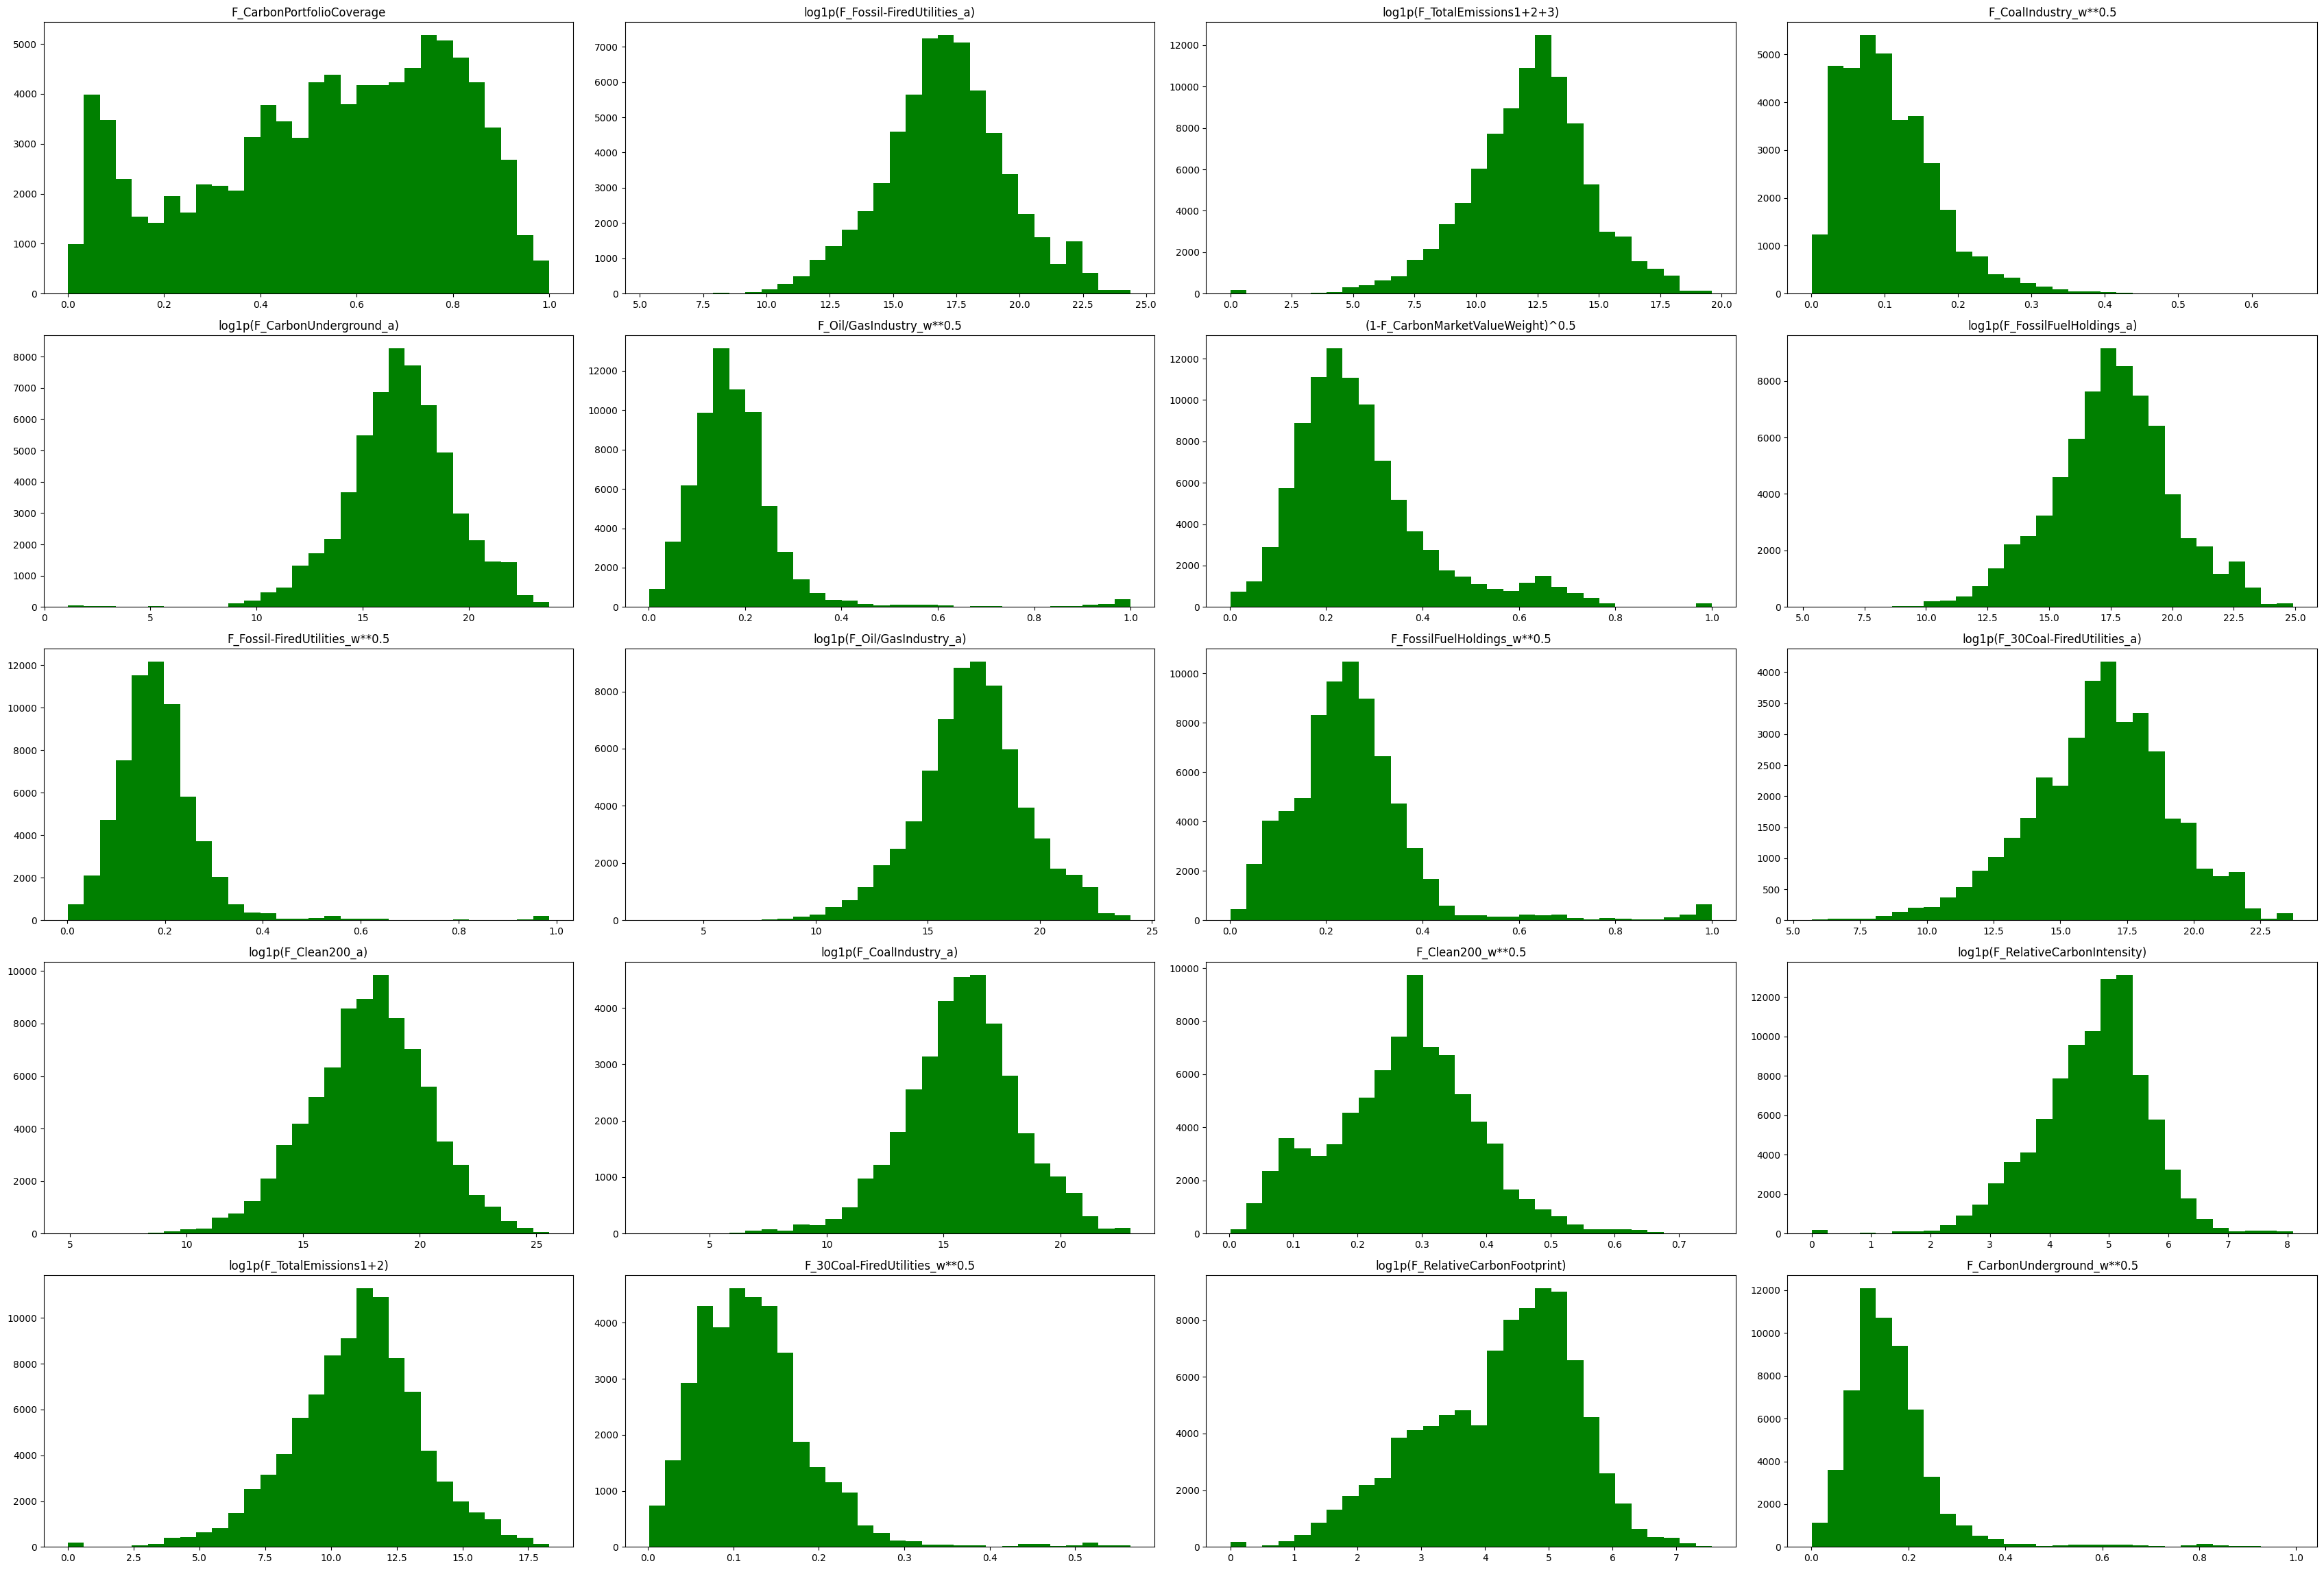

KeyboardInterrupt: 

In [45]:
cols= list(set(continuous) & set(df.select_dtypes(np.number).columns))
preprocess_df=df_wo_zeros_null(df)
continuous_log1p=[]
continuous_exp05=[]
continuous_exp1_05=[]

for category in categories:
    #index_cols=list(set(cols_df[cols_df['Category']==category]['Short column name']) & set(df.columns))
    index_cols=list( set(getColCategory(category)) & set(cols))
    length=len(index_cols)
    test_df=preprocess_df[index_cols].copy()
    for c in test_df.columns:
        encoding=getEncoding(c)
        if(encoding == "log1p"):
            name = 'log1p({})'.format(c)
            test_df[name]=np.log1p(test_df[c])
            test_df.drop(c, axis=1, inplace=True)
            continuous_log1p.append(c)
        elif (encoding == "^0.5"):
            name = '{}**{}'.format(c, '0.5')
            test_df[name]=test_df[c]**0.5
            test_df.drop(c, axis=1, inplace=True)
            continuous_exp05.append(c)
        elif (encoding == "(1-x)^0.5"):
            name = '(1-{})^0.5'.format(c)
            test_df[name]=(1-test_df[c])**0.5
            test_df.drop(c, axis=1, inplace=True)
            continuous_exp1_05.append(c)

    test_df.hist(color='g', bins=30, grid=False, figsize=((length*1.2)+10,length+3))
    plt.tight_layout()
    plt.show()

#### 2.b.3 Pre-processing numerical features

In [46]:
outliers_threshold=3

# (C) Preprocessing function
def preprocess_numerical(df):
    df = df.copy()

    # Continuous
    # Add additional column for holding 0 values
    # Filter-out zero values
    for c in list(continuous_zeros)+list(discrete_zeros):
        name = c + "_isempty"
        idx= df[c]==0
        df[name] = idx
        #Convert bool col as int
        df[name] = df[name].astype(int)
        df[c] = df[~idx][c]


    # Apply feature encoding
    df[continuous_log1p]=np.log1p(df[continuous_log1p])
    df[continuous_exp05]=df[continuous_exp05]**0.5
    df[continuous_exp1_05]=(1-df[continuous_exp1_05])**0.5

    # Apply z-scores for data with outliers
    for c in continuous:
        z_scores = (df[c] - df[c].mean()) / df[c].std()
        idx = (np.abs(z_scores) > outliers_threshold)
        df[c] = df[~idx][c]

    # Fill missing values
    for c in list(set(continuous + discrete) & set(df.select_dtypes(np.number).columns)):
        df[c].fillna(df[c].median(), inplace=True)

    #Replace dates
    for date_col in date_cols:
        df[date_col]=pd.to_numeric(df[date_col].apply(pd.to_datetime, errors='coerce'))

    return df

preprocess_df=preprocess_numerical(df)

<ipython-input-46-3348b39900e9>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = idx
<ipython-input-46-3348b39900e9>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = idx
<ipython-input-46-3348b39900e9>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = idx
<ipython-i

* Plot features to validate visualize the effectivness of our preprocessing method

Histogram for Fund information features


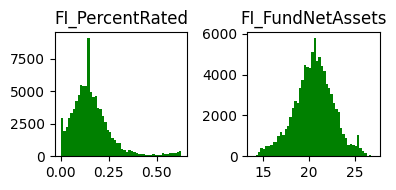

Histogram for Financial performance features


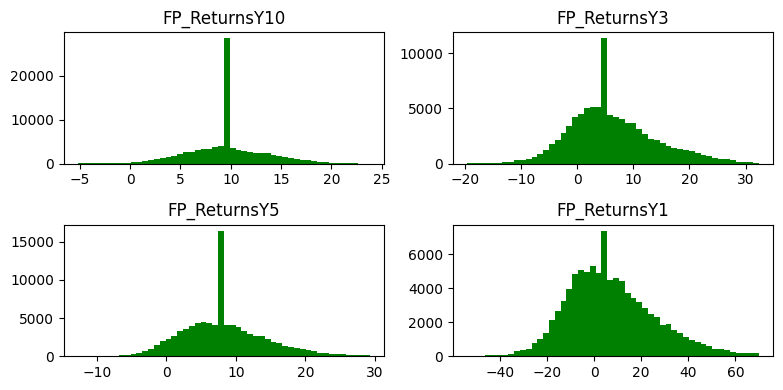

Histogram for Fossil energy features


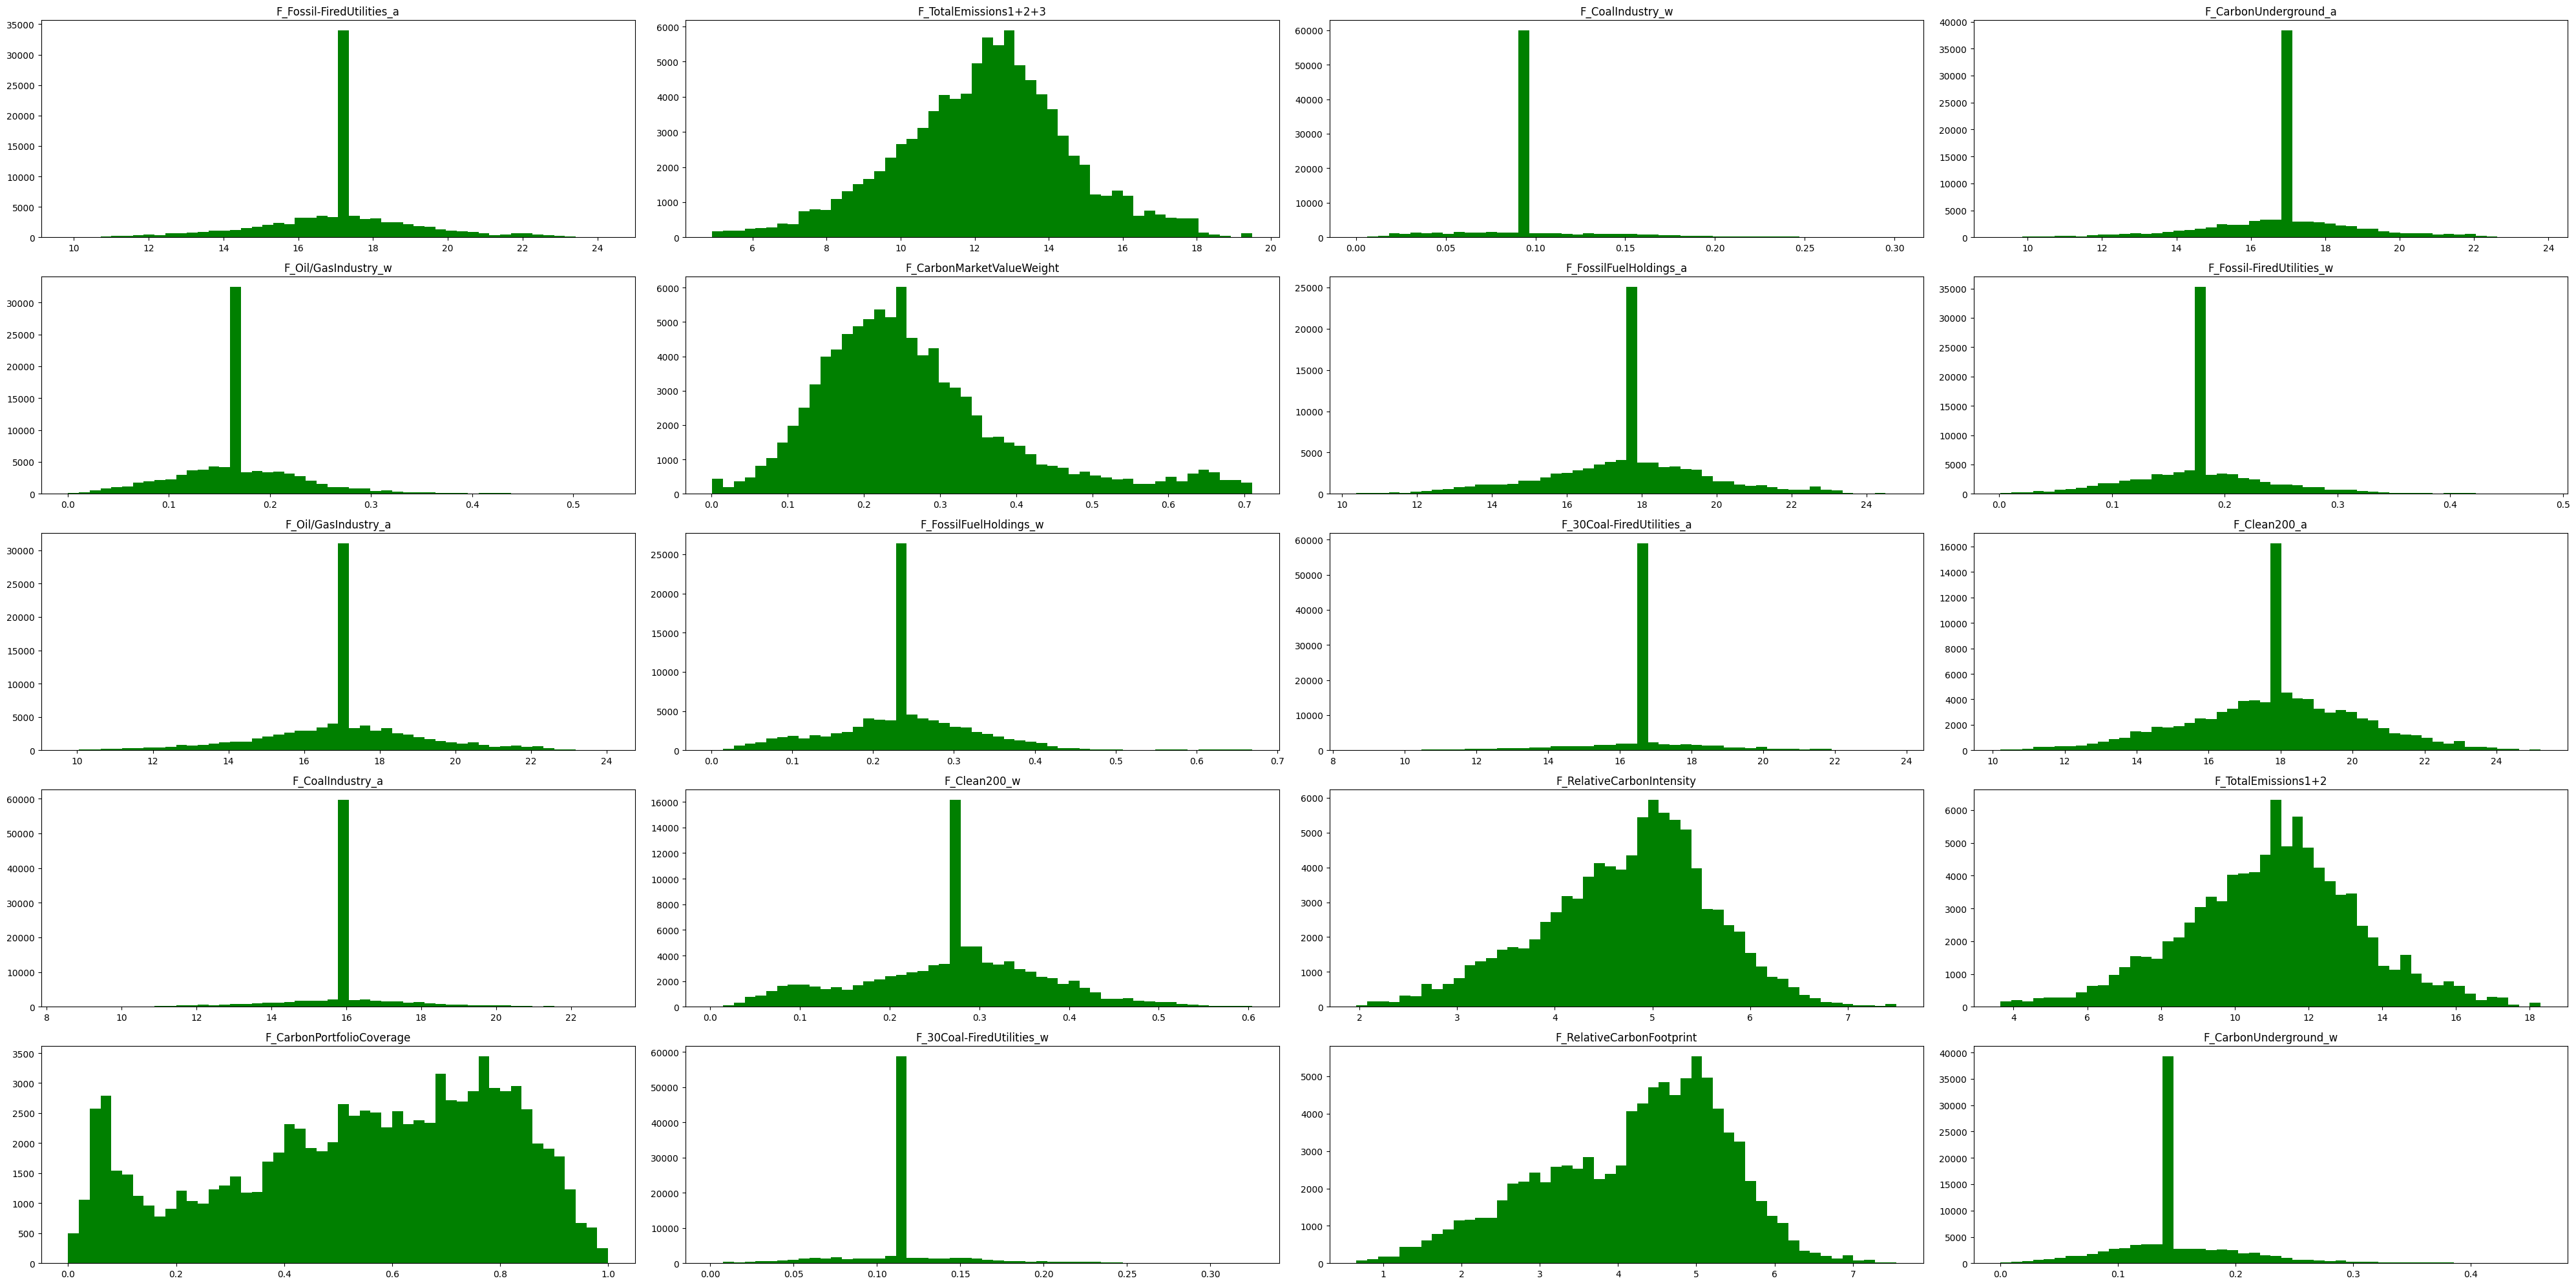

Histogram for Deforestation features


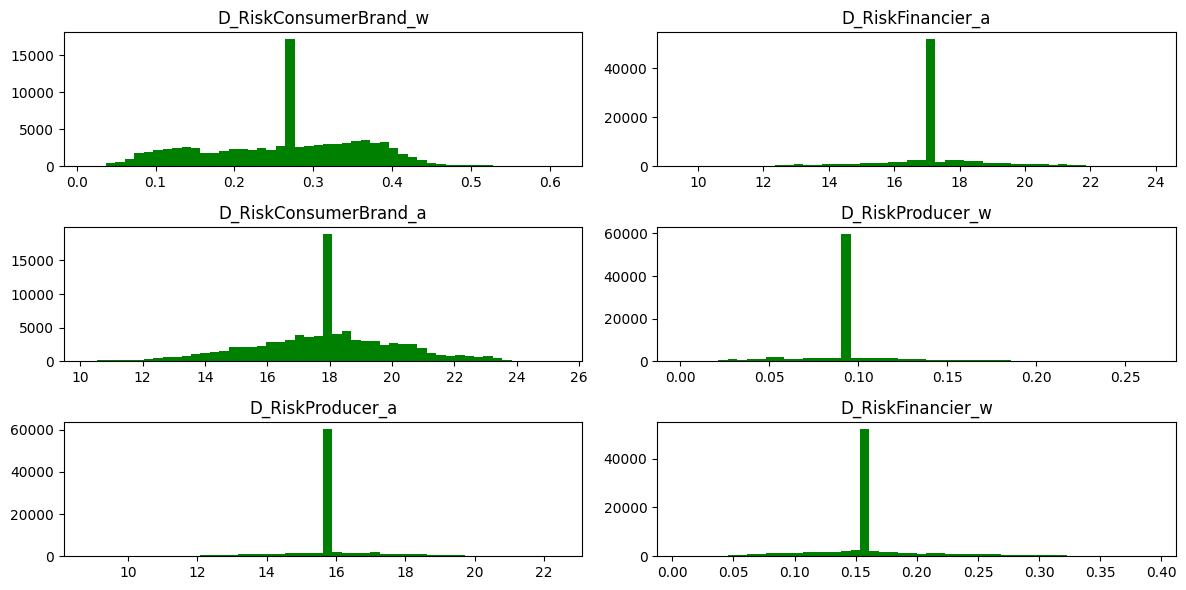

Histogram for Gender Equality features


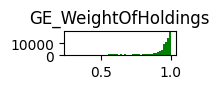

Histogram for Gun features


KeyboardInterrupt: 

In [47]:
cols= list(set(continuous) & set(df.select_dtypes(np.number).columns))

for category in categories:
    index_cols=list( set(getColCategory(category)) & set(cols))
    length=len(index_cols)
    print("Histogram for "+category+" features")
    preprocess_df[index_cols].hist(color='g', bins=50, grid=False, figsize=(length*2,length))
    plt.tight_layout()
    plt.show()

* Verify that we have no null values

In [48]:
print("We had", len(df.columns), "features before peprocessing numerical")
print("After processing, we have a total of", len(preprocess_df.columns), "features")
print("Number of null values in the dataframe:", preprocess_df[discrete+continuous].isnull().sum().sum())

We had 106 features before peprocessing numerical
After processing, we have a total of 184 features
Number of null values in the dataframe: 0


In [49]:
for c in preprocess_df.columns:
    print (c)

FI_ShareclassType
FI_ShareclassInceptionDate
FI_CategoryGroup
FI_OldestShareInceptionDate
FI_PortfolioHoldingsAs-OfDate
FI_FundNetAssets
FI_PercentRated
F_FossilFuelGrade
F_FossilFuelHoldings_c
F_FossilFuelHoldings_w
F_FossilFuelHoldings_a
F_CarbonUnderground_c
F_CarbonUnderground_w
F_CarbonUnderground_a
F_CoalIndustry_c
F_CoalIndustry_w
F_CoalIndustry_a
F_Oil/GasIndustry_c
F_Oil/GasIndustry_w
F_Oil/GasIndustry_a
F_30Coal-FiredUtilities_c
F_30Coal-FiredUtilities_w
F_30Coal-FiredUtilities_a
F_Fossil-FiredUtilities_c
F_Fossil-FiredUtilities_w
F_Fossil-FiredUtilities_a
F_RelativeCarbonFootprint
F_RelativeCarbonIntensity
F_TotalEmissions1+2
F_TotalEmissions1+2+3
F_CarbonMarketValueWeight
F_CarbonPortfolioCoverage
F_Clean200_c
F_Clean200_w
F_Clean200_a
D_DeforestationGrade
D_RiskProducer_c
D_RiskProducer_w
D_RiskProducer_a
D_RiskFinancier_c
D_RiskFinancier_w
D_RiskFinancier_a
D_RiskConsumerBrand_c
D_RiskConsumerBrand_w
D_RiskConsumerBrand_a
GE_GenderEqualityGrade
GE_GenderEqualityRanking
GE

#### 2.b.5 Pre-processing categorical
* One-hot encode categorical features, except for grade where ordinal encoding is used

In [50]:
def ordinal_mapping(df, cols, dictionary):
    for col in cols:
        df[col]=df[col].map(dictionary)
    return df

#grade_cols=df.filter(regex="Grade",axis=1).columns
#checkuniquevalues(df, grade_cols)

In [51]:
def preprocessing_categorical(df):
    df = df.copy()
    # convert ordinal to int columns
    ordinal_mapping(df, ordinal, {'A':6, 'B':5, 'C':4, 'D':3, 'E':2, 'F':1, np.nan:0})

    # One-hot encoding
    df = pd.get_dummies(df, columns=nominal, dummy_na=False)

    return df

preprocess_df=preprocessing_categorical(preprocess_df)

* Perform some check after the processing, we observed a large increase of new columns

In [52]:
print("After processing, we have a total of", len(preprocess_df.columns), "features")

After processing, we have a total of 188 features


In [53]:
def compareAfter_preprocess(df_origin, df_new):
    number_previous_col=0
    for col in df_new.columns:
        if(col in df_origin.columns ):
            if(not col in continuous):
                number_previous_col=number_previous_col+1
                if(len( list(set(df_new[col].unique()) -set(df_origin[col].unique()) )) >0):
                    print(col,"- difference of value mapping :",list(set(df_new[col].unique()) -set(df_origin[col].unique())))
        else:
            print(col,"- new column")

compareAfter_preprocess(df,preprocess_df)

FI_ShareclassInceptionDate - difference of value mapping : [1415750400000000000, 1325030400000000000, 721008000000000000, 736560000000000000, 1355184000000000000, 1216857600000000000, 1510704000000000000, 1481846400000000000, 1530057600000000000, 1548979200000000000, 1072742400000000000, 1128038400000000000, 641433600000000000, 1470873600000000000, 995328000000000000, 564019200000000000, 1313712000000000000, 1511136000000000000, 1538438400000000000, 1488758400000000000, 913680000000000000, 869443200000000000, 847324800000000000, 991094400000000000, 1024272000000000000, 1112745600000000000, 1544054400000000000, 1145923200000000000, 615081600000000000, 885254400000000000, 1593043200000000000, 728784000000000000, 1075334400000000000, 1274400000000000000, 1296518400000000000, 1451347200000000000, 1108512000000000000, 1506643200000000000, 1561939200000000000, 997920000000000000, 644025600000000000, 865209600000000000, 919900800000000000, 1253836800000000000, 1451260800000000000, 71720640000

#### 2.b.4 Remove highly correlated features
* The goal of this step is to identify and remove high correlated features (as we introduced many new features)

In [54]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_correlations(df, n=10):
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [55]:
correlation_threshold=0.95

for category in ['FI','FP','F','D','GE','G','W','T','P']:
    filter=preprocess_df.filter(regex=category+"_.*",axis=1).select_dtypes(np.number)
    if(len(filter.columns)>0):
        print("Top Absolute Correlations")
        tmp_corr=get_top_correlations(filter, 40)
        print(tmp_corr[tmp_corr >= correlation_threshold].sort_index())

Top Absolute Correlations
Series([], dtype: float64)
Top Absolute Correlations
Series([], dtype: float64)
Top Absolute Correlations
F_30Coal-FiredUtilities_a_isempty  F_30Coal-FiredUtilities_c_isempty    1.000000
                                   F_30Coal-FiredUtilities_w_isempty    1.000000
F_30Coal-FiredUtilities_w_isempty  F_30Coal-FiredUtilities_c_isempty    1.000000
F_CarbonUnderground_a_isempty      F_CarbonUnderground_c_isempty        1.000000
                                   F_CarbonUnderground_w_isempty        1.000000
F_CarbonUnderground_w_isempty      F_CarbonUnderground_c_isempty        1.000000
F_Clean200_a_isempty               F_Clean200_c_isempty                 1.000000
                                   F_Clean200_w_isempty                 1.000000
F_Clean200_w_isempty               F_Clean200_c_isempty                 1.000000
F_CoalIndustry_a_isempty           F_CoalIndustry_c_isempty             1.000000
F_CoalIndustry_w_isempty           F_CoalIndustry_a_isempt

In [56]:
 def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    corr_results=[]

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
                    corr_results.append({
                        'Deleted column': colname,
                        'Correlation column': corr_matrix.columns[j],
                        'Correlation': corr_matrix.iloc[i, j]
                    })

    return pd.DataFrame(corr_results)

corr_results=correlation(preprocess_df, correlation_threshold)
pd.set_option('display.max_rows', None)
corr_results

Deleted column                  Correlation column  \
0                  F_Oil/GasIndustry_c              F_FossilFuelHoldings_c   
1                F_TotalEmissions1+2+3                 F_TotalEmissions1+2   
2                      G_GunRetailer_a                 G_CivilianFirearm_a   
3              W_MilitaryContractors_c                  W_MilitaryWeapon_c   
4              W_MilitaryContractors_w                  W_MilitaryWeapon_w   
5              W_MilitaryContractors_a                  W_MilitaryWeapon_a   
6                   P_BorderIndustry_c                      P_AllFlagged_c   
7                   P_BorderIndustry_w                      P_AllFlagged_w   
8                   P_BorderIndustry_a                      P_AllFlagged_a   
9        T_Tobacco-Promoting_w_isempty       T_Tobacco-Promoting_a_isempty   
10         T_TobaccoProducer_w_isempty                      T_TobaccoGrade   
11        P_BorderIndustryHR_a_isempty        P_BorderIndustryHR_w_isempty   
12           D_RiskFinancier_a_isempty           D_RiskFinancier_w_isempty   
13         G_CivilianFirearm_w_isempty         G_CivilianFirearm_a_isempty   
14          W_NuclearWeapons_w_isempty          W_NuclearWeapons_a_isempty   
15         G_GunManufacturer_a_isempty         G_GunManufacturer_w_isempty   
16             G_GunRetailer_w_isempty             G_GunRetailer_a_isempty   
17     W_MilitaryContractors_w_isempty          W_MilitaryWeapon_w_isempty   
18         T_TobaccoProducer_a_isempty                      T_TobaccoGrade   
19   F_Fossil-FiredUtilities_w_isempty   F_Fossil-FiredUtilities_a_isempty   
20          P_BorderIndustry_w_isempty          P_BorderIndustry_a_isempty   
21            D_RiskProducer_w_isempty            D_RiskProducer_a_isempty   
22     W_MilitaryContractors_a_isempty          W_MilitaryWeapon_w_isempty   
23         F_Oil/GasIndustry_a_isempty         F_Oil/GasIndustry_w_isempty   
24          P_PrisonIndustry_w_isempty          P_PrisonIndustry_a_isempty   
25          W_MilitaryWeapon_a_isempty          W_MilitaryWeapon_w_isempty   
26      F_FossilFuelHoldings_w_isempty      F_FossilFuelHoldings_a_isempty   
27            F_CoalIndustry_a_isempty            F_CoalIndustry_w_isempty   
28                F_Clean200_w_isempty                F_Clean200_a_isempty   
29       D_RiskConsumerBrand_w_isempty       D_RiskConsumerBrand_a_isempty   
30        W_ClusterMunitions_a_isempty        W_ClusterMunitions_w_isempty   
31              P_AllFlagged_w_isempty              P_AllFlagged_a_isempty   
32            P_AllFlaggedHR_a_isempty            P_AllFlaggedHR_w_isempty   
33   F_30Coal-FiredUtilities_w_isempty   F_30Coal-FiredUtilities_a_isempty   
34  P_PrivatePrisonOperators_w_isempty  P_PrivatePrisonOperators_a_isempty   
35        P_PrisonIndustryHR_a_isempty        P_PrisonIndustryHR_w_isempty   
36       F_CarbonUnderground_w_isempty       F_CarbonUnderground_a_isempty   
37         T_TobaccoProducer_c_isempty                      T_TobaccoGrade   
38          P_PrisonIndustry_c_isempty          P_PrisonIndustry_a_isempty   
39              P_AllFlagged_c_isempty              P_AllFlagged_a_isempty   
40          P_BorderIndustry_c_isempty          P_BorderIndustry_a_isempty   
41          W_MilitaryWeapon_c_isempty          W_MilitaryWeapon_w_isempty   
42         G_CivilianFirearm_c_isempty         G_CivilianFirearm_a_isempty   
43       T_Tobacco-Promoting_c_isempty       T_Tobacco-Promoting_a_isempty   
44  P_PrivatePrisonOperators_c_isempty  P_PrivatePrisonOperators_a_isempty   
45      F_FossilFuelHoldings_c_isempty      F_FossilFuelHoldings_a_isempty   
46        W_ClusterMunitions_c_isempty        W_ClusterMunitions_w_isempty   
47   F_30Coal-FiredUtilities_c_isempty   F_30Coal-FiredUtilities_a_isempty   
48            P_AllFlaggedHR_c_isempty            P_AllFlaggedHR_w_isempty   
49        P_BorderIndustryHR_c_isempty        P_BorderIndustryHR_w_isempty   
50       F_CarbonUnderground_c_isempty       F

In [57]:
print("Remaining features",len(preprocess_df.columns))

Remaining features 125


In [58]:
preprocess_df.to_csv('/content/fossilfund_dataset_prep.csv', index=False)

### 2.b Plan to manage and process the data

#### Data cleaning and data manipulation
- [x] A row duplicate cleaning process needs to be performed
- [x] Features wit nearly empty fill-factor will be removed ('Fund profile: US-SIF member') as well as non-relevant/redundant categorical columns ('Fund profile: Ticker','Fund profile: Shareclass tickers')
- [x] Dates column need to be checked for consistency (within our analysis range) and integrity (no missing dates)
- [x] For the set of 'asset, count, weight' features, we need to ensure strong correlation between these variable and consistency  
    * If one of these variable equals zero (count or weight or asset = 0), we need to make sure that remaining 2 other variables should be 0

#### Feature engineering
- [x] Grades features will need to be encoded => ordinal encoding
* Pre-processing for numerical data:
    - [x] Null values will be replaced with median values
    - [x] Features with high number of 0-Values will be identified (new column _isempty will be added)
    - [x] Outliers will also need to be removed (e.g by deleting entries ranging +-10 std of the mean, assuming a gaussian distribution)
* Pre-processing for continuous data, it might be required to do a transformation (log, exp) to reduce the skewness
* Pre-processing for categorical data:
    - [x] We need to make sure date is encoded consistently, verify the number of unique values
    - [x] n/a values will be replaced with NoMapping value
    - [x] categorical data will be one-hot encoded

## 3) Exploratory data analysis (EDA)
### (a) Preliminary EDA


#### 3.a.1 Correlation of target with features
* The following plot also comparison between the performance target with other features. It shows that correlation of performance variables against other features are mostly on the blue zone (negative correlation)
* The most negative correlation is with Fosssil Fuel Holdings features

In [ ]:
fig = plt.figure(figsize=(25, 20))
sns.heatmap(preprocess_df.reindex(sorted(preprocess_df.columns), axis=1).corr(method='pearson'),
            cmap='RdBu_r',
            annot=False,
            linewidth=0.5)

*Additional information* :
* As suggested, the following clustermap allows to cluster correlated features together.
* We can observe several clusters with a mix of different features category
* *asset* and *count* type of features are clustered together: this is certainly due to the similar data distribution
* *weight* type of features do not show such clustering which might indicate more independances betweens these variables
* A possible result for these findings will be to group highly correlated features together
    * In the part 2, highly correlated features have been removed to overcome this situation


In [ ]:
sns.clustermap(preprocess_df.corr(method='pearson'), cmap='RdBu_r', figsize=(30, 30))

In [ ]:
sns.clustermap(preprocess_df.filter(regex=".*_a.*",axis=1).corr(method='pearson'), cmap='RdBu_r', figsize=(10, 10))

In [ ]:
sns.clustermap(preprocess_df.filter(regex=".*_c.*",axis=1).corr(method='pearson'), cmap='RdBu_r', figsize=(10, 10))

In [ ]:
sns.clustermap(preprocess_df.filter(regex=".*_w.*",axis=1).corr(method='pearson'), cmap='RdBu_r', figsize=(10, 10))

In [ ]:
sns.clustermap(preprocess_df.filter(regex=".*_isempty",axis=1).corr(method='pearson'), cmap='RdBu_r', figsize=(10, 10))

* Here are the top positive/negative correlations. Fossil Fuel holdings (weight) is the most correlated with our target

In [59]:
target = cols_df[ (cols_df['Category']=='Financial performance') & (cols_df['Type']=='Continuous') ]['Short column name']
correlations=preprocess_df.corr(method='pearson')[target]#.sort_values(ascending=False)
print('Top positive correlations with ReturnsY1')
correlations['FP_ReturnsY1'].sort_values(ascending=False)[0:15]

Top positive correlations with ReturnsY1


FP_ReturnsY1                          1.000000
FP_ReturnsY5                          0.808227
FP_ReturnsY3                          0.806222
FI_PortfolioHoldingsAs-OfDate         0.516813
FP_ReturnsY10                         0.499320
P_PrivatePrisonOperators_a_isempty    0.435946
P_PrisonIndustrialComplexGrade        0.405564
F_FossilFuelGrade                     0.378871
P_PrisonIndustryHR_w_isempty          0.367496
F_CarbonUnderground_a_isempty         0.288311
P_BorderIndustryHR_w_isempty          0.285739
P_PrisonIndustry_a_isempty            0.282405
F_Oil/GasIndustry_w_isempty           0.278394
P_AllFlaggedHR_w_isempty              0.274427
F_FossilFuelHoldings_a_isempty        0.262311
Name: FP_ReturnsY1, dtype: float64

In [60]:
print('Top negative correlations with ReturnsY1')
correlations['FP_ReturnsY1'].sort_values(ascending=False)[-5:]

Top negative correlations with ReturnsY1


F_CarbonUnderground_w       -0.217926
F_Oil/GasIndustry_w         -0.276647
F_FossilFuelHoldings_w      -0.313201
F_RelativeCarbonIntensity   -0.361362
F_RelativeCarbonFootprint   -0.421600
Name: FP_ReturnsY1, dtype: float64

In [61]:
correlations.filter(regex="FI_AssetManager.*",axis=0)['FP_ReturnsY1'].sort_values(ascending=False)

Series([], Name: FP_ReturnsY1, dtype: float64)

* To get even further, we compute pairplots between our target and features to observe these correlation further
    * Financial performance (Y3,Y5,Y10) features are strongly correlated
    * We observe the downward regression for F_FossilFuelHoldings_w
    * A lot of 0-values and outliers can be seen, this will need to be addressed
    * Sampling had to be used to reduce the plot time


Pairplots for FI numeric features - set 1/3


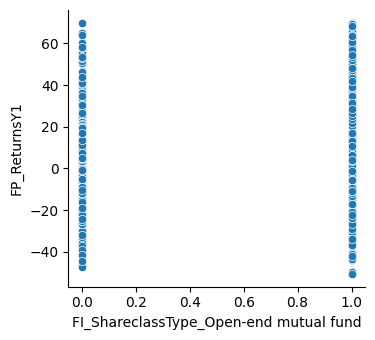

Pairplots for FI numeric features - set 2/3


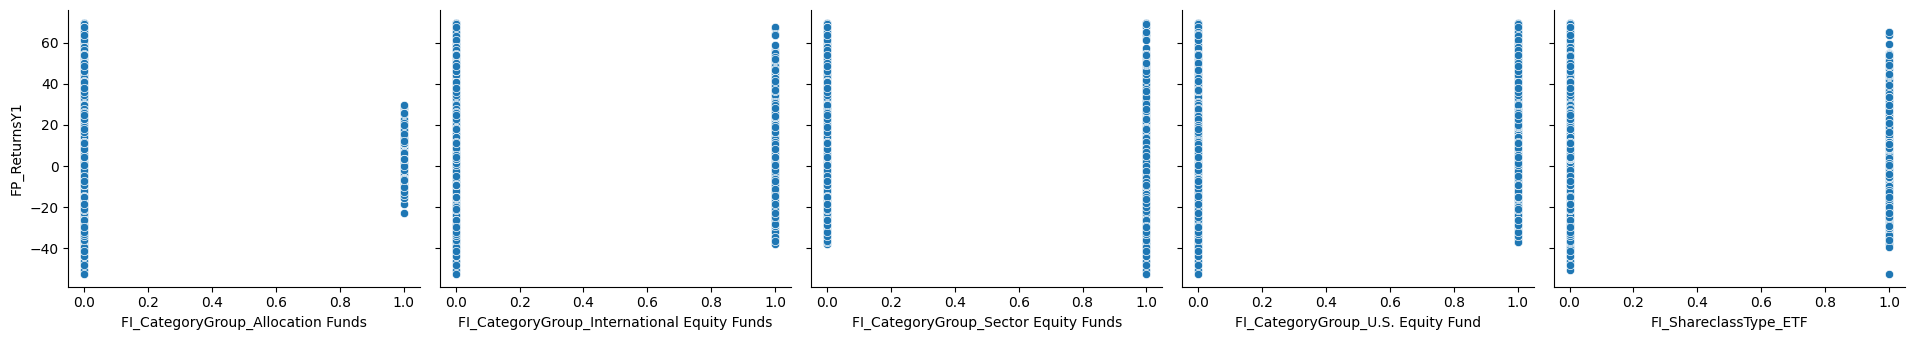

Pairplots for FI numeric features - set 3/3


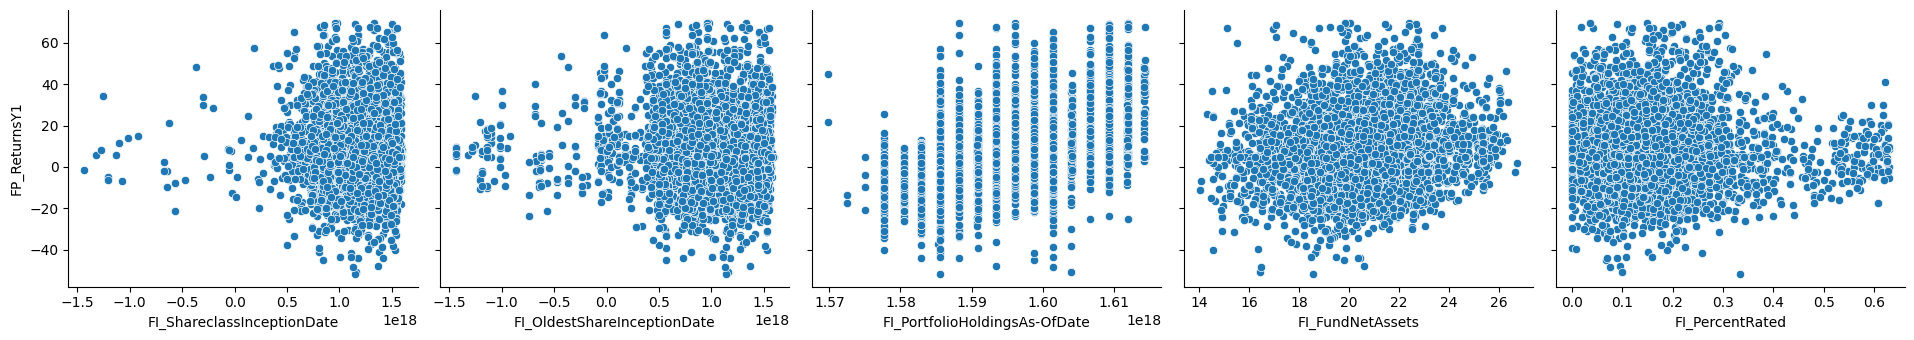

Pairplots for FP numeric features - set 1/1


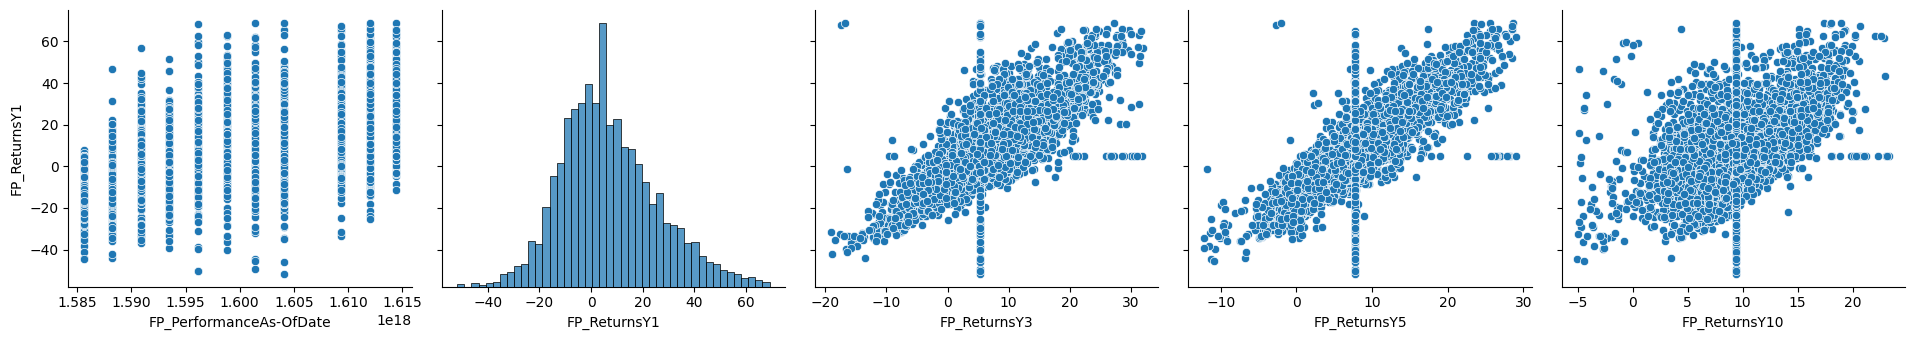

Pairplots for F numeric features - set 1/7


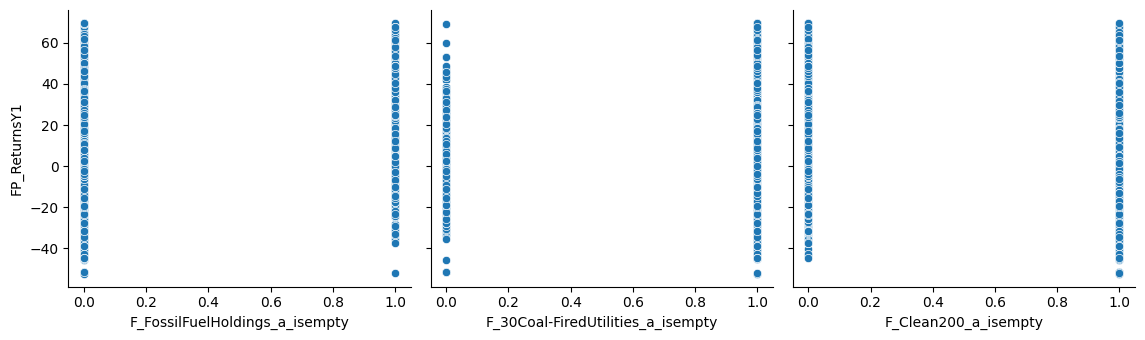

Pairplots for F numeric features - set 2/7


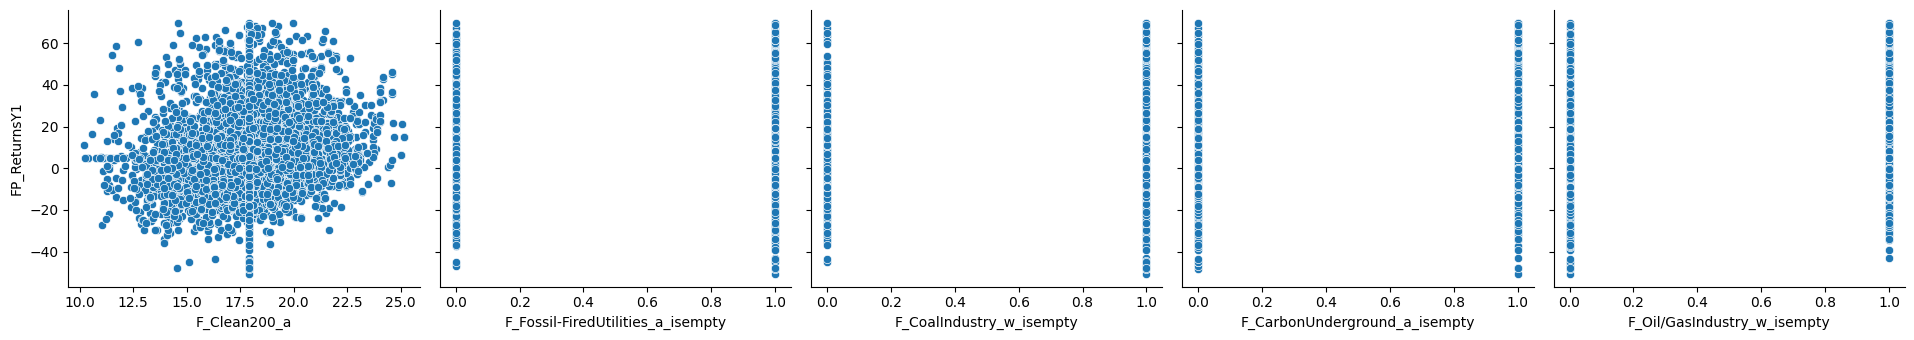

Pairplots for F numeric features - set 3/7


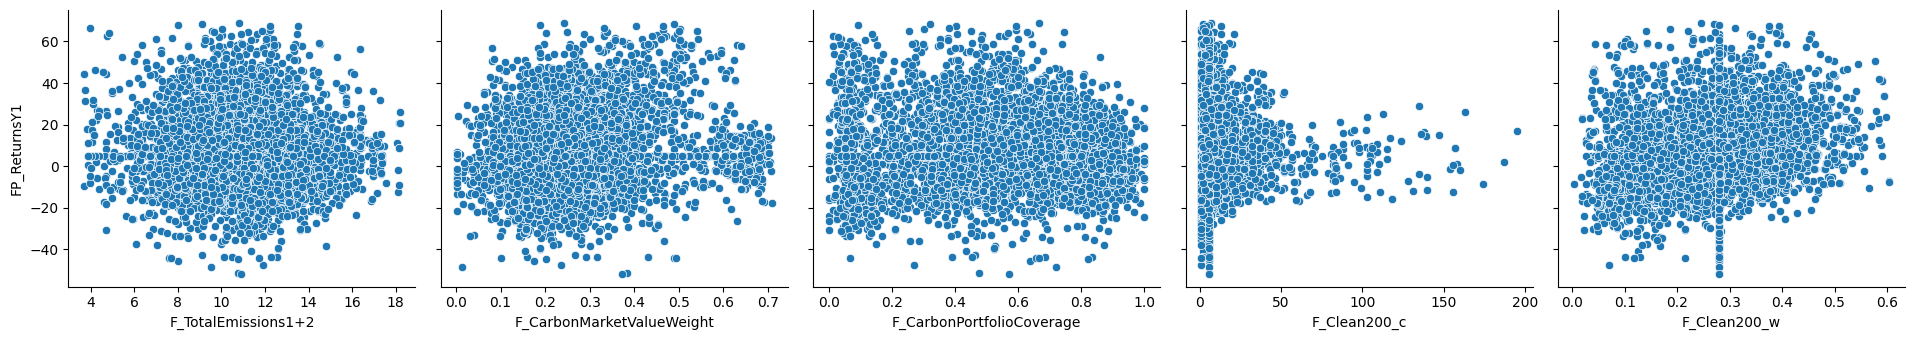

Pairplots for F numeric features - set 4/7


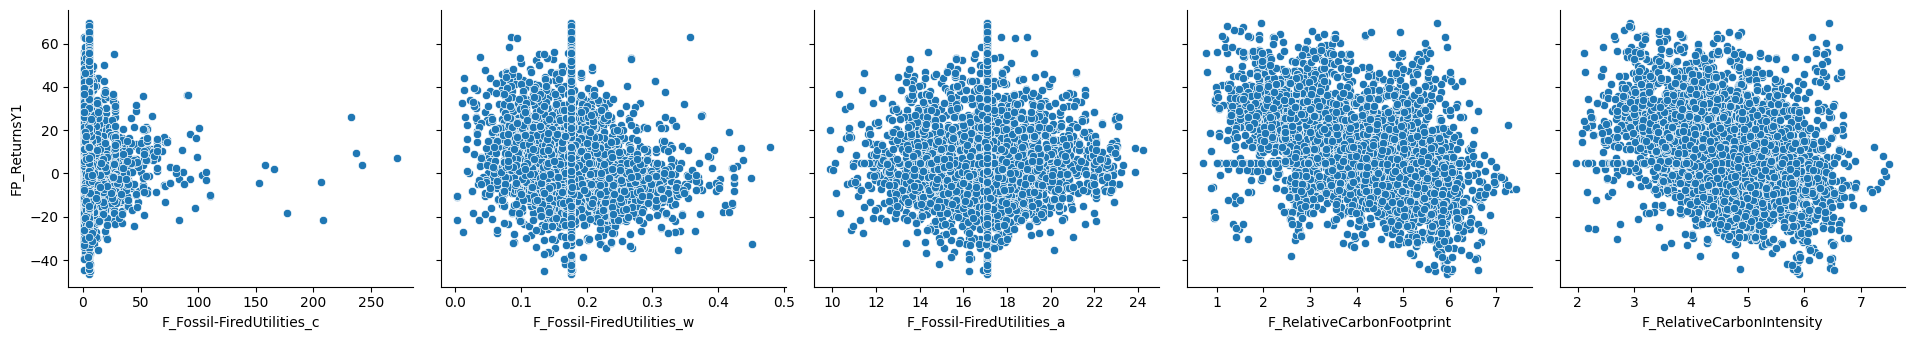

Pairplots for F numeric features - set 5/7


KeyboardInterrupt: 

In [62]:
target = 'FP_ReturnsY1'
nb_samples=5000
def chunks(l, n):
    n = max(1, n)
    return (l[i:i+n] for i in range(0, len(l), n))

for category in ['FI','FP','F','D','GE','G','W','T','P']:
    index_cols=preprocess_df.filter(regex="^"+category+"_.*",axis=1).columns
#for category in categories:
#    index_cols=list(set(getColCategory(category)) & set(preprocess_df.select_dtypes(np.number).columns))
    index_cols_numb_only=preprocess_df[index_cols].select_dtypes(exclude=object).columns
    index_cols_list=list(chunks(index_cols_numb_only, 5))
    number_sets=len(index_cols_list)
    for i in range(0,len(index_cols_list)):
        #Use sampling technique to speedup the process
        print("Pairplots for "+category+" numeric features - set "+str(i+1)+"/"+str(number_sets))
        plot= sns.pairplot(data=preprocess_df.sample(nb_samples), y_vars=target, x_vars=index_cols_list.pop(), height=3.5, aspect=1.1)
        plt.tight_layout()
        plt.show()

#### 3.a.2 Remove trend

* We try here to identify if our target has some trend that we get rid of (e.g. we had a stock market overall recovery process during 2020). One way of removing the trend is through *differencing*, which consists in computing the difference between consecutive observations.
* More information on https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/

In [63]:
for date_col in date_cols:
    preprocess_df[date_col]=preprocess_df[date_col].apply(pd.to_datetime, errors='coerce')

In [64]:
preprocess_df['FP_ReturnsY1_diff']=df['FP_ReturnsY1'].diff()

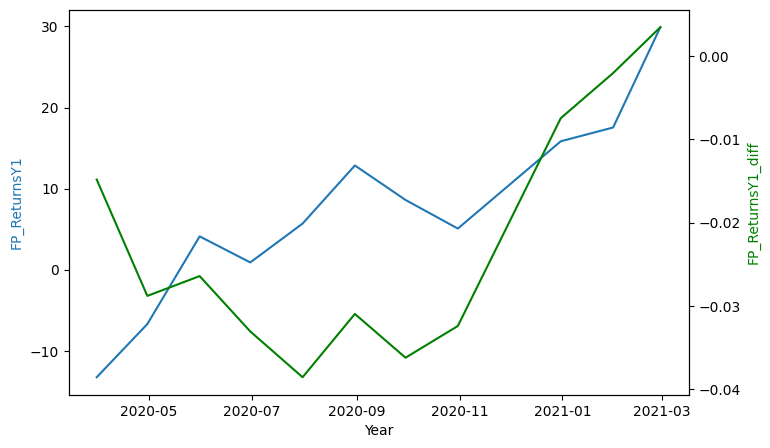

In [65]:
# create figure and axis objects with subplots()
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(preprocess_df.groupby(['FP_PerformanceAs-OfDate'])['FP_ReturnsY1'].mean(), label='Target')
ax.set_xlabel("Year")
ax.set_ylabel("FP_ReturnsY1",color='C0')

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(preprocess_df.groupby(['FP_PerformanceAs-OfDate'])['FP_ReturnsY1_diff'].mean(), color='g', label='Differenciation')
ax2.set_ylabel("FP_ReturnsY1_diff",color='g')
plt.show()

* The results from this plot shows that differenciation does not help to remove trend, we will not use this strategy.

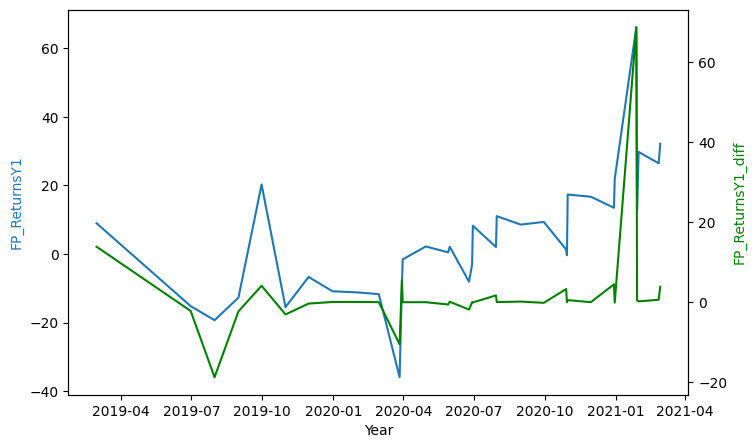

In [66]:
# create figure and axis objects with subplots()
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(preprocess_df.groupby(['FI_PortfolioHoldingsAs-OfDate'])['FP_ReturnsY1'].mean(), label='Target')
ax.set_xlabel("Year")
ax.set_ylabel("FP_ReturnsY1",color='C0')

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(preprocess_df.groupby(['FI_PortfolioHoldingsAs-OfDate'])['FP_ReturnsY1_diff'].mean(), color='g', label='Differenciation')
ax2.set_ylabel("FP_ReturnsY1_diff",color='g')
plt.show()

### 3.b) Discuss how the EDA informs your project plan
- [x] For the moment, we do not see a strong relationship (> +/-0.5) between features and our target, except for financial performance features which are closely tied together
    * Stronger correlations with other features with Y3, Y5, Y10 than Y1
- [x] The situation will improve with processing of 0/null values, the grade encoding and feature engineering (log/exp encoding)

### 3.c) What further EDA do you plan for project?
- [x] More preparation of data is required at this stage so we can ensure a good data set before our modelling for the next step

## 4) Machine learning
### (a) Phrase your project goal as a clear machine learning question
* The outcome of this project is to predict performance of a fund based on ESG features
* The target is the *Financial performance: Month end trailing returns, year 1* variable
* This is a regression problem
* Calculating a regression tree (random forest regressor) for identifing key indicators for good fund selection will also be experimented

### (b) What models are you planning to use and why?
* The principal ML training algorithm that will be used is the *Ridge regression* with :
    * Splitting for test and training data set
    * Standardization of data based on training set
    * Grid search for finding the best regularization (alpha parameter)
* The features will be select among through SelectKBest method (f_regression, mutual_info_regression)
* Models will range from
    * simple model: 3 features
    * intermediate model: 10 features to 20 features
    * complex model: all features
* We will also experiment using other ML training regressors such as *RandomForests, kNNs and neural networks* to allow comparison with results from *Ridge regression*

### (c) Please tell us your detailed machine learning strategy
* The pre-processing part will mainly required that we have no null values in our dataset
* Ridge regression with optimization of the regularization parameter will be used
* Our baseline will be the *median* of performance price return
* For assessing the accuracy of our model (cost function), we will use the MAE (Mean Absolute Error) method:
  * MAE is easy to interpret. For instance, a score of 3 means that the predictions are, in average, above or below the observed value by a distance of 3.
  * The MAE method is robust to outliers which is a nice statistical property but is difficult to optimize because it's not smooth.

* Assess individual modeles
* How could you maybe assess individual models in more detail than just their score? How could you identify weaknesses?
    * Assessment will be done through EDA, that is comparing the estimator resulting to our ML training against its target. The goal is to find possible root cause for the accuracy error and potentially adding/modifying features to reduce this error

# 5.Model fitting
## 5.1 Features selection
* Make use of SelectKBest (f_regression, mutual_info_regression) to select features of the simple model and intermediate model.
* Check that all columns of df are numbers (no null values allowed)

In [67]:
test_size_split=0.4
clean_df=pd.read_csv('/content/fossilfund_dataset_prep.csv')

In [68]:
print("How many non numerical columns:",len(clean_df.select_dtypes(['number']).columns)-len(clean_df.columns))

How many non numerical columns: -6


In [69]:
#Remove FP
clean_df.drop(columns=['FP_ReturnsY3','FP_ReturnsY5','FP_ReturnsY10'], axis=1, inplace=True)

In [70]:
#All rows contain null values
print("No. of rows containing null values", len(clean_df.isna().sum(axis=1).eq(0) ))
print("Total no. of columns in the dataframe", len(clean_df.columns))
print("No. of numerical columns ", len(clean_df.select_dtypes(np.number).columns))
print("No. of columns containing null values", len(clean_df.columns[clean_df.isna().any()]))
print("Details of columns containing null values", clean_df.columns[clean_df.isna().any()])
print("No. of columns not containing null values", len(clean_df.columns[clean_df.notna().all()]))

clean_df[clean_df.isna().any(axis=1)]

No. of rows containing null values 93718
Total no. of columns in the dataframe 122
No. of numerical columns  116
No. of columns containing null values 0
Details of columns containing null values Index([], dtype='object')
No. of columns not containing null values 122


Empty DataFrame
Columns: [FI_ShareclassInceptionDate, FI_OldestShareInceptionDate, FI_PortfolioHoldingsAs-OfDate, FI_FundNetAssets, FI_PercentRated, F_FossilFuelGrade, F_FossilFuelHoldings_c, F_FossilFuelHoldings_w, F_FossilFuelHoldings_a, F_CarbonUnderground_c, F_CarbonUnderground_w, F_CarbonUnderground_a, F_CoalIndustry_c, F_CoalIndustry_w, F_CoalIndustry_a, F_Oil/GasIndustry_w, F_Oil/GasIndustry_a, F_30Coal-FiredUtilities_c, F_30Coal-FiredUtilities_w, F_30Coal-FiredUtilities_a, F_Fossil-FiredUtilities_c, F_Fossil-FiredUtilities_w, F_Fossil-FiredUtilities_a, F_RelativeCarbonFootprint, F_RelativeCarbonIntensity, F_TotalEmissions1+2, F_CarbonMarketValueWeight, F_CarbonPortfolioCoverage, F_Clean200_c, F_Clean200_w, F_Clean200_a, D_DeforestationGrade, D_RiskProducer_c, D_RiskProducer_w, D_RiskProducer_a, D_RiskFinancier_c, D_RiskFinancier_w, D_RiskFinancier_a, D_RiskConsumerBrand_c, D_RiskConsumerBrand_w, D_RiskConsumerBrand_a, GE_GenderEqualityGrade, GE_GenderEqualityRanking, GE_CountOfHoldings, GE_WeightOfHoldings, G_CivilianFirearmGrade, G_CivilianFirearm_c, G_CivilianFirearm_w, G_CivilianFirearm_a, G_GunManufacturer_c, G_GunManufacturer_w, G_GunManufacturer_a, G_GunRetailer_c, G_GunRetailer_w, W_MilitaryWeaponGrade, W_MilitaryWeapon_c, W_MilitaryWeapon_w, W_MilitaryWeapon_a, W_NuclearWeapons_c, W_NuclearWeapons_w, W_NuclearWeapons_a, W_ClusterMunitions_c, W_ClusterMunitions_w, W_ClusterMunitions_a, T_TobaccoGrade, T_TobaccoProducer_c, T_TobaccoProducer_w, T_TobaccoProducer_a, T_Tobacco-Promoting_c, T_Tobacco-Promoting_w, T_Tobacco-Promoting_a, FP_PerformanceAs-OfDate, FP_ReturnsY1, P_PrisonIndustrialComplexGrade, P_AllFlagged_c, P_AllFlagged_w, P_AllFlagged_a, P_PrisonIndustry_c, P_PrisonIndustry_w, P_PrisonIndustry_a, P_AllFlaggedHR_c, P_AllFlaggedHR_w, P_AllFlaggedHR_a, P_PrisonIndustryHR_c, P_PrisonIndustryHR_w, P_PrisonIndustryHR_a, P_BorderIndustryHR_c, P_BorderIndustryHR_w, P_BorderIndustryHR_a, P_PrivatePrisonOperators_c, P_PrivatePrisonOperators_w, P_PrivatePrisonOperators_a, T_Tobacco-Promoting_a_isempty, P_PrisonIndustry_a_isempty, F_Fossil-FiredUtilities_a_isempty, P_AllFlagged_a_isempty, G_GunRetailer_a_isempty, W_NuclearWeapons_a_isempty, P_BorderIndustry_a_isempty, P_BorderIndustryHR_w_isempty, ...]
Index: []

[0 rows x 122 columns]

* Prepare X and y variables for the SelectKBest

In [71]:
target = 'FP_ReturnsY1'
X = clean_df.drop(columns=target)
y = clean_df[target]

In [72]:
# How many features do you want to keep?
k = 20

# Create the selecter object
skb = SelectKBest(f_regression, k=k)

# Fit the selecter to your data
X_new = skb.fit_transform(X, y)

# Extract the top k features from the `pvalues_` attribute
k_feat = np.argsort(skb.pvalues_)[:k]

# Reduce the dataframe according to the selecter
df_reduced = clean_df[X.columns[k_feat]]

In [73]:
# instantiate SelectKBest to determine 20 best features
best_features = SelectKBest(score_func=f_regression, k=k)
fit = best_features.fit(X,y)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)
# concatenate dataframes
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']  # name output columns
topk_features=feature_scores.nlargest(k,'Score')
print(topk_features)  # print top k best features

                           Feature_Name         Score
2         FI_PortfolioHoldingsAs-OfDate  34153.307546
110  P_PrivatePrisonOperators_a_isempty  21989.784315
23            F_RelativeCarbonFootprint  20258.563683
72       P_PrisonIndustrialComplexGrade  18449.127327
5                     F_FossilFuelGrade  15706.956740
114        P_PrisonIndustryHR_w_isempty  14632.881338
24            F_RelativeCarbonIntensity  14075.677581
7                F_FossilFuelHoldings_w  10192.960540
103       F_CarbonUnderground_a_isempty   8496.207382
98         P_BorderIndustryHR_w_isempty   8331.910689
92           P_PrisonIndustry_a_isempty   8121.849351
104         F_Oil/GasIndustry_w_isempty   7873.544126
15                  F_Oil/GasIndustry_w   7766.832095
106            P_AllFlaggedHR_w_isempty   7632.567155
109      F_FossilFuelHoldings_a_isempty   6924.769241
93    F_Fossil-FiredUtilities_a_isempty   5159.543110
74                       P_AllFlagged_w   4786.249004
10                F_CarbonUn

In [74]:
def plotPredictors(selection, features_scores):
    subset_features=feature_scores[feature_scores['Feature_Name'].isin(selection)].sort_values(by='Score', ascending=False)
    plt.figure(figsize=(10,5))
    plt.bar(range(len(subset_features['Score'])), subset_features['Score'])
    plt.xticks(np.arange(0, len(subset_features['Score'])), subset_features['Feature_Name'], rotation="vertical")
    #plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.tight_layout()

* We plot here the top 20 predictors (with the highest score):
 * Performance Reporting date has the best score
 * Grade and Carbon footprint are also present in the top 5
 * Absence of information (\_isempty) appear quite often

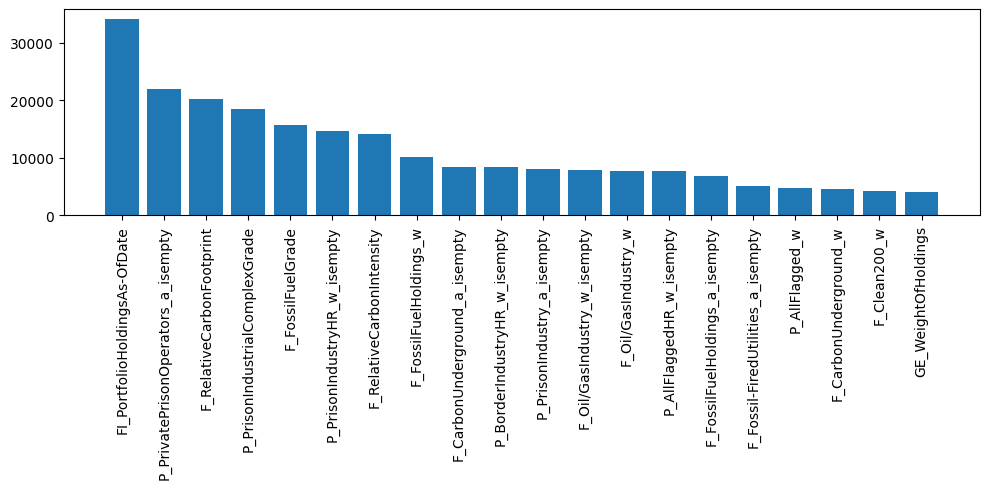

In [75]:
plotPredictors(topk_features['Feature_Name'],feature_scores)

* We plot the top features per category
 * Grade features appear quite often at the top of each category

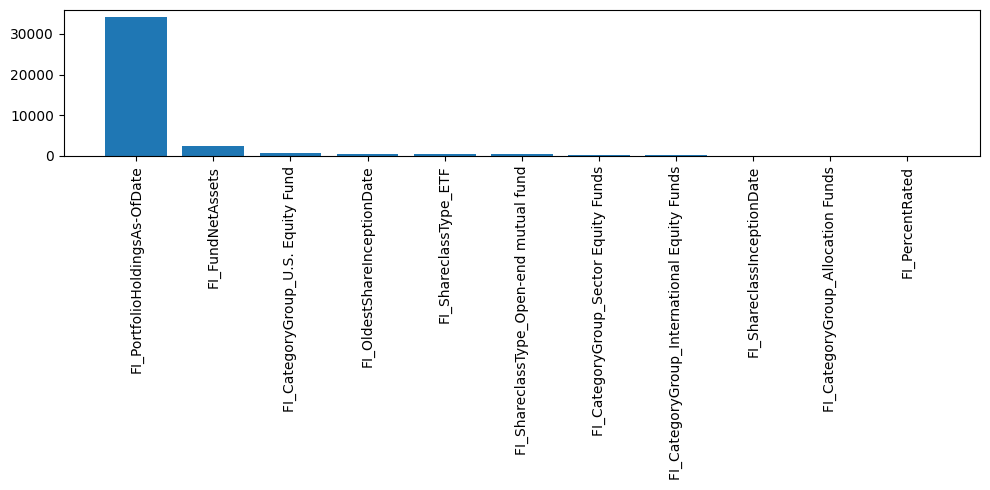

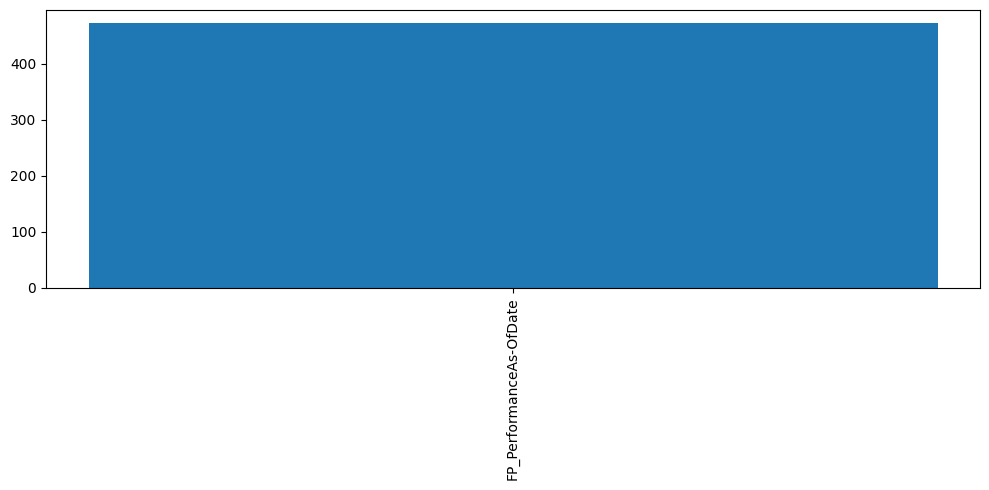

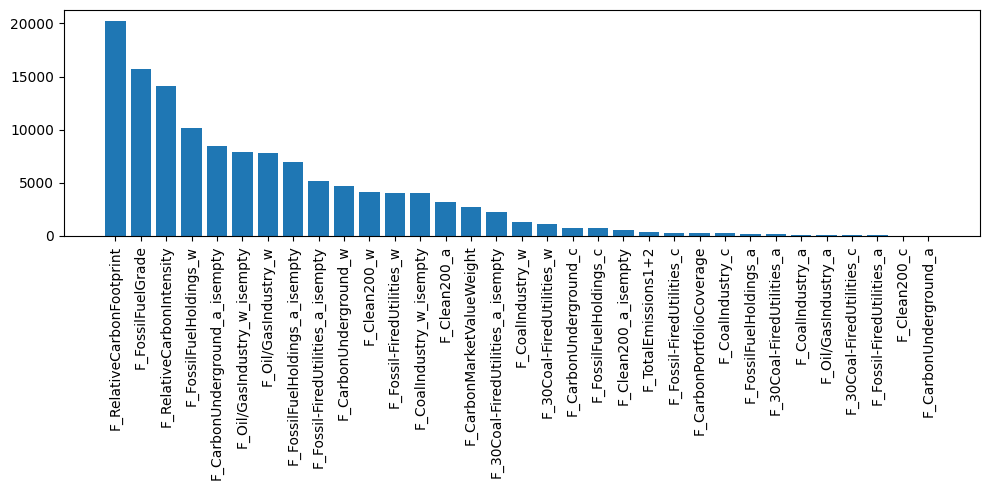

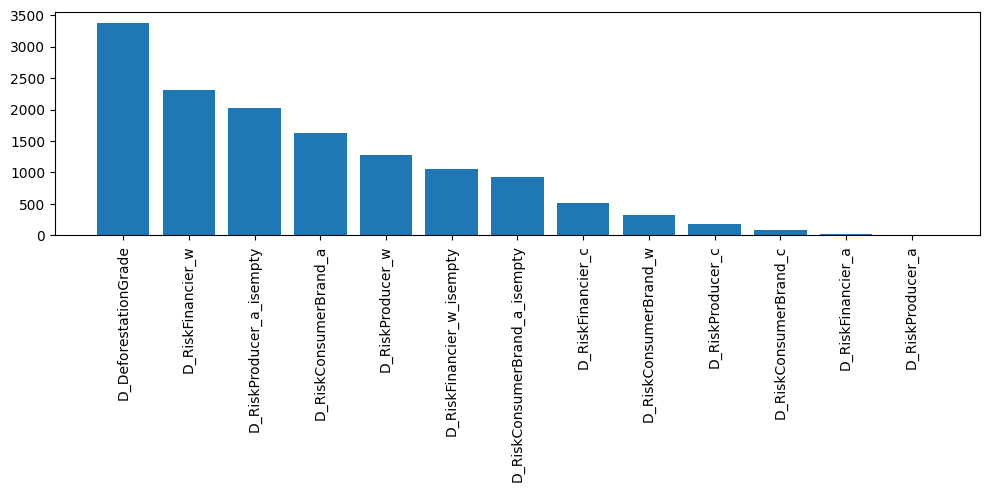

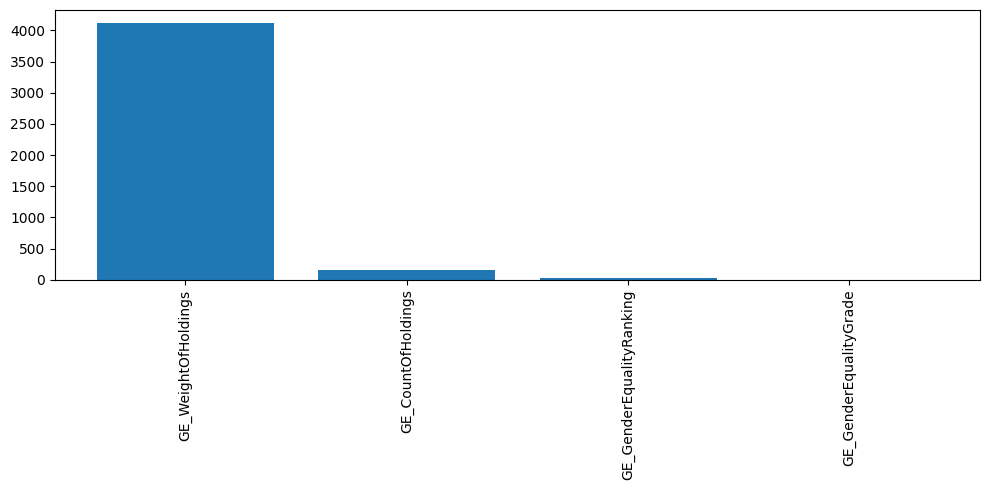

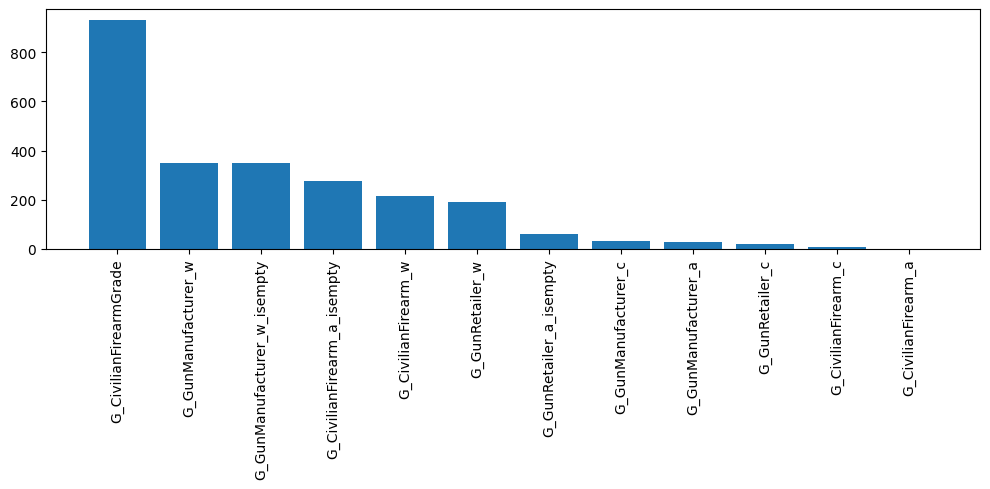

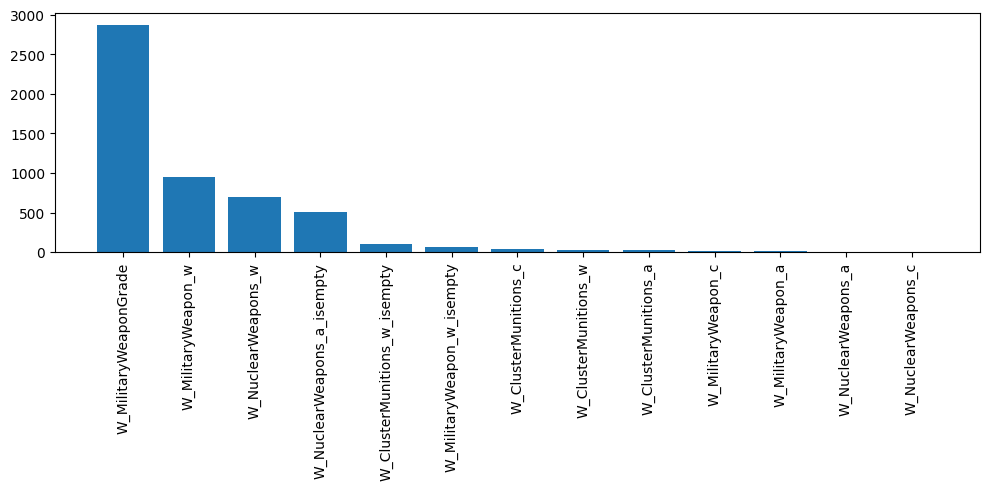

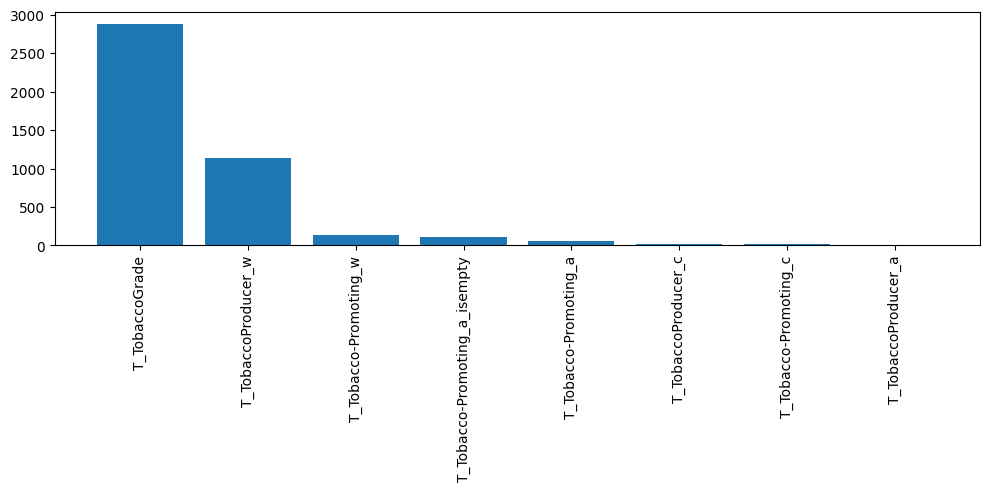

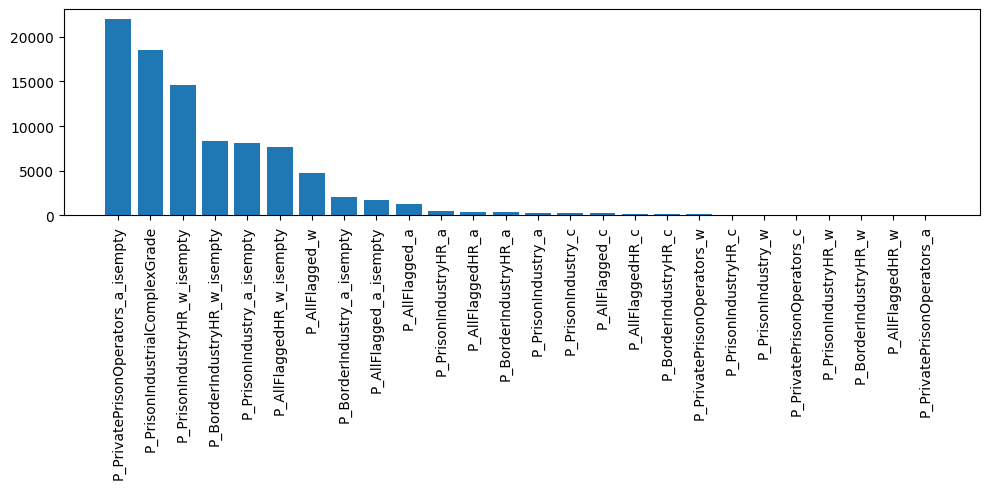

In [76]:
for category in ['FI','FP','F','D','GE','G','W','T','P']:
    featurePerCategory=feature_scores[feature_scores['Feature_Name'].str.contains("^"+category+"_.*")]['Feature_Name'].values
    plotPredictors(featurePerCategory,feature_scores)

### 5.2 To get your top feature names
* We define our 3 models based on the previous observation
 * Simple: we only keep 3 features not related to date and not related to absence of scoring (*is_empty*). We also do not select *P_PrisonIndustrialComplexGrade* as this feature had a high number of null values (33.64 %) that have been replaced by median values
 * Grade: we keep only grade features, except for the Gender equality category where *GE_WeightOfHoldings* has better scoring than the grading feature and discard *G_CivilianFirearmGrade* feature which has a too low score to be included
 * Intermediate: all top 20 features
 * Complex: all 122 features

In [115]:
features_simple_model=['F_RelativeCarbonFootprint','F_RelativeCarbonIntensity','F_FossilFuelGrade']

features_grade_model=['F_FossilFuelGrade',
'P_PrisonIndustrialComplexGrade',
'D_DeforestationGrade',
'T_TobaccoGrade',
'W_MilitaryWeaponGrade',
'F_RelativeCarbonFootprint']

features_intermediate_model=list(feature_scores.nlargest(k,'Score')['Feature_Name'].values)

features_complex_model=clean_df.drop(columns=target).columns

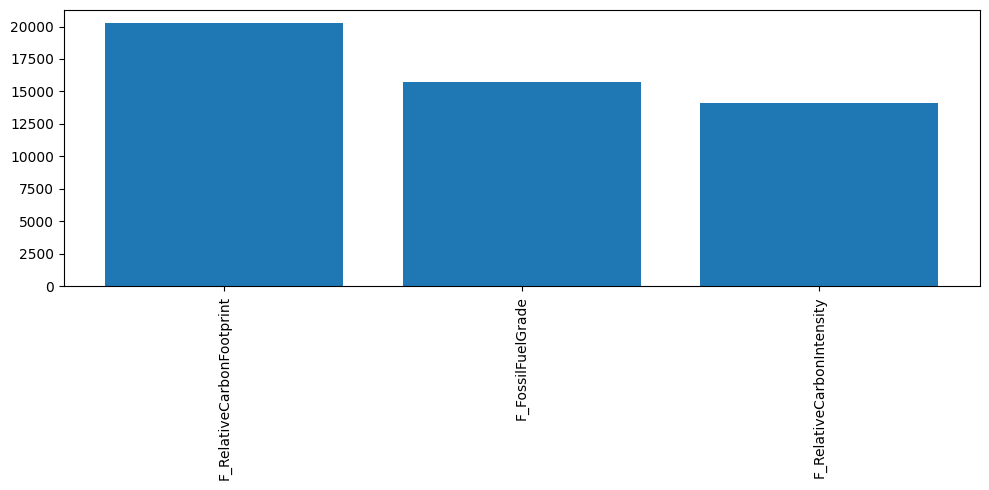

In [78]:
plotPredictors(features_simple_model,feature_scores)

In [ ]:
plotPredictors(features_grade_model,feature_scores)

In [ ]:
plotPredictors(features_intermediate_model,feature_scores)

In [ ]:
plotPredictors(features_complex_model[0:50],feature_scores)

* We calculate here the MAE score for each model using Ridge regression with grid search tuning for the regularization (alpha) parameter

* Note: Because in linear regression the value of the coefficients is partially determined by the scale of the feature, and in regularized models all coefficients are summed together, we must make sure to standardize the feature prior to training.

In [82]:
def splitTrainTest(df,target,features):
    #split current dataframe into train set / test set
    # Create X, y
    X = df[features]
    y = df[target]
    # Split into train/test sets
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size_split, random_state=0)
    # Standardize data
    scaler = StandardScaler()
    X_tr_rescaled = scaler.fit_transform(X_tr)
    X_te_rescaled = scaler.transform(X_te)

    return X_tr_rescaled, X_te_rescaled, y_tr, y_te, scaler


def saveModelResults(model, modelName, X_te_rescaled, y_te):
    mae = MAE(y_te, model.predict(X_te_rescaled))
    print('MAE with best alpha: {:,.3f}%'.format(mae))

    #Save result
    details = {
        'model' : [modelName],
        'test_accuracy' : [mae],
    }
    df = pd.DataFrame(details)
    df.to_csv('/content/data/results.csv', index=False, mode='a', header=False, float_format='%.3f')
    return [mae, model, modelName]

def RidgeModelTraining(df, features, modelName):
    X_tr_rescaled, X_te_rescaled, y_tr, y_te, scaler = splitTrainTest(df,target,features)

    # Fit/test N models for optimal regularization
    gs_results = []

    # Grid search
    for alpha in np.logspace(-8, 4, num=200):
        # Create and fit ridge regression
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_tr_rescaled, y_tr)

        # Save model and its performance on train/test sets
        gs_results.append({
            'model': ridge,
            'alpha': alpha,
            'train_mse': MSE(y_tr, ridge.predict(X_tr_rescaled)),
            'train_mae': MAE(y_tr, ridge.predict(X_tr_rescaled)),
            'test_mse': MSE(y_te, ridge.predict(X_te_rescaled)),
            'test_mae': MAE(y_te, ridge.predict(X_te_rescaled)),
        })

    # Convert results to DataFrame
    gs_results = pd.DataFrame(gs_results)

    # Plot the validation curves
    plt.plot(np.log10(gs_results['alpha']), gs_results['train_mae'], label='train curve')
    plt.plot(np.log10(gs_results['alpha']), gs_results['test_mae'], label='test curve')

    # Mark best alpha value
    best_result = gs_results.loc[gs_results.test_mae.idxmin()]
    plt.scatter(np.log10(best_result.alpha), best_result.test_mae, marker='x', c='red', zorder=10)
    plt.title('Best alpha: {:.1e} - mse: {:.4f} mae: {:,.0f}%'.format(
        best_result.alpha, best_result.test_mse, best_result.test_mae))

    plt.xlabel('$log_{10}(alpha)$')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

    ridge = Ridge(alpha=best_result.alpha)
    ridge.fit(X_tr_rescaled, y_tr)
    #mae_best=MAE(y_te, ridge.predict(X_te_rescaled))
    #print('MAE with best alpha: {:,.2f}$'.format(mae_best))
    #return [mae_best, ridge]

    return saveModelResults(ridge, modelName, X_te_rescaled, y_te)


In [83]:
#MAE baseline
X_tr_rescaled, X_te_rescaled, y_tr, y_te, scaler = splitTrainTest(clean_df,target,features_simple_model)
median_predictions = np.full_like(y_te, np.median(y_tr))
mae_baseline=MAE(y_te, median_predictions)
print('Median baseline: {:,.2f}%'.format(mae_baseline))

Median baseline: 14.47%


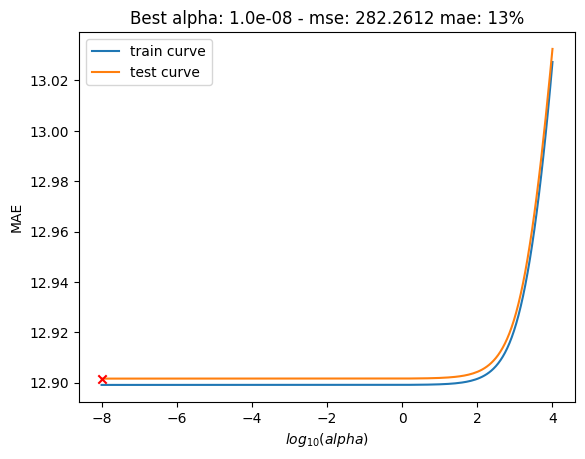

MAE with best alpha: 12.902%


In [84]:
ridge_simple = RidgeModelTraining(clean_df, features_simple_model, 'RidgeSimple')

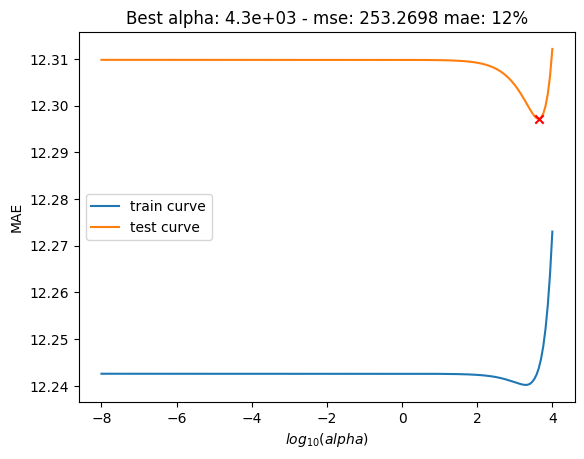

MAE with best alpha: 12.297%


In [85]:
ridge_grade = RidgeModelTraining(clean_df, features_grade_model, 'RidgeGrade')

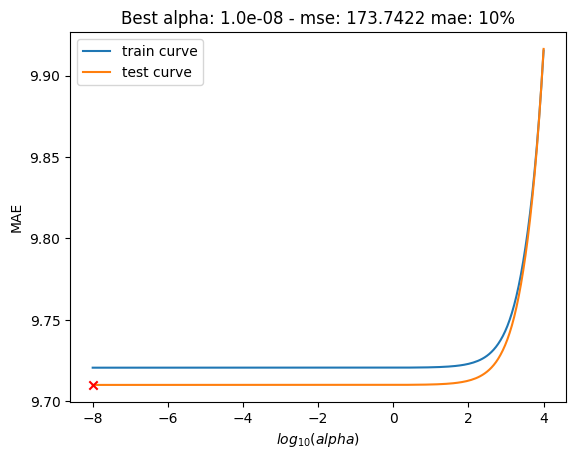

MAE with best alpha: 9.710%


In [86]:
ridge_intermediate = RidgeModelTraining(clean_df, features_intermediate_model, 'RidgeIntermediate')

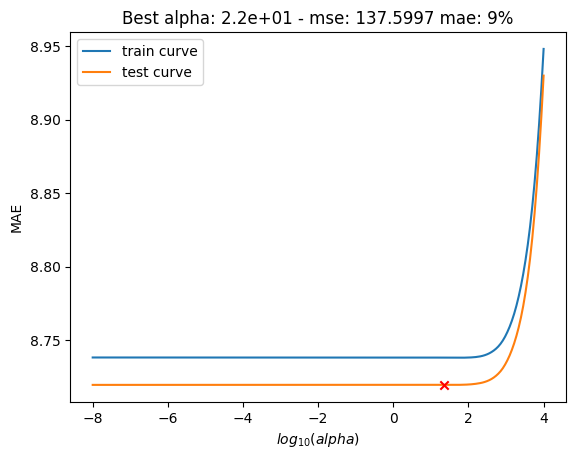

MAE with best alpha: 8.720%


In [87]:
ridge_complex = RidgeModelTraining(clean_df, features_complex_model, 'RidgeComplex')

* We finally compare the MAE and we can assess that the full model performs better than the other models (lowest MAE)

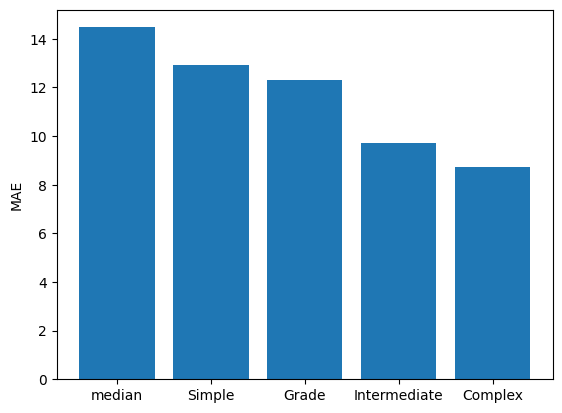

In [88]:
# Ridge comparison
mae_values = [mae_baseline, ridge_simple[0], ridge_grade[0] , ridge_intermediate[0], ridge_complex[0]]
titles = ['median', 'Simple', 'Grade','Intermediate', 'Complex']

xcor = np.arange(len(mae_values))
plt.bar(xcor, mae_values)
plt.xticks(xcor, titles)

plt.ylabel('MAE')
plt.show()

### 5.3 ML training regressors
* The simple model will be used for other ML training regressors for this chapter
* The goal is to try non-linear ML regressors to validate if we can achieve better performance (lower MAE) than ridge regression
* N.B: Hyperparameter optimization has already been ran for the ML parameters. The chapter regarding Hyperparameter will be presented later on.

In [116]:
selected_model=features_grade_model
X_tr_rescaled, X_te_rescaled, y_tr, y_te, scaler = splitTrainTest(clean_df,target,selected_model)

* For this stage, we define a RandomForestRegressor with optimal parameters coming from our hyperparameter optimization
* We achieve significantly better performance than ridge regression ! The non-linearity might explain such performance

#### 5.3.2 kNNs
* We use KNeighborsRegressor as ML regressor
* Similar to random forest, we achieve the best results due to the non-linearity of this ML

In [117]:
n_neighbors=100
p=2
weights='distance'

neigh = KNeighborsRegressor(n_neighbors=n_neighbors, p=p, weights=weights)
neigh.fit(X_tr_rescaled, y_tr)


kNNResults=saveModelResults(neigh, "KNN", X_te_rescaled, y_te)

MAE with best alpha: 2.402%


In [118]:
import pickle

In [119]:
with open('/content/data/knn_model.pkl', 'wb') as model_file:
    pickle.dump(neigh, model_file)

In [120]:
with open('/content/data/scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)